<a href="https://colab.research.google.com/github/thegallier/timeseries/blob/main/regression_20250927.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def apply_post_processing(
    W: jnp.ndarray,
    post_zero_threshold: float = 1e-6,
    post_processing_config: Dict = None,
    verbose: bool = True
) -> jnp.ndarray:
    """
    Apply post-processing to coefficients including zeroing out small values.

    Args:
        W: Coefficient matrix (n_features, n_outputs) or (n_windows, n_features, n_outputs)
        post_zero_threshold: Threshold below which coefficients are set to zero
        post_processing_config: Additional post-processing options:
            - 'zero_threshold': Threshold for zeroing (default: 1e-6)
            - 'relative_threshold': Zero if below x% of max in same output
            - 'sparsity_target': Target sparsity percentage
            - 'keep_top_k': Keep only top k coefficients per output
            - 'enforce_sign_consistency': Zero out if sign changes across windows
        verbose: Print post-processing statistics

    Returns:
        Post-processed coefficient matrix
    """

    if post_processing_config is None:
        post_processing_config = {}

    # Use config threshold if provided, otherwise use parameter
    zero_threshold = post_processing_config.get('zero_threshold', post_zero_threshold)

    W_processed = W.copy()
    original_nonzeros = jnp.sum(jnp.abs(W) > 1e-10)

    # Step 1: Zero out small absolute values
    if zero_threshold > 0:
        mask = jnp.abs(W_processed) > zero_threshold
        W_processed = W_processed * mask

        if verbose:
            zeroed = original_nonzeros - jnp.sum(mask)
            print(f"Post-processing: Zeroed {zeroed} coefficients below {zero_threshold:.2e}")

    # Step 2: Relative threshold (zero if below x% of max in same output)
    if 'relative_threshold' in post_processing_config:
        rel_threshold = post_processing_config['relative_threshold']

        if W.ndim == 2:
            # For each output, find max absolute value
            max_per_output = jnp.max(jnp.abs(W_processed), axis=0, keepdims=True)
            threshold_per_output = rel_threshold * max_per_output
            mask = jnp.abs(W_processed) > threshold_per_output
            W_processed = W_processed * mask
        else:
            # For windowed coefficients
            for w in range(W.shape[0]):
                max_per_output = jnp.max(jnp.abs(W_processed[w]), axis=0, keepdims=True)
                threshold_per_output = rel_threshold * max_per_output
                mask = jnp.abs(W_processed[w]) > threshold_per_output
                W_processed = W_processed.at[w].set(W_processed[w] * mask)

        if verbose:
            new_nonzeros = jnp.sum(jnp.abs(W_processed) > 1e-10)
            print(f"Post-processing: Relative threshold zeroed {original_nonzeros - new_nonzeros} more coefficients")

    # Step 3: Keep only top k coefficients per output
    if 'keep_top_k' in post_processing_config:
        k = post_processing_config['keep_top_k']

        if W.ndim == 2:
            n_features, n_outputs = W.shape
            for j in range(n_outputs):
                col = W_processed[:, j]
                # Get indices of top k by absolute value
                top_k_indices = jnp.argsort(jnp.abs(col))[-k:]
                mask = jnp.zeros(n_features)
                mask = mask.at[top_k_indices].set(1.0)
                W_processed = W_processed.at[:, j].set(col * mask)
        else:
            # For windowed coefficients
            for w in range(W.shape[0]):
                for j in range(W.shape[2]):
                    col = W_processed[w, :, j]
                    top_k_indices = jnp.argsort(jnp.abs(col))[-k:]
                    mask = jnp.zeros(W.shape[1])
                    mask = mask.at[top_k_indices].set(1.0)
                    W_processed = W_processed.at[w, :, j].set(col * mask)

        if verbose:
            print(f"Post-processing: Kept only top {k} coefficients per output")

    # Step 4: Enforce sign consistency across windows (for windowed coefficients)
    if 'enforce_sign_consistency' in post_processing_config and W.ndim == 3:
        if post_processing_config['enforce_sign_consistency']:
            # Check sign consistency across windows
            signs = jnp.sign(W_processed)
            mean_signs = jnp.mean(signs, axis=0)

            # Zero out if sign is not consistent (mean close to 0)
            inconsistent_mask = jnp.abs(mean_signs) < 0.5

            # Apply mask to all windows
            for w in range(W.shape[0]):
                W_processed = W_processed.at[w].set(W_processed[w] * (1 - inconsistent_mask))

            if verbose:
                n_inconsistent = jnp.sum(inconsistent_mask)
                print(f"Post-processing: Zeroed {n_inconsistent} coefficients with inconsistent signs")

    # Step 5: Target sparsity
    if 'sparsity_target' in post_processing_config:
        target_sparsity = post_processing_config['sparsity_target']
        current_sparsity = 1 - jnp.sum(jnp.abs(W_processed) > 1e-10) / W_processed.size

        if current_sparsity < target_sparsity:
            # Need to zero out more coefficients
            all_values = jnp.abs(W_processed).flatten()
            all_values = all_values[all_values > 0]  # Only non-zero values

            if len(all_values) > 0:
                # Find threshold that achieves target sparsity
                n_to_keep = int((1 - target_sparsity) * W_processed.size)
                if n_to_keep < len(all_values):
                    threshold = jnp.sort(all_values)[-(n_to_keep+1)]
                    mask = jnp.abs(W_processed) > threshold
                    W_processed = W_processed * mask

            if verbose:
                final_sparsity = 1 - jnp.sum(jnp.abs(W_processed) > 1e-10) / W_processed.size
                print(f"Post-processing: Achieved sparsity of {final_sparsity:.1%} (target: {target_sparsity:.1%})")

    # Final statistics
    if verbose:
        final_nonzeros = jnp.sum(jnp.abs(W_processed) > 1e-10)
        final_sparsity = 1 - final_nonzeros / W_processed.size
        print(f"Post-processing complete: {final_nonzeros} non-zero coefficients ({final_sparsity:.1%} sparsity)")

    return W_processed


def compute_true_r_squared_with_post_processing(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    W_raw: jnp.ndarray,
    window_size: int,
    stride: int,
    post_processing_config: Dict = None,
    verbose: bool = True
) -> Dict:
    """
    Compute true R² using post-processed coefficients (no penalties).

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        W_raw: Raw coefficients from optimization
        window_size: Window size used
        stride: Stride used
        post_processing_config: Post-processing configuration
        verbose: Print details

    Returns:
        Dictionary with R² metrics computed on post-processed coefficients
    """

    # Apply post-processing
    W_processed = apply_post_processing(
        W_raw,
        post_processing_config=post_processing_config,
        verbose=verbose
    )

    # Now compute R² using the post-processed coefficients
    n_samples = X.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    # Handle both averaged and windowed coefficients
    if W_processed.ndim == 2:
        W_expanded = jnp.expand_dims(W_processed, axis=0)
        W_expanded = jnp.repeat(W_expanded, n_windows, axis=0)
    else:
        W_expanded = W_processed

    # Create windows
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]
    Y_wins = Y[indices]

    # Compute predictions using POST-PROCESSED coefficients
    Y_pred_wins = jnp.einsum('wij,wjk->wik', X_wins, W_expanded)

    # Compute R² metrics
    Y_pred_flat = Y_pred_wins.reshape(-1)
    Y_true_flat = Y_wins.reshape(-1)

    ss_res_total = jnp.sum((Y_true_flat - Y_pred_flat) ** 2)
    ss_tot_total = jnp.sum((Y_true_flat - jnp.mean(Y_true_flat)) ** 2)
    r2_overall = 1 - ss_res_total / (ss_tot_total + 1e-10)

    # Per window R²
    r2_per_window = []
    for w in range(n_windows):
        y_true = Y_wins[w].flatten()
        y_pred = Y_pred_wins[w].flatten()

        ss_res = jnp.sum((y_true - y_pred) ** 2)
        ss_tot = jnp.sum((y_true - jnp.mean(y_true)) ** 2)
        r2 = 1 - ss_res / (ss_tot + 1e-10)
        r2_per_window.append(float(r2))

    r2_per_window = jnp.array(r2_per_window)

    # Additional metrics
    mse = jnp.mean((Y_true_flat - Y_pred_flat) ** 2)
    rmse = jnp.sqrt(mse)
    mae = jnp.mean(jnp.abs(Y_true_flat - Y_pred_flat))

    results = {
        'r2_overall': float(r2_overall),
        'r2_per_window': np.array(r2_per_window),
        'r2_mean': float(jnp.mean(r2_per_window)),
        'r2_std': float(jnp.std(r2_per_window)),
        'r2_min': float(jnp.min(r2_per_window)),
        'r2_max': float(jnp.max(r2_per_window)),
        'mse': float(mse),
        'rmse': float(rmse),
        'mae': float(mae),
        'W_processed': W_processed,
        'n_nonzero': int(jnp.sum(jnp.abs(W_processed) > 1e-10)),
        'sparsity': float(1 - jnp.sum(jnp.abs(W_processed) > 1e-10) / W_processed.size)
    }

    if verbose:
        print("\n" + "="*60)
        print("TRUE R² (Post-Processed Coefficients, No Penalties)")
        print("="*60)
        print(f"Overall R²: {r2_overall:.4f}")
        print(f"Mean R²: {results['r2_mean']:.4f} ± {results['r2_std']:.4f}")
        print(f"R² range: [{results['r2_min']:.4f}, {results['r2_max']:.4f}]")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Sparsity: {results['sparsity']:.1%}")

    return results


def example_post_processing_and_r_squared():
    """
    Example showing post-processing options and true R² computation.
    """

    print("="*80)
    print("POST-PROCESSING AND TRUE R² COMPUTATION")
    print("="*80)

    # Generate sample data
    np.random.seed(42)
    n_samples = 1256
    n_hedges = 7
    n_countries = 12
    n_tenors = 14

    # Create data with some structure
    X = np.random.randn(n_samples, n_hedges)
    true_W = np.random.randn(n_hedges, n_countries * n_tenors) * 0.3

    # Make true W sparse
    true_W[np.abs(true_W) < 0.2] = 0

    Y = X @ true_W + np.random.randn(n_samples, n_countries * n_tenors) * 0.3

    X = jnp.array(X)
    Y = jnp.array(Y)

    # Define country rules
    country_rules = {
        'BEL': {
            'allowed_countries': ['DEU', 'FRA'],
            'use_adjacent_only': False,
            'sign_constraints': {'RX': 'negative'}
        }
    }

    print("\n1. TESTING DIFFERENT POST-PROCESSING CONFIGURATIONS")
    print("-"*60)

    # Different post-processing configurations to test
    post_processing_configs = {
        'minimal': {
            'zero_threshold': 1e-10  # Almost no post-processing
        },
        'standard': {
            'zero_threshold': 1e-6   # Standard threshold
        },
        'aggressive': {
            'zero_threshold': 1e-4,  # Higher threshold
            'relative_threshold': 0.05  # Also use relative threshold
        },
        'top_k': {
            'zero_threshold': 1e-6,
            'keep_top_k': 3  # Keep only top 3 hedges per output
        },
        'target_sparsity': {
            'zero_threshold': 1e-6,
            'sparsity_target': 0.8  # Target 80% sparsity
        }
    }

    # For CVXPY, we can also set post_zero_threshold in the config
    cvxpy_configs = {
        'no_post': {
            'loss': 'squared',
            'post_zero_threshold': 0  # No post-processing
        },
        'standard_post': {
            'loss': 'squared',
            'post_zero_threshold': 1e-6  # Standard post-processing
        },
        'aggressive_post': {
            'loss': 'squared',
            'post_zero_threshold': 1e-4  # Aggressive post-processing
        },
        'with_tc': {
            'loss': 'squared',
            'transaction_costs': np.ones(n_hedges) * 0.01,
            'tc_lambda': 0.1,
            'post_zero_threshold': 1e-6  # Combine with transaction costs
        }
    }

    print("Post-processing configurations to test:")
    for name, config in post_processing_configs.items():
        print(f"  {name}: {config}")

    # Run regression
    print("\n2. RUNNING REGRESSION WITH JAX")
    print("-"*60)

    results = compute_all_countries_hedge_ratios_batch(
        X=X, Y=Y,
        country_rules=country_rules,
        window_size=200,
        stride=150,
        method='jax',
        constraint_method='penalty',
        verbose=False
    )

    W_raw = results['batch_results']['W_avg']
    print(f"Raw coefficients shape: {W_raw.shape}")
    print(f"Raw non-zeros: {jnp.sum(jnp.abs(W_raw) > 1e-10)}")

    # Test different post-processing configurations
    print("\n3. APPLYING DIFFERENT POST-PROCESSING CONFIGURATIONS")
    print("-"*60)

    r2_comparison = []

    for config_name, config in post_processing_configs.items():
        print(f"\n{config_name} configuration:")

        r2_results = compute_true_r_squared_with_post_processing(
            X, Y, W_raw,
            window_size=200,
            stride=150,
            post_processing_config=config,
            verbose=True
        )

        r2_comparison.append({
            'Config': config_name,
            'R² Overall': r2_results['r2_overall'],
            'R² Mean': r2_results['r2_mean'],
            'RMSE': r2_results['rmse'],
            'Non-zeros': r2_results['n_nonzero'],
            'Sparsity': r2_results['sparsity']
        })

    # Create comparison DataFrame
    df_comparison = pd.DataFrame(r2_comparison)

    print("\n4. POST-PROCESSING COMPARISON SUMMARY")
    print("-"*60)
    print(df_comparison.to_string(index=False))

    # Test CVXPY with different post-processing
    print("\n5. CVXPY WITH POST-PROCESSING OPTIONS")
    print("-"*60)

    try:
        import cvxpy

        cvxpy_results = []

        for config_name, config in cvxpy_configs.items():
            print(f"\nTesting CVXPY with {config_name}...")

            results_cvxpy = compute_all_countries_hedge_ratios_batch(
                X=X, Y=Y,
                country_rules=country_rules,
                window_size=200,
                stride=150,
                method='cvxpy',
                cvxpy_config=config,
                verbose=False
            )

            W_cvxpy = results_cvxpy['batch_results']['W_avg']

            # CVXPY already applies post_zero_threshold internally
            # But we can apply additional post-processing
            additional_config = {'zero_threshold': 0}  # Already done by CVXPY

            r2_results = compute_true_r_squared_with_post_processing(
                X, Y, W_cvxpy,
                window_size=200,
                stride=150,
                post_processing_config=additional_config,
                verbose=False
            )

            cvxpy_results.append({
                'Config': f'CVXPY_{config_name}',
                'R² Overall': r2_results['r2_overall'],
                'Non-zeros': r2_results['n_nonzero'],
                'Sparsity': r2_results['sparsity']
            })

            print(f"  R²: {r2_results['r2_overall']:.4f}, "
                  f"Sparsity: {r2_results['sparsity']:.1%}")

        df_cvxpy = pd.DataFrame(cvxpy_results)
        print("\nCVXPY Results:")
        print(df_cvxpy.to_string(index=False))

    except ImportError:
        print("CVXPY not available")

    # Visualize the effect of post-processing
    print("\n6. CREATING VISUALIZATION")
    print("-"*60)

    fig = visualize_post_processing_effects(r2_comparison, W_raw)

    if fig:
        plt.savefig('post_processing_r2.png', dpi=150, bbox_inches='tight')
        print("Saved to post_processing_r2.png")

    return df_comparison


def visualize_post_processing_effects(
    r2_comparison: List[Dict],
    W_raw: jnp.ndarray
) -> plt.Figure:
    """
    Visualize the effects of different post-processing configurations.
    """

    df = pd.DataFrame(r2_comparison)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: R² vs Sparsity trade-off
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df['Sparsity'], df['R² Overall'],
                         s=100, alpha=0.7, c=range(len(df)), cmap='viridis')

    for i, row in df.iterrows():
        ax1.annotate(row['Config'],
                    (row['Sparsity'], row['R² Overall']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8)

    ax1.set_xlabel('Sparsity')
    ax1.set_ylabel('R² Overall')
    ax1.set_title('R² vs Sparsity Trade-off')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Number of non-zeros
    ax2 = axes[0, 1]
    bars = ax2.bar(df['Config'], df['Non-zeros'], alpha=0.7)
    ax2.set_xlabel('Configuration')
    ax2.set_ylabel('Number of Non-zero Coefficients')
    ax2.set_title('Sparsity by Configuration')
    ax2.tick_params(axis='x', rotation=45)

    # Color bars by sparsity
    for bar, sparsity in zip(bars, df['Sparsity']):
        if sparsity > 0.8:
            bar.set_color('green')
        elif sparsity > 0.6:
            bar.set_color('orange')
        else:
            bar.set_color('red')

    # Plot 3: RMSE comparison
    ax3 = axes[1, 0]
    ax3.bar(df['Config'], df['RMSE'], alpha=0.7)
    ax3.set_xlabel('Configuration')
    ax3.set_ylabel('RMSE')
    ax3.set_title('Prediction Error by Configuration')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Summary text
    ax4 = axes[1, 1]
    ax4.axis('off')

    summary_text = "Post-Processing Options:\n" + "="*35 + "\n\n"
    summary_text += "zero_threshold: Basic threshold\n"
    summary_text += "  Set coefficients < threshold to 0\n\n"
    summary_text += "relative_threshold: % of max\n"
    summary_text += "  Zero if < x% of max in output\n\n"
    summary_text += "keep_top_k: Keep k largest\n"
    summary_text += "  Keep only top k per output\n\n"
    summary_text += "sparsity_target: Target sparsity\n"
    summary_text += "  Achieve specific sparsity %\n\n"
    summary_text += "Key Insight:\n"
    summary_text += "Post-processing creates sparser\n"
    summary_text += "solutions with small R² loss"

    ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes,
            verticalalignment='top', fontsize=10, family='monospace')

    # Add best configuration highlight
    best_idx = df['R² Overall'].idxmax()
    best_config = df.loc[best_idx, 'Config']
    best_r2 = df.loc[best_idx, 'R² Overall']
    best_sparsity = df.loc[best_idx, 'Sparsity']

    ax4.text(0.1, 0.2, f"Best R²: {best_config}\n  R²={best_r2:.4f}\n  Sparsity={best_sparsity:.1%}",
            transform=ax4.transAxes, fontsize=11, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3))

    plt.suptitle('Post-Processing Effects on Hedge Ratios', fontsize=14)
    plt.tight_layout()

    return fig


if __name__ == "__main__":
    df_comparison = example_post_processing_and_r_squared()

    print("\n" + "="*80)
    print("POST-PROCESSING EXAMPLE COMPLETED")
    print("="*80)
    print("\nKey findings:")
    print("1. Post-processing can significantly increase sparsity")
    print("2. R² is computed on final coefficients (no penalties)")
    print("3. Different thresholds create different sparsity/accuracy trade-offs")
    print("4. CVXPY's post_zero_threshold is applied automatically")
    print("5. Additional post-processing can be applied after any method")
    print("\nGenerated files:")
    print("  - post_processing_r2.png")


# Different CVXPY configs for different market conditions
configs = {
    'normal_market': {
        'loss': 'squared',
        'tc_lambda': 0.01  # Low transaction cost penalty
    },
    'volatile_market': {
        'loss': 'huber',
        'huber_delta': 0.5,  # Strong outlier resistance
        'tc_lambda': 0.1     # Higher penalty to reduce trading
    },
    'stressed_market': {
        'loss': 'huber',
        'huber_delta': 0.3,
        'dv01_neutral': True,  # Full hedging required
        'tc_lambda': 0.2       # Minimize rebalancing
    }
}


post_processing_config = {
    'zero_threshold': 1e-6,          # Absolute threshold
    'relative_threshold': 0.05,      # Zero if < 5% of max in same output
    'keep_top_k': 3,                 # Keep only top 3 coefficients per output
    'sparsity_target': 0.8,          # Achieve 80% sparsity
    'enforce_sign_consistency': True  # Zero if sign changes across windows
}

# Define post-processing for different needs
configs = {
    # Minimal cleaning
    'minimal': {
        'zero_threshold': 1e-10
    },

    # Standard cleaning
    'standard': {
        'zero_threshold': 1e-6
    },

    # Aggressive sparsification
    'sparse': {
        'zero_threshold': 1e-4,
        'relative_threshold': 0.1,  # Zero if < 10% of max
        'keep_top_k': 3              # Max 3 hedges per tenor
    },

    # Target specific sparsity
    'target_80': {
        'sparsity_target': 0.8  # Force 80% zeros
    }
}

# Run with post-processing
results = compute_all_countries_hedge_ratios_batch(...)
W_raw = results['batch_results']['W_avg']

# Apply post-processing
W_final = apply_post_processing(
    W_raw,
    post_processing_config=configs['sparse']
)

# Compute TRUE R² (on final coefficients, no penalties)
r2_results = compute_true_r_squared_with_post_processing(
    X, Y, W_raw,
    window_size=200,
    stride=150,
    post_processing_config=configs['sparse']
)

print(f"True R²: {r2_results['r2_overall']:.4f}")
print(f"Sparsity: {r2_results['sparsity']:.1%}")


# Compare methods with same post-processing
methods = ['jax_penalty', 'jax_exact', 'cvxpy']
post_config = {'zero_threshold': 1e-6}

for method in methods:
    results = run_method(method)
    W_raw = results['W_avg']

    # Apply SAME post-processing to all
    W_final = apply_post_processing(W_raw, post_config)

    # Compute R² on FINAL coefficients
    r2 = compute_r2(X, Y, W_final)

    print(f"{method}: R²={r2:.4f}, Sparsity={sparsity:.1%}")

POST-PROCESSING AND TRUE R² COMPUTATION

1. TESTING DIFFERENT POST-PROCESSING CONFIGURATIONS
------------------------------------------------------------
Post-processing configurations to test:
  minimal: {'zero_threshold': 1e-10}
  standard: {'zero_threshold': 1e-06}
  aggressive: {'zero_threshold': 0.0001, 'relative_threshold': 0.05}
  top_k: {'zero_threshold': 1e-06, 'keep_top_k': 3}
  target_sparsity: {'zero_threshold': 1e-06, 'sparsity_target': 0.8}

2. RUNNING REGRESSION WITH JAX
------------------------------------------------------------


NameError: name 'compute_all_countries_hedge_ratios_batch' is not defined

In [2]:
import jax.numpy as jnp
import numpy as np
import pandas as pd
from typing import Dict, Optional, Tuple
import matplotlib.pyplot as plt


def add_post_processing_to_results(
    results: Dict,
    X: jnp.ndarray,
    Y: jnp.ndarray,
    post_processing_config: Dict = None,
    verbose: bool = True
) -> Dict:
    """
    Add post-processing and true R² to existing results from batch computation.

    Args:
        results: Results from compute_all_countries_hedge_ratios_batch
        X: Original input data
        Y: Original output data
        post_processing_config: Post-processing configuration
        verbose: Print details

    Returns:
        Updated results with post-processed coefficients and true R²
    """

    if 'batch_results' not in results:
        print("No batch_results found")
        return results

    batch_results = results['batch_results']

    # Get configuration
    config = batch_results.get('config', {})
    window_size = config.get('window_size', 200)
    stride = config.get('stride', 150)

    # Get raw coefficients
    if 'W_all' in batch_results:
        W_raw_all = batch_results['W_all']  # (n_windows, n_features, n_outputs)
        W_raw_avg = batch_results.get('W_avg', jnp.mean(W_raw_all, axis=0))
    elif 'W_avg' in batch_results:
        W_raw_avg = batch_results['W_avg']  # (n_features, n_outputs)
        W_raw_all = None
    else:
        print("No coefficients found")
        return results

    # Default post-processing if not specified
    if post_processing_config is None:
        post_processing_config = {'zero_threshold': 1e-6}

    if verbose:
        print("="*60)
        print("POST-PROCESSING AND TRUE R² COMPUTATION")
        print("="*60)
        print(f"Post-processing config: {post_processing_config}")

    # Apply post-processing to averaged coefficients
    W_processed_avg = apply_post_processing(
        W_raw_avg,
        post_processing_config=post_processing_config,
        verbose=verbose
    )

    # Store post-processed coefficients
    results['W_processed'] = W_processed_avg
    batch_results['W_processed'] = W_processed_avg

    # Apply post-processing to all windows if available
    if W_raw_all is not None:
        W_processed_all = apply_post_processing(
            W_raw_all,
            post_processing_config=post_processing_config,
            verbose=False
        )
        results['W_processed_all'] = W_processed_all
        batch_results['W_processed_all'] = W_processed_all

    # Compute true R² using post-processed coefficients
    r2_results = compute_true_r_squared_with_post_processing(
        X, Y, W_raw_avg,
        window_size=window_size,
        stride=stride,
        post_processing_config=post_processing_config,
        verbose=verbose
    )

    # Add R² metrics to results
    results['r2_true'] = r2_results
    batch_results['r2_true'] = r2_results

    # Add post-processing config for reference
    results['post_processing_config'] = post_processing_config

    # Update country results if present
    if 'country_results' in results:
        builder = HedgeConstraintBuilder()

        for country, country_data in results['country_results'].items():
            country_idx = builder.countries.index(country)
            n_tenors = len(builder.tenors)

            # Extract post-processed coefficients for this country
            start_idx = country_idx * n_tenors
            end_idx = (country_idx + 1) * n_tenors
            W_country_processed = W_processed_avg[:, start_idx:end_idx]

            # Store in country results
            country_data['W_processed'] = W_country_processed
            country_data['n_nonzero_processed'] = int(jnp.sum(jnp.abs(W_country_processed) > 1e-10))
            country_data['sparsity_processed'] = float(1 - country_data['n_nonzero_processed'] / W_country_processed.size)

    if verbose:
        print(f"\nPost-processing complete:")
        print(f"  Original non-zeros: {jnp.sum(jnp.abs(W_raw_avg) > 1e-10)}")
        print(f"  Post-processed non-zeros: {r2_results['n_nonzero']}")
        print(f"  Sparsity achieved: {r2_results['sparsity']:.1%}")

    return results


def compare_post_processing_on_methods(
    comparison_results: Dict,
    X: jnp.ndarray,
    Y: jnp.ndarray,
    post_processing_configs: Dict[str, Dict],
    verbose: bool = True
) -> pd.DataFrame:
    """
    Apply different post-processing configs to method comparison results.

    Args:
        comparison_results: Output from compare_regression_methods
        X: Input data
        Y: Output data
        post_processing_configs: Dict of config_name -> config
        verbose: Print details

    Returns:
        DataFrame comparing R² and sparsity across methods and configs
    """

    comparison_data = []

    for method_name, method_data in comparison_results.items():
        if 'results' not in method_data:
            continue

        # Get raw coefficients from the method
        results = method_data['results']
        if 'batch_results' in results and 'W_avg' in results['batch_results']:
            W_raw = results['batch_results']['W_avg']
        else:
            continue

        # Get window configuration
        config = results['batch_results'].get('config', {})
        window_size = config.get('window_size', 200)
        stride = config.get('stride', 150)

        # Apply each post-processing configuration
        for config_name, post_config in post_processing_configs.items():

            # Compute R² with this post-processing
            r2_results = compute_true_r_squared_with_post_processing(
                X, Y, W_raw,
                window_size=window_size,
                stride=stride,
                post_processing_config=post_config,
                verbose=False
            )

            comparison_data.append({
                'Method': method_name,
                'Post-Processing': config_name,
                'R² Overall': r2_results['r2_overall'],
                'R² Mean': r2_results['r2_mean'],
                'RMSE': r2_results['rmse'],
                'Non-zeros': r2_results['n_nonzero'],
                'Sparsity': r2_results['sparsity'],
                'Time (s)': method_data.get('computation_time', np.nan)
            })

    df = pd.DataFrame(comparison_data)

    if verbose:
        print("="*60)
        print("POST-PROCESSING COMPARISON ACROSS METHODS")
        print("="*60)

        # Create pivot table for better visualization
        pivot_r2 = df.pivot_table(
            values='R² Overall',
            index='Method',
            columns='Post-Processing'
        )

        print("\nR² by Method and Post-Processing:")
        print(pivot_r2.round(4))

        pivot_sparsity = df.pivot_table(
            values='Sparsity',
            index='Method',
            columns='Post-Processing'
        )

        print("\nSparsity by Method and Post-Processing:")
        print(pivot_sparsity.round(3))

        # Find best configurations
        best_r2 = df.loc[df['R² Overall'].idxmax()]
        print(f"\nBest R²: {best_r2['Method']} with {best_r2['Post-Processing']}")
        print(f"  R² = {best_r2['R² Overall']:.4f}, Sparsity = {best_r2['Sparsity']:.1%}")

        # Find sparsest with good R²
        good_r2 = df[df['R² Overall'] > df['R² Overall'].max() * 0.95]
        sparsest_good = good_r2.loc[good_r2['Sparsity'].idxmax()]
        print(f"\nSparsest with R² > 95% of best:")
        print(f"  {sparsest_good['Method']} with {sparsest_good['Post-Processing']}")
        print(f"  R² = {sparsest_good['R² Overall']:.4f}, Sparsity = {sparsest_good['Sparsity']:.1%}")

    return df


def example_correct_usage():
    """
    Example showing the correct way to access and use post-processed results.
    """

    print("="*80)
    print("CORRECT WAY TO USE POST-PROCESSING WITH RESULTS")
    print("="*80)

    # Generate sample data
    np.random.seed(42)
    n_samples = 1256
    X = jnp.array(np.random.randn(n_samples, 7))
    Y = jnp.array(np.random.randn(n_samples, 168))

    # Country rules
    country_rules = {
        'BEL': {'allowed_countries': ['DEU', 'FRA'], 'use_adjacent_only': False},
        'NLD': {'allowed_countries': ['DEU'], 'use_adjacent_only': True}
    }

    print("\n1. SINGLE BATCH COMPUTATION (ONE VECTORIZED CALL)")
    print("-"*60)

    # ONE vectorized call that computes everything
    results = compute_all_countries_hedge_ratios_batch(
        X=X, Y=Y,
        country_rules=country_rules,
        window_size=200,
        stride=150,
        method='jax',
        constraint_method='penalty',
        verbose=False
    )

    print("Results structure after batch computation:")
    print(f"  results['batch_results']['W_avg'] shape: {results['batch_results']['W_avg'].shape}")
    print(f"  results['batch_results']['W_all'] shape: {results['batch_results']['W_all'].shape}")

    # Access raw coefficients (before post-processing)
    W_raw = results['batch_results']['W_avg']
    print(f"\nRaw coefficients:")
    print(f"  Non-zeros: {jnp.sum(jnp.abs(W_raw) > 1e-10)}")
    print(f"  Sparsity: {1 - jnp.sum(jnp.abs(W_raw) > 1e-10) / W_raw.size:.1%}")

    print("\n2. APPLYING POST-PROCESSING TO EXISTING RESULTS")
    print("-"*60)

    # Define post-processing configurations
    post_configs = {
        'standard': {'zero_threshold': 1e-6},
        'aggressive': {'zero_threshold': 1e-4, 'relative_threshold': 0.05},
        'sparse': {'zero_threshold': 1e-6, 'keep_top_k': 3}
    }

    # Apply each post-processing to the SAME results
    for config_name, config in post_configs.items():
        print(f"\n{config_name} post-processing:")

        # Add post-processing to existing results
        results_updated = add_post_processing_to_results(
            results.copy(),  # Work on a copy
            X, Y,
            post_processing_config=config,
            verbose=False
        )

        # Access post-processed coefficients
        W_processed = results_updated['W_processed']
        r2_true = results_updated['r2_true']['r2_overall']
        sparsity = results_updated['r2_true']['sparsity']

        print(f"  True R²: {r2_true:.4f}")
        print(f"  Sparsity: {sparsity:.1%}")
        print(f"  Non-zeros: {jnp.sum(jnp.abs(W_processed) > 1e-10)}")

    print("\n3. COMPARING METHODS (STILL ONE CALL PER METHOD)")
    print("-"*60)

    # Run comparison - each method is ONE vectorized call
    comparison = compare_regression_methods(
        X=X, Y=Y,
        country_rules=country_rules,
        window_size=200,
        stride=150,
        methods_to_test=['jax', 'vectorized'],
        verbose=False
    )

    print("Comparison structure:")
    for method_name in comparison.keys():
        W = comparison[method_name]['results']['batch_results']['W_avg']
        print(f"  {method_name}: W shape = {W.shape}")

    # Apply post-processing to all methods
    print("\n4. POST-PROCESSING ALL METHODS")
    print("-"*60)

    df_comparison = compare_post_processing_on_methods(
        comparison,
        X, Y,
        post_configs,
        verbose=True
    )

    print("\n5. ACCESSING SPECIFIC RESULTS")
    print("-"*60)

    # Example: Get Belgium 10yr RX coefficient after standard post-processing
    results_with_post = add_post_processing_to_results(
        results.copy(),
        X, Y,
        post_processing_config={'zero_threshold': 1e-6},
        verbose=False
    )

    builder = HedgeConstraintBuilder()
    bel_idx = builder.countries.index('BEL')
    tenor_10yr_idx = builder.tenors.index('10yr')
    rx_idx = builder.hedges.index('RX')

    # From post-processed coefficients
    W_processed = results_with_post['W_processed']
    bel_10yr_rx = W_processed[rx_idx, bel_idx * 14 + tenor_10yr_idx]

    print(f"Belgium 10yr RX coefficient (post-processed): {bel_10yr_rx:.6f}")

    # True R² for Belgium
    bel_r2 = results_with_post['country_results']['BEL'].get('r2_metrics', {})
    print(f"Belgium sparsity: {results_with_post['country_results']['BEL']['sparsity_processed']:.1%}")

    return results_with_post, df_comparison


def visualize_post_processing_from_results(
    results: Dict,
    X: jnp.ndarray,
    Y: jnp.ndarray
) -> plt.Figure:
    """
    Visualize post-processing effects directly from results.
    """

    # Apply different post-processing configs to same results
    configs = {
        'none': {'zero_threshold': 0},
        'minimal': {'zero_threshold': 1e-10},
        'standard': {'zero_threshold': 1e-6},
        'aggressive': {'zero_threshold': 1e-4},
        'sparse': {'zero_threshold': 1e-6, 'keep_top_k': 3}
    }

    metrics = []

    for name, config in configs.items():
        results_copy = results.copy()
        results_updated = add_post_processing_to_results(
            results_copy, X, Y, config, verbose=False
        )

        metrics.append({
            'Config': name,
            'R²': results_updated['r2_true']['r2_overall'],
            'Sparsity': results_updated['r2_true']['sparsity'],
            'Non-zeros': results_updated['r2_true']['n_nonzero']
        })

    df = pd.DataFrame(metrics)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # R² vs Sparsity
    ax1.scatter(df['Sparsity'], df['R²'], s=100, alpha=0.7)
    for _, row in df.iterrows():
        ax1.annotate(row['Config'],
                    (row['Sparsity'], row['R²']),
                    xytext=(5, 5), textcoords='offset points')
    ax1.set_xlabel('Sparsity')
    ax1.set_ylabel('True R² (no penalties)')
    ax1.set_title('Post-Processing Trade-off')
    ax1.grid(True, alpha=0.3)

    # Bar chart of non-zeros
    ax2.bar(df['Config'], df['Non-zeros'], alpha=0.7)
    ax2.set_ylabel('Non-zero Coefficients')
    ax2.set_title('Sparsity by Configuration')
    ax2.tick_params(axis='x', rotation=45)

    plt.suptitle('Post-Processing Effects on Single Batch Results')
    plt.tight_layout()

    return fig


if __name__ == "__main__":
    results_with_post, df_comparison = example_correct_usage()

    print("\n" + "="*80)
    print("KEY POINTS")
    print("="*80)
    print("\n1. Everything is computed in ONE vectorized call per method")
    print("2. Results contain both raw and can contain post-processed coefficients")
    print("3. R² is computed on post-processed coefficients (no penalties)")
    print("4. You can apply different post-processing to the SAME results")
    print("5. Access pattern:")
    print("   - Raw: results['batch_results']['W_avg']")
    print("   - Post-processed: results['W_processed']")
    print("   - True R²: results['r2_true']['r2_overall']")


# This ONE call computes everything for all countries/tenors/windows
results = compute_all_countries_hedge_ratios_batch(
    X=X, Y=Y,
    country_rules=country_rules,
    window_size=200,
    stride=150,
    method='jax'
)

# Raw coefficients (before post-processing)
W_raw = results['batch_results']['W_avg']  # Shape: (7, 168)
W_all_windows = results['batch_results']['W_all']  # Shape: (n_windows, 7, 168)

# Add post-processing to existing results
results = add_post_processing_to_results(
    results,
    X, Y,
    post_processing_config={'zero_threshold': 1e-6}
)

# Now access post-processed coefficients
W_processed = results['W_processed']  # Post-processed version
r2_true = results['r2_true']['r2_overall']  # R² on clean coefficients


# Compare methods - each method is ONE vectorized call
comparison = compare_regression_methods(
    X, Y, country_rules,
    window_size=200,
    stride=150,
    methods_to_test=['jax', 'vectorized', 'cvxpy']
)

# Each method's results are stored
jax_results = comparison['jax_penalty']['results']
vec_results = comparison['vectorized']['results']
cvx_results = comparison['cvxpy']['results']

# Apply post-processing to each
for method_name, method_data in comparison.items():
    W_raw = method_data['results']['batch_results']['W_avg']
    # Apply same post-processing to compare fairly
    r2_results = compute_true_r_squared_with_post_processing(
        X, Y, W_raw,
        window_size=200,
        stride=150,
        post_processing_config={'zero_threshold': 1e-6}
    )
    print(f"{method_name}: R²={r2_results['r2_overall']:.4f}")

CORRECT WAY TO USE POST-PROCESSING WITH RESULTS

1. SINGLE BATCH COMPUTATION (ONE VECTORIZED CALL)
------------------------------------------------------------


NameError: name 'compute_all_countries_hedge_ratios_batch' is not defined

In [7]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results


# ============= HELPER FUNCTIONS =============

def create_windows(data, window_size, stride):
    """Create sliding windows from data."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    windows = []
    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        windows.append(data[start:end])

    return jnp.stack(windows)


def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


def solve_ols(X, Y, reg=1e-6):
    """Basic OLS solver."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Unified discovery function."""
    # Solve unconstrained for all windows
    W_all = []
    for i in range(len(X_wins)):
        W = solve_ols(X_wins[i], Y_wins[i])
        W_all.append(W)
    W_all = jnp.stack(W_all)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    small_mask = W_abs_mean < magnitude_threshold

    # Relative threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # Combine criteria
    candidate_mask = small_mask | relative_mask

    # Check consistency
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }

    return discovery_mask, stats


# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    r2_values = []
    for i in range(len(W_all)):
        Y_pred = X_wins[i] @ W_all[i]
        ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
        ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
        r2 = 1 - ss_res / (ss_tot + 1e-8)
        r2_values.append(r2)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [jnp.array(r2_values)],
        'method_used': f'jax_{constraint_method}'
    }


def apply_kkt_constraints(X, Y, window_size, stride, discovery_mask=None,
                         offset_indices=None, fixed_constraints=None):
    """Apply constraints using KKT (exact) method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        # Apply constraints based on what's provided
        if fixed_constraints and offset_indices:
            W = apply_fixed_and_offset_kkt(
                X_win, Y_win, fixed_constraints[0], offset_indices, discovery_mask
            )
        elif fixed_constraints:
            W = apply_fixed_kkt(X_win, Y_win, fixed_constraints[0], discovery_mask)
        elif offset_indices:
            W = apply_offset_kkt(X_win, Y_win, offset_indices, discovery_mask)
        else:
            W = solve_with_zeros(X_win, Y_win, discovery_mask)

        W_all.append(W)

    return jnp.stack(W_all)


def apply_offset_kkt(X_win, Y_win, offset_indices, zero_mask=None):
    """Apply offset constraint using KKT."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    # Eliminate variable idx2
    keep_mask = [j for j in range(n_features) if j != idx2]
    X_reduced = X_win[:, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = sum(1 for j in range(idx1) if j != idx2)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, idx1_new].set(X_win[:, idx1] - X_win[:, idx2])

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Apply zero constraints if provided
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_win[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        for k, orig_idx in enumerate(keep_mask):
            W = W.at[orig_idx, j].set(w_reduced[k])
        W = W.at[idx2, j].set(-w_reduced[idx1_new])

    return W


def apply_fixed_kkt(X_win, Y_win, fixed_constraint, zero_mask=None):
    """Apply fixed value constraint using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    keep_mask = [j for j in range(n_features) if j != fixed_idx]
    X_reduced = X_win[:, keep_mask]

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        w_reduced = solve_reduced_with_zeros(
            X_reduced, Y_adjusted[:, j], keep_mask, zero_mask, j if zero_mask is not None else None
        )

        # Reconstruct
        k = 0
        for i in range(n_features):
            if i == fixed_idx:
                W = W.at[i, j].set(fixed_val)
            else:
                W = W.at[i, j].set(w_reduced[k])
                k += 1

    return W


def apply_fixed_and_offset_kkt(X_win, Y_win, fixed_constraint, offset_indices, zero_mask=None):
    """Apply both fixed and offset constraints using KKT."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_win - fixed_val * X_win[:, fixed_idx:fixed_idx+1]

    # First reduction: remove fixed variable
    keep_mask1 = [j for j in range(n_features) if j != fixed_idx]
    X_red1 = X_win[:, keep_mask1]

    # Adjust indices
    idx1_red = sum(1 for j in range(idx1) if j != fixed_idx and j < idx1)
    idx2_red = sum(1 for j in range(idx2) if j != fixed_idx and j < idx2)

    W = jnp.zeros((n_features, n_outputs))

    # Handle different cases
    if idx1 == fixed_idx:
        # w[idx2] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx2:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    elif idx2 == fixed_idx:
        # w[idx1] = -fixed_val
        for j in range(n_outputs):
            w_red = solve_reduced_with_zeros(X_red1, Y_adjusted[:, j], keep_mask1, zero_mask, j)
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                elif i == idx1:
                    W = W.at[i, j].set(-fixed_val)
                else:
                    W = W.at[i, j].set(w_red[k])
                    k += 1
    else:
        # Both constraints active, need second reduction
        keep_mask2 = [j for j in range(len(keep_mask1)) if j != idx2_red]
        X_red2 = X_red1[:, [j for j in range(len(keep_mask1)) if j != idx2_red]]

        # Adjust for offset
        idx1_red2 = sum(1 for j in range(idx1_red) if j != idx2_red)
        X_red2 = X_red2.at[:, idx1_red2].set(X_red1[:, idx1_red] - X_red1[:, idx2_red])

        for j in range(n_outputs):
            # Solve doubly-reduced system
            # This is complex - need to map zero constraints through both reductions
            w_red2 = solve_ols(X_red2, Y_adjusted[:, j])

            # Reconstruct to singly-reduced
            w_red1 = jnp.zeros(len(keep_mask1))
            k = 0
            for i in range(len(keep_mask1)):
                if i == idx2_red:
                    w_red1 = w_red1.at[i].set(-w_red2[idx1_red2])
                else:
                    w_red1 = w_red1.at[i].set(w_red2[k])
                    k += 1

            # Reconstruct to full
            k = 0
            for i in range(n_features):
                if i == fixed_idx:
                    W = W.at[i, j].set(fixed_val)
                else:
                    W = W.at[i, j].set(w_red1[k])
                    k += 1

    return W


def solve_reduced_with_zeros(X_red, y, keep_mask, zero_mask, output_idx):
    """Solve reduced system with zero constraints."""
    if zero_mask is None:
        return solve_ols(X_red, y)

    # Apply penalties for zeros in reduced space
    n_red = len(keep_mask)
    penalty_diag = jnp.zeros(n_red)

    for k, orig_idx in enumerate(keep_mask):
        if zero_mask[orig_idx, output_idx]:
            penalty_diag = penalty_diag.at[k].set(1e12)

    XtX = X_red.T @ X_red
    Xty = X_red.T @ y
    XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_red)

    return jnp.linalg.solve(XtX_pen, Xty)


def solve_with_zeros(X_win, Y_win, zero_mask):
    """Solve with only zero constraints."""
    if zero_mask is None:
        return solve_ols(X_win, Y_win)

    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]
    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win[:, j]
        XtX_pen = XtX + jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_features)
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY))

    return W


# ============= PENALTY METHOD =============

def apply_penalty_constraints(X, Y, window_size, stride, discovery_mask=None,
                            offset_indices=None, fixed_constraints=None,
                            zero_penalty=1e12, offset_penalty=1e10, fixed_penalty=1e10):
    """Apply constraints using penalty method."""
    X_wins = create_windows(X, window_size, stride)
    Y_wins = create_windows(Y, window_size, stride)

    n_windows = len(X_wins)
    W_all = []

    for i in range(n_windows):
        X_win = X_wins[i]
        Y_win = Y_wins[i]

        W = apply_penalty_window(
            X_win, Y_win,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=zero_penalty,
            offset_penalty=offset_penalty,
            fixed_penalty=fixed_penalty
        )

        W_all.append(W)

    return jnp.stack(W_all)


def apply_penalty_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                       fixed_constraints=None, zero_penalty=1e12,
                       offset_penalty=1e10, fixed_penalty=1e10, reg=1e-6):
    """Apply penalty method to single window."""
    n_features = X_win.shape[1]
    n_outputs = Y_win.shape[1]

    XtX = X_win.T @ X_win
    XtY = X_win.T @ Y_win

    W = jnp.zeros((n_features, n_outputs))

    for j in range(n_outputs):
        # Start with regularization
        penalty_matrix = reg * jnp.eye(n_features)

        # Offset penalty
        if offset_indices is not None:
            if isinstance(offset_indices, list):
                offset_indices = offset_indices[0]
            idx1, idx2 = offset_indices

            offset_matrix = jnp.zeros((n_features, n_features))
            offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
            offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)

            penalty_matrix = penalty_matrix + offset_matrix

        # Zero penalties
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # Fixed value constraints
        XtY_modified = XtY[:, j].copy()
        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                XtY_modified = XtY_modified.at[fixed_idx].add(fixed_penalty * fixed_val)

        # Solve
        XtX_pen = XtX + penalty_matrix
        W = W.at[:, j].set(jnp.linalg.solve(XtX_pen, XtY_modified))

    return W


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


def solve_all_windows_outputs_vectorized(X_wins, Y_wins, zero_mask=None, reg=1e-6):
    """Vectorized OLS for all windows and outputs."""
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    n_features = X_wins.shape[2]
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    if zero_mask is not None:
        # Apply zero constraints
        n_windows = X_wins.shape[0]
        n_outputs = Y_wins.shape[2]
        W_all = jnp.zeros((n_windows, n_features, n_outputs))

        for j in range(n_outputs):
            penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
            penalty_matrix = jnp.diag(penalty_diag)
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_all = W_all.at[:, :, j].set(W_j)

        return W_all
    else:
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)


def apply_offset_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None, reg=1e-6):
    """Vectorized offset constraint."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None, reg)

    # Reconstruct
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    # Apply zero constraints if needed
    if zero_mask is not None:
        # This is approximate - we just zero out the masked coefficients
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_fixed_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None, reg=1e-6):
    """Vectorized fixed value constraint."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, None, reg)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_all_constraints_vectorized(X_wins, Y_wins, fixed_constraint,
                                   offset_indices, zero_mask=None, reg=1e-6):
    """Apply all constraints in vectorized manner."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Apply offset constraint if valid
    if idx1 != fixed_idx and idx2 != fixed_idx:
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None, reg)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1
    else:
        # Special cases
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None, reg)

    # Final reconstruction
    W_all = jnp.zeros((n_windows, n_features, n_outputs))
    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
            j += 1

    # Handle special offset cases
    if idx1 == fixed_idx:
        W_all = W_all.at[:, idx2, :].set(-fixed_val)
    elif idx2 == fixed_idx:
        W_all = W_all.at[:, idx1, :].set(-fixed_val)

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows(X, window_size, stride)
        Y_wins = create_windows(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows(X, window_size, stride)
                Y_wins = create_windows(residual, window_size, stride)
                W_layer = jnp.stack([solve_ols(X_wins[i], Y_wins[i])
                                   for i in range(len(X_wins))])

                # Compute R²
                r2_values = []
                for i in range(len(W_layer)):
                    Y_pred = X_wins[i] @ W_layer[i]
                    ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
                    ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
                    r2 = 1 - ss_res / (ss_tot + 1e-8)
                    r2_values.append(r2)

                results = {
                    'W_all': W_layer,
                    'r2': [jnp.array(r2_values)]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ============= CONSTRAINT CHECKING =============

def check_all_constraints(W, discovery_mask, offset_indices, fixed_constraints,
                        positive_constraints, negative_constraints):
    """Check all constraint violations."""
    violations = {}

    # Zero violations
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = jnp.max(zero_violations)
        violations['zero_mean'] = jnp.mean(zero_violations)
        violations['zero_count'] = jnp.sum(zero_violations > 1e-6)

    # Offset violations
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_viols = []
            for idx1, idx2 in offset_indices:
                offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
                offset_viols.append(jnp.max(offset_viol))
            violations['offset_max'] = max(offset_viols)
            violations['offset_mean'] = np.mean(offset_viols)
        else:
            idx1, idx2 = offset_indices
            offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
            violations['offset_max'] = jnp.max(offset_viol)
            violations['offset_mean'] = jnp.mean(offset_viol)

    # Fixed violations
    if fixed_constraints is not None:
        fixed_viols = []
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_viol = jnp.abs(W[fixed_idx, :] - fixed_val)
            fixed_viols.append(jnp.max(fixed_viol))
        violations['fixed_max'] = max(fixed_viols)
        violations['fixed_mean'] = np.mean(fixed_viols)

    # Sign violations
    if positive_constraints is not None:
        pos_viols = []
        for idx in positive_constraints:
            if idx < W.shape[0]:
                pos_viol = jnp.maximum(-W[idx, :], 0)
                pos_viols.append(jnp.max(pos_viol))
        if pos_viols:
            violations['positive_max'] = max(pos_viols)

    if negative_constraints is not None:
        neg_viols = []
        for idx in negative_constraints:
            if idx < W.shape[0]:
                neg_viol = jnp.maximum(W[idx, :], 0)
                neg_viols.append(jnp.max(neg_viol))
        if neg_viols:
            violations['negative_max'] = max(neg_viols)

    return violations


def print_summary(results):
    """Print summary of results."""
    violations = results.get('violations', {})

    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, "
              f"count={violations.get('zero_count', 0)}")

    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")

    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")

    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")

    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")

    # R² summary
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============= VISUALIZATION =============

def visualize_regression_results(results, W_true=None, save_path='regression_results.png'):
    """Visualize regression results."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Extract data
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    discovery_mask = results.get('discovery_mask', None)

    # Plot 1: Average coefficients
    ax = axes[0, 0]
    im = ax.imshow(W_avg, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Average Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Plot 2: True coefficients (if provided)
    ax = axes[0, 1]
    if W_true is not None:
        im = ax.imshow(W_true, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.set_title('True Coefficients')
        plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5, 0.5, 'True coefficients\nnot provided',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')

    # Plot 3: Discovery mask
    ax = axes[0, 2]
    if discovery_mask is not None:
        im = ax.imshow(discovery_mask.astype(float), aspect='auto', cmap='Greys')
        ax.set_title(f'Discovery Mask ({jnp.sum(discovery_mask)} zeros)')
        plt.colorbar(im, ax=ax)
    else:
        ax.text(0.5, 0.5, 'No discovery mask',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')

    # Plot 4: R² over windows
    ax = axes[1, 0]
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            ax.plot(results['r2'][0], 'b-', linewidth=2)
            ax.set_title('R² Over Windows')
        else:
            for i, r2 in enumerate(results['r2']):
                ax.plot(r2, label=f'Layer {i+1}', alpha=0.7)
            ax.set_title('R² by Layer')
            ax.legend()
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.grid(True, alpha=0.3)

    # Plot 5: Constraint violations
    ax = axes[1, 1]
    violations = results.get('violations', {})
    if violations:
        viol_names = []
        viol_values = []

        if 'zero_max' in violations:
            viol_names.append('Zero')
            viol_values.append(violations['zero_max'])

        if 'offset_max' in violations:
            viol_names.append('Offset')
            viol_values.append(violations['offset_max'])

        if 'fixed_max' in violations:
            viol_names.append('Fixed')
            viol_values.append(violations['fixed_max'])

        if viol_names:
            bars = ax.bar(viol_names, viol_values)
            ax.set_ylabel('Max Violation')
            ax.set_title('Constraint Violations')
            ax.set_yscale('log')

            # Color bars based on violation level
            for bar, val in zip(bars, viol_values):
                if val > 1e-6:
                    bar.set_color('red')
                elif val > 1e-10:
                    bar.set_color('orange')
                else:
                    bar.set_color('green')
    else:
        ax.text(0.5, 0.5, 'No violations to display',
                ha='center', va='center', transform=ax.transAxes)

    # Plot 6: Method and timing info
    ax = axes[1, 2]
    info_text = f"Method: {results.get('method_used', 'Unknown')}\n"
    info_text += f"Time: {results.get('computation_time', 0):.3f}s\n"
    info_text += f"Windows: {results['config']['n_windows']}\n"

    if 'W_layers' in results:
        info_text += f"Layers: {len(results['W_layers'])}\n"

    ax.text(0.1, 0.9, info_text, transform=ax.transAxes,
            verticalalignment='top', fontsize=12, family='monospace')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Summary Information')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')

    return fig


# ============= EXAMPLE USAGE =============

def example_unified_usage():
    """Example demonstrating unified usage."""

    # Generate example data
    n_samples = 1000
    n_features = 7
    n_countries = 14
    n_tenors = 12
    n_outputs = n_countries * n_tenors

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))

    # Create true coefficients with structure
    W_true = jnp.zeros((n_features, n_outputs))

    # Offsetting hedges
    for j in range(50):
        W_true = W_true.at[2, j].set(1.5)
        W_true = W_true.at[4, j].set(-1.5)

    # Fixed value
    W_true = W_true.at[5, 20:80].set(0.3)

    # Other patterns
    W_true = W_true.at[0, 50:100].set(2.0)
    W_true = W_true.at[6, 100:150].set(-1.0)

    Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

    print("="*80)
    print("EXAMPLE: UNIFIED SLIDING REGRESSION EXTENDED")
    print("="*80)

    # Example 1: JAX with KKT
    print("\n1. JAX Method with KKT (Exact Constraints)")
    results1 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'exact',  # KKT
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Example 2: Vectorized
    print("\n2. Fully Vectorized Method")
    results2 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='vectorized',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Example 3: Penalty Method
    print("\n3. JAX Method with Penalty Constraints")
    results3 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'penalty',
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)],
            'zero_penalty': 1e12,
            'offset_penalty': 1e10,
            'fixed_penalty': 1e10
        }
    )

    # Example 4: CVXPY with Advanced Constraints
    if CVXPY_AVAILABLE:
        print("\n4. CVXPY Method with Advanced Constraints")
        results4 = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='cvxpy',
            discovery_config={
                'enabled': True,
                'consistency_threshold': 0.85,
                'magnitude_threshold': 0.08
            },
            constraints_config={
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)],
                'positive_constraints': [0],  # First coefficient must be positive
                'negative_constraints': [6]   # Last coefficient must be negative
            },
            cvxpy_config={
                'loss': 'squared',
                'dv01_neutral': False,
                'post_zero_threshold': 1e-5
            }
        )
    else:
        print("\n4. CVXPY not available - skipping")
        results4 = None

    # Example 5: Hybrid Method
    print("\n5. Hybrid Method (JAX Discovery + CVXPY Regression)")
    if CVXPY_AVAILABLE:
        results5 = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='hybrid',
            discovery_config={
                'enabled': True,
                'consistency_threshold': 0.85,
                'magnitude_threshold': 0.08
            },
            constraints_config={
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            },
            cvxpy_config={
                'loss': 'huber',
                'huber_delta': 1.0
            }
        )
    else:
        results5 = None

    # Example 6: Layered Regression
    print("\n6. Layered Regression (3 layers)")
    results6 = unified_sliding_regression_extended(
        X, Y,
        window_size=200,
        stride=50,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        layers=[{}, {}, {}],  # 3 layers
        discovery_config={
            'enabled': True,
            'consistency_threshold': 0.85,
            'magnitude_threshold': 0.08
        },
        constraints_config={
            'method': 'exact',
            'offset_indices': (2, 4),
            'fixed_constraints': [(5, 0.3)]
        }
    )

    # Visualize results
    print("\n" + "="*80)
    print("VISUALIZATION")
    print("="*80)

    # Plot results for each method
    for i, (name, results) in enumerate([
        ("JAX KKT", results1),
        ("Vectorized", results2),
        ("JAX Penalty", results3),
        ("CVXPY", results4),
        ("Hybrid", results5),
        ("Layered", results6)
    ]):
        if results is not None:
            print(f"\nVisualizing {name} results...")
            fig = visualize_regression_results(
                results,
                W_true=W_true,
                save_path=f'regression_{name.lower().replace(" ", "_")}.png'
            )
            plt.close(fig)

    # Compare methods
    print("\n" + "="*80)
    print("METHOD COMPARISON")
    print("="*80)

    comparison_data = []
    for name, results in [
        ("JAX KKT", results1),
        ("Vectorized", results2),
        ("JAX Penalty", results3),
        ("CVXPY", results4),
        ("Hybrid", results5),
        ("Layered", results6)
    ]:
        if results is not None:
            comparison_data.append({
                'Method': name,
                'Mean R²': float(jnp.mean(results['r2'][0])) if len(results['r2']) == 1 else float(jnp.mean(results['r2'][-1])),
                'Time (s)': results['computation_time'],
                'Zero Violation': float(results['violations'].get('zero_max', 0)),
                'Offset Violation': float(results['violations'].get('offset_max', 0)),
                'Fixed Violation': float(results['violations'].get('fixed_max', 0))
            })

    # Print comparison table
    if comparison_data:
        import pandas as pd
        df = pd.DataFrame(comparison_data)
        print("\n", df.to_string(index=False))

        # Save comparison
        df.to_csv('method_comparison.csv', index=False)
        print("\nComparison saved to 'method_comparison.csv'")

    return {
        'results1': results1,
        'results2': results2,
        'results3': results3,
        'results4': results4,
        'results5': results5,
        'results6': results6,
        'W_true': W_true
    }


def benchmark_methods(n_samples_list=[500, 1000, 2000],
                     n_features_list=[5, 10, 20],
                     n_outputs_list=[50, 100, 200]):
    """Benchmark different methods across problem sizes."""
    print("="*80)
    print("BENCHMARKING UNIFIED REGRESSION METHODS")
    print("="*80)

    benchmark_results = []

    for n_samples in n_samples_list:
        for n_features in n_features_list:
            for n_outputs in n_outputs_list:
                print(f"\nBenchmarking: {n_samples} samples, {n_features} features, {n_outputs} outputs")

                # Generate data
                key = jax.random.PRNGKey(42)
                X = jax.random.normal(key, (n_samples, n_features))
                W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.5
                Y = X @ W_true + 0.1 * jax.random.normal(key, (n_samples, n_outputs))

                window_size = min(200, n_samples // 5)
                stride = window_size // 4

                # Test each method
                for method in ['jax', 'vectorized', 'cvxpy', 'hybrid']:
                    if method in ['cvxpy', 'hybrid'] and not CVXPY_AVAILABLE:
                        continue

                    try:
                        start = time.time()
                        results = unified_sliding_regression_extended(
                            X, Y,
                            window_size=window_size,
                            stride=stride,
                            n_countries=1,
                            n_tenors=n_outputs,
                            method=method,
                            discovery_config={'enabled': False},  # Disable for pure speed test
                            constraints_config={}
                        )
                        elapsed = time.time() - start

                        benchmark_results.append({
                            'n_samples': n_samples,
                            'n_features': n_features,
                            'n_outputs': n_outputs,
                            'method': method,
                            'time': elapsed,
                            'mean_r2': float(jnp.mean(results['r2'][0]))
                        })

                        print(f"  {method}: {elapsed:.3f}s, R²={jnp.mean(results['r2'][0]):.4f}")

                    except Exception as e:
                        print(f"  {method}: Failed - {str(e)}")

    # Save benchmark results
    if benchmark_results:
        import pandas as pd
        df = pd.DataFrame(benchmark_results)
        df.to_csv('benchmark_results.csv', index=False)
        print("\nBenchmark results saved to 'benchmark_results.csv'")

        # Plot benchmark results
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Time vs problem size
        ax = axes[0, 0]
        for method in df['method'].unique():
            method_df = df[df['method'] == method]
            problem_size = method_df['n_samples'] * method_df['n_features'] * method_df['n_outputs']
            ax.scatter(problem_size, method_df['time'], label=method, alpha=0.7)
        ax.set_xlabel('Problem Size (n_samples × n_features × n_outputs)')
        ax.set_ylabel('Time (s)')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        ax.set_title('Computation Time vs Problem Size')
        ax.grid(True, alpha=0.3)

        # Time by method
        ax = axes[0, 1]
        df.boxplot(column='time', by='method', ax=ax)
        ax.set_ylabel('Time (s)')
        ax.set_title('Time Distribution by Method')
        ax.grid(True, alpha=0.3)

        # R² by method
        ax = axes[1, 0]
        df.boxplot(column='mean_r2', by='method', ax=ax)
        ax.set_ylabel('Mean R²')
        ax.set_title('R² Distribution by Method')
        ax.grid(True, alpha=0.3)

        # Speed vs accuracy
        ax = axes[1, 1]
        avg_by_method = df.groupby('method').agg({'time': 'mean', 'mean_r2': 'mean'})
        ax.scatter(avg_by_method['time'], avg_by_method['mean_r2'], s=100)
        for method, row in avg_by_method.iterrows():
            ax.annotate(method, (row['time'], row['mean_r2']),
                       xytext=(5, 5), textcoords='offset points')
        ax.set_xlabel('Average Time (s)')
        ax.set_ylabel('Average R²')
        ax.set_title('Speed vs Accuracy Trade-off')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('benchmark_analysis.png', dpi=150, bbox_inches='tight')
        plt.close()

        print("Benchmark analysis saved to 'benchmark_analysis.png'")

    return benchmark_results


def test_constraint_accuracy():
    """Test constraint satisfaction accuracy across methods."""
    print("="*80)
    print("TESTING CONSTRAINT ACCURACY")
    print("="*80)

    # Generate test data
    n_samples = 500
    n_features = 10
    n_outputs = 50

    key = jax.random.PRNGKey(42)
    X = jax.random.normal(key, (n_samples, n_features))
    W_true = jax.random.normal(key, (n_features, n_outputs)) * 0.5

    # Apply true constraints
    W_true = W_true.at[2, :].set(1.5)
    W_true = W_true.at[4, :].set(-1.5)  # Offset constraint
    W_true = W_true.at[5, :].set(0.3)    # Fixed constraint
    W_true = W_true.at[7:9, :].set(0.0)  # Zero constraints

    Y = X @ W_true + 0.05 * jax.random.normal(key, (n_samples, n_outputs))

    # Create discovery mask
    discovery_mask = jnp.zeros((n_features, n_outputs), dtype=bool)
    discovery_mask = discovery_mask.at[7:9, :].set(True)

    # Test configurations
    test_configs = [
        {
            'name': 'JAX KKT',
            'method': 'jax',
            'constraints_config': {
                'method': 'exact',
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        },
        {
            'name': 'JAX Penalty',
            'method': 'jax',
            'constraints_config': {
                'method': 'penalty',
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)],
                'zero_penalty': 1e14,
                'offset_penalty': 1e12,
                'fixed_penalty': 1e12
            }
        },
        {
            'name': 'Vectorized',
            'method': 'vectorized',
            'constraints_config': {
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        }
    ]

    if CVXPY_AVAILABLE:
        test_configs.append({
            'name': 'CVXPY',
            'method': 'cvxpy',
            'constraints_config': {
                'offset_indices': (2, 4),
                'fixed_constraints': [(5, 0.3)]
            }
        })

    # Run tests
    results_summary = []

    for config in test_configs:
        print(f"\nTesting {config['name']}...")

        results = unified_sliding_regression_extended(
            X, Y,
            window_size=200,
            stride=50,
            n_countries=1,
            n_tenors=n_outputs,
            method=config['method'],
            discovery_config={
                'enabled': False,
                'forced_mask': discovery_mask
            },
            constraints_config=config['constraints_config']
        )

        W_avg = results['W_avg']
        violations = results['violations']

        # Compute additional metrics
        rmse = float(jnp.sqrt(jnp.mean((W_avg - W_true)**2)))

        results_summary.append({
            'Method': config['name'],
            'RMSE': rmse,
            'Zero Violation': violations.get('zero_max', 0),
            'Offset Violation': violations.get('offset_max', 0),
            'Fixed Violation': violations.get('fixed_max', 0),
            'Mean R²': float(jnp.mean(results['r2'][0]))
        })

        print(f"  RMSE: {rmse:.6f}")
        print(f"  Violations - Zero: {violations.get('zero_max', 0):.2e}, "
              f"Offset: {violations.get('offset_max', 0):.2e}, "
              f"Fixed: {violations.get('fixed_max', 0):.2e}")

    # Display summary
    if results_summary:
        import pandas as pd
        df = pd.DataFrame(results_summary)
        print("\n" + "="*80)
        print("CONSTRAINT ACCURACY SUMMARY")
        print("="*80)
        print(df.to_string(index=False))

        # Save results
        df.to_csv('constraint_accuracy.csv', index=False)
        print("\nResults saved to 'constraint_accuracy.csv'")

    return results_summary


if __name__ == "__main__":
    # Run examples
    print("Running unified regression examples...")
    example_results = example_unified_usage()

    # Run benchmarks (optional - comment out for faster execution)
    # print("\nRunning benchmarks...")
    # benchmark_results = benchmark_methods(
    #     n_samples_list=[500, 1000],
    #     n_features_list=[5, 10],
    #     n_outputs_list=[50, 100]
    # )

    # Test constraint accuracy
    print("\nTesting constraint accuracy...")
    accuracy_results = test_constraint_accuracy()

    print("\n" + "="*80)
    print("ALL TESTS COMPLETED")
    print("="*80)


Running unified regression examples...
EXAMPLE: UNIFIED SLIDING REGRESSION EXTENDED

1. JAX Method with KKT (Exact Constraints)

Unified Sliding Regression Extended
  Method: jax
  Data: 1000 samples, 7 features, 168 outputs
  Windows: 17 (size 200, stride 50)

Phase 1: Discovering zero patterns...
  Discovered 916 zeros (77.9% sparsity)

Phase 2: Applying jax regression...

Completed in 47.034 seconds
  Zero violations: max=3.00e-01, count=916
  Offset violations: max=0.00e+00
  Fixed violations: max=0.00e+00
  Mean R²: 0.9762

2. Fully Vectorized Method

Unified Sliding Regression Extended
  Method: vectorized
  Data: 1000 samples, 7 features, 168 outputs
  Windows: 17 (size 200, stride 50)

Phase 1: Discovering zero patterns...
  Discovered 916 zeros (77.9% sparsity)

Phase 2: Applying vectorized regression...

Completed in 1.766 seconds
  Zero violations: max=0.00e+00, count=0
  Offset violations: max=0.00e+00
  Fixed violations: max=3.00e-01
  Mean R²: 0.9963

3. JAX Method with P

In [5]:
class HedgeConstraintBuilder:
    """
    Builder for hedge ratio constraints based on country/tenor rules.

    The hedge futures mapping:
    - Index 0-3: DEU futures (DU, OE, RX, UB)
    - Index 4: FRA future (OAT)
    - Index 5-6: ITA futures (IK, BTS)
    """

    def __init__(self):
        # Define the complete mapping
        self.countries = [
            'DEU', 'FRA', 'ITA', 'ESP', 'PRT', 'BEL',
            'IRL', 'GRC', 'NLD', 'EUR', 'AUT', 'FIN'
        ]

        self.tenors = [
            '2yr', '3yr', '4yr', '5yr', '6yr', '7yr', '8yr',
            '9yr', '10yr', '12yr', '15yr', '20yr', '30yr', '50yr'
        ]

        # Hedge futures and their country origins
        self.hedges = ['DU', 'OE', 'RX', 'UB', 'OAT', 'IK', 'BTS']
        self.hedge_countries = ['DEU', 'DEU', 'DEU', 'DEU', 'FRA', 'ITA', 'ITA']

        # Map hedge names to indices
        self.hedge_to_idx = {h: i for i, h in enumerate(self.hedges)}

        # Map countries to their hedge indices
        self.country_to_hedge_indices = {
            'DEU': [0, 1, 2, 3],  # DU, OE, RX, UB
            'FRA': [4],           # OAT
            'ITA': [5, 6]         # IK, BTS
        }

        # Tenor maturity mapping for adjacent futures selection
        # Maps each future to the tenors it typically covers
        self.hedge_tenor_mapping = {
            'DU': [0, 1],          # 2yr, 3yr (short end)
            'OE': [2, 3, 4],       # 4yr, 5yr, 6yr
            'RX': [5, 6, 7, 8],    # 7yr, 8yr, 9yr, 10yr
            'UB': [9, 10, 11],     # 12yr, 15yr, 20yr
            'OAT': [8, 9, 10],     # 10yr, 12yr, 15yr
            'IK': [7, 8, 9],       # 9yr, 10yr, 12yr
            'BTS': [11, 12, 13]    # 20yr, 30yr, 50yr
        }

    def get_adjacent_hedges_for_tenor(self, tenor_idx: int) -> List[int]:
        """
        Get the hedge indices that are 'adjacent' (most relevant) for a given tenor.
        Returns at most 2 adjacent futures, or 1 if only one is relevant.
        """
        adjacent = []

        for hedge_name, hedge_idx in self.hedge_to_idx.items():
            tenor_coverage = self.hedge_tenor_mapping[hedge_name]

            # Check if this hedge covers the tenor
            if tenor_idx in tenor_coverage:
                # Calculate distance to find the most relevant
                distances = [abs(tenor_idx - t) for t in tenor_coverage]
                min_distance = min(distances)

                # Add hedge with a priority score (lower is better)
                adjacent.append((hedge_idx, min_distance))

        # Sort by distance and take the 2 closest
        adjacent.sort(key=lambda x: x[1])

        # Return hedge indices only
        result = [h[0] for h in adjacent[:2]]

        # If no adjacent found, use the closest hedges based on tenor range
        if not result:
            if tenor_idx <= 1:  # Very short end
                result = [0]  # DU
            elif tenor_idx <= 4:  # Short-medium
                result = [1, 2]  # OE, RX
            elif tenor_idx <= 8:  # Medium
                result = [2, 3]  # RX, UB
            elif tenor_idx <= 11:  # Long
                result = [3, 4]  # UB, OAT
            else:  # Very long
                result = [6]  # BTS

        return result


def compute_country_hedge_constraints(
    target_country: str,
    allowed_countries: List[str],
    use_adjacent_only: bool = False,
    sign_constraints: Dict[str, str] = None,
    penalty_strengths: Dict[str, float] = None
) -> dict:
    """
    Generate constraints configuration for hedge ratio optimization.

    Args:
        target_country: The country whose bonds we're hedging (e.g., 'BEL')
        allowed_countries: List of countries whose futures can be used (e.g., ['DEU', 'FRA'])
        use_adjacent_only: If True, use only 1-2 adjacent futures per tenor; if False, use all qualified
        sign_constraints: Dict mapping hedge names to 'positive' or 'negative' (e.g., {'RX': 'negative'})
        penalty_strengths: Optional override for penalty values

    Returns:
        Dictionary with constraints configuration for unified_sliding_regression_extended

    Example:
        constraints = compute_country_hedge_constraints(
            target_country='BEL',
            allowed_countries=['DEU', 'FRA'],
            use_adjacent_only=True,
            sign_constraints={'RX': 'negative'}
        )
    """

    builder = HedgeConstraintBuilder()

    # Validate inputs
    if target_country not in builder.countries:
        raise ValueError(f"Unknown target country: {target_country}")

    for country in allowed_countries:
        if country not in builder.countries:
            raise ValueError(f"Unknown allowed country: {country}")

    if sign_constraints:
        for hedge in sign_constraints.keys():
            if hedge not in builder.hedges:
                raise ValueError(f"Unknown hedge: {hedge}")

    # Default penalty strengths
    default_penalties = {
        'zero_penalty': 1e12,
        'offset_penalty': 1e10,
        'fixed_penalty': 1e10,
        'positive_penalty': 1e10,
        'negative_penalty': 1e10
    }

    if penalty_strengths:
        default_penalties.update(penalty_strengths)

    # Initialize constraint lists
    fixed_constraints = []  # List of (index, value) tuples
    positive_constraints = []  # List of indices that must be >= 0
    negative_constraints = []  # List of indices that must be <= 0

    # Get target country index
    target_country_idx = builder.countries.index(target_country)

    # Determine which hedges are allowed based on country restrictions
    allowed_hedge_indices = set()
    for country in allowed_countries:
        if country in builder.country_to_hedge_indices:
            allowed_hedge_indices.update(builder.country_to_hedge_indices[country])

    # Build constraints for each output (country-tenor combination)
    # The output Y has shape (n_samples, n_countries * n_tenors) = (n_samples, 168)
    # We're focusing on one country, so we have 14 outputs (one per tenor)

    n_hedges = len(builder.hedges)
    n_tenors = len(builder.tenors)

    # For each tenor of the target country
    for tenor_idx in range(n_tenors):
        # Output index in the full Y matrix
        output_idx = target_country_idx * n_tenors + tenor_idx

        # Determine which hedges to use for this tenor
        if use_adjacent_only:
            # Get adjacent hedges for this tenor
            adjacent_hedges = builder.get_adjacent_hedges_for_tenor(tenor_idx)
            # Filter by allowed countries
            tenor_allowed_hedges = [h for h in adjacent_hedges if h in allowed_hedge_indices]
        else:
            # Use all allowed hedges
            tenor_allowed_hedges = list(allowed_hedge_indices)

        # Create constraints for hedges not allowed for this tenor
        for hedge_idx in range(n_hedges):
            # The coefficient index in W matrix would be hedge_idx
            # W has shape (n_hedges, n_outputs) = (7, 14) for single country

            if hedge_idx not in tenor_allowed_hedges:
                # This hedge should be fixed at 0 for this tenor
                # Using fixed_constraints: (coefficient_index, value)
                fixed_constraints.append((hedge_idx, 0.0))

    # Apply sign constraints
    if sign_constraints:
        for hedge_name, sign in sign_constraints.items():
            hedge_idx = builder.hedge_to_idx[hedge_name]

            # Check if this hedge is in the allowed set
            if hedge_idx in allowed_hedge_indices:
                if sign == 'positive':
                    positive_constraints.append(hedge_idx)
                elif sign == 'negative':
                    negative_constraints.append(hedge_idx)
                else:
                    raise ValueError(f"Sign must be 'positive' or 'negative', got: {sign}")

    # Build the constraints configuration
    constraints_config = {
        'method': 'penalty',  # or 'exact' for KKT method
        **default_penalties
    }

    if fixed_constraints:
        constraints_config['fixed_constraints'] = fixed_constraints

    if positive_constraints:
        constraints_config['positive_constraints'] = positive_constraints

    if negative_constraints:
        constraints_config['negative_constraints'] = negative_constraints

    # Add summary information
    constraints_config['summary'] = {
        'target_country': target_country,
        'allowed_countries': allowed_countries,
        'allowed_hedges': [builder.hedges[i] for i in sorted(allowed_hedge_indices)],
        'use_adjacent_only': use_adjacent_only,
        'sign_constraints': sign_constraints or {},
        'n_zero_constraints': len([c for c in fixed_constraints if c[1] == 0.0]),
        'n_positive_constraints': len(positive_constraints),
        'n_negative_constraints': len(negative_constraints)
    }

    return constraints_config


def compute_country_hedge_ratios_v2(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    target_country: str,
    allowed_countries: List[str],
    use_adjacent_only: bool,
    sign_constraints: Dict[str, str],
    window_size: int,
    stride: int,
    method: str = 'jax',
    discovery_config: dict = None,
    cvxpy_config: dict = None,
    penalty_strengths: dict = None
) -> dict:
    """
    Wrapper function to compute hedge ratios for a specific country with constraints.

    Args:
        X: Input hedge data (n_samples, n_hedges)
        Y: Output country-tenor data (n_samples, n_countries * n_tenors)
        target_country: Country to hedge (e.g., 'BEL')
        allowed_countries: Countries whose hedges can be used (e.g., ['DEU', 'FRA'])
        use_adjacent_only: If True, use only adjacent futures
        sign_constraints: Sign constraints on specific hedges (e.g., {'RX': 'negative'})
        window_size: Size of sliding window
        stride: Stride for sliding window
        method: Regression method
        discovery_config: Zero discovery configuration
        cvxpy_config: CVXPY configuration
        penalty_strengths: Override penalty strengths

    Returns:
        Results dictionary with hedge ratios and diagnostics
    """

    builder = HedgeConstraintBuilder()

    # Generate constraints
    constraints_config = compute_country_hedge_constraints(
        target_country=target_country,
        allowed_countries=allowed_countries,
        use_adjacent_only=use_adjacent_only,
        sign_constraints=sign_constraints,
        penalty_strengths=penalty_strengths
    )

    # Extract Y data for target country
    target_idx = builder.countries.index(target_country)
    n_tenors = len(builder.tenors)

    start_idx = target_idx * n_tenors
    end_idx = (target_idx + 1) * n_tenors
    Y_country = Y[:, start_idx:end_idx]

    # Run regression
    # Note: X should have shape (n_samples, n_hedges) = (n_samples, 7)
    # Y_country has shape (n_samples, n_tenors) = (n_samples, 14)

    results = unified_sliding_regression_extended(
        X=X,
        Y=Y_country,
        window_size=window_size,
        stride=stride,
        n_countries=1,  # We're focusing on one country
        n_tenors=n_tenors,
        method=method,
        discovery_config=discovery_config,
        constraints_config=constraints_config,
        cvxpy_config=cvxpy_config
    )

    # Add metadata
    results['target_country'] = target_country
    results['allowed_countries'] = allowed_countries
    results['constraints_summary'] = constraints_config['summary']

    # Create interpretable output
    if 'W_avg' in results:
        # W_avg shape: (n_hedges, n_tenors) = (7, 14)
        hedge_ratios = {}
        for tenor_idx, tenor in enumerate(builder.tenors):
            hedge_ratios[tenor] = {}
            for hedge_idx, hedge in enumerate(builder.hedges):
                value = float(results['W_avg'][hedge_idx, tenor_idx])
                if abs(value) > 1e-10:  # Only show non-zero values
                    hedge_ratios[tenor][hedge] = value

        results['hedge_ratios_by_tenor'] = hedge_ratios

    return results


# Example usage
def example_usage():
    """
    Example showing how to use the constraint builder for BEL with specific rules.
    """
    import jax.numpy as jnp
    import jax.random as random

    # Generate sample data
    key = random.PRNGKey(42)
    n_samples = 1000
    n_hedges = 7
    n_countries = 12
    n_tenors = 14

    # X: hedge data (n_samples, n_hedges)
    X = random.normal(key, (n_samples, n_hedges))

    # Y: country-tenor data (n_samples, n_countries * n_tenors)
    Y = random.normal(random.split(key)[1], (n_samples, n_countries * n_tenors))

    # Example 1: BEL hedged with DEU and FRA futures, adjacent only, RX must be negative
    print("Example 1: Belgium with constraints")
    print("-" * 50)

    constraints = compute_country_hedge_constraints(
        target_country='BEL',
        allowed_countries=['DEU', 'FRA'],
        use_adjacent_only=True,
        sign_constraints={'RX': 'negative'}
    )

    print(f"Target country: {constraints['summary']['target_country']}")
    print(f"Allowed countries: {constraints['summary']['allowed_countries']}")
    print(f"Allowed hedges: {constraints['summary']['allowed_hedges']}")
    print(f"Number of zero constraints: {constraints['summary']['n_zero_constraints']}")
    print(f"Sign constraints: {constraints['summary']['sign_constraints']}")

    # Example 2: Run full regression for BEL
    print("\nExample 2: Running regression for Belgium")
    print("-" * 50)

    results = compute_country_hedge_ratios_v2(
        X=X,
        Y=Y,
        target_country='BEL',
        allowed_countries=['DEU', 'FRA'],
        use_adjacent_only=True,
        sign_constraints={'RX': 'negative', 'OAT': 'positive'},
        window_size=250,
        stride=20,
        method='jax',
        discovery_config={'enabled': False}
    )

    print(f"Computation completed in {results.get('computation_time', 0):.3f} seconds")

    # Example 3: Multiple countries with different rules
    print("\nExample 3: Multiple countries with different rules")
    print("-" * 50)

    country_rules = {
        'BEL': {
            'allowed_countries': ['DEU', 'FRA'],
            'use_adjacent_only': True,
            'sign_constraints': {'RX': 'negative'}
        },
        'IRL': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': False,
            'sign_constraints': {}
        },
        'GRC': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': True,
            'sign_constraints': {'BTS': 'positive'}
        }
    }

    for country, rules in country_rules.items():
        constraints = compute_country_hedge_constraints(
            target_country=country,
            **rules
        )

        print(f"\n{country}:")
        print(f"  Allowed hedges: {constraints['summary']['allowed_hedges']}")
        print(f"  Zero constraints: {constraints['summary']['n_zero_constraints']}")
        print(f"  Sign constraints: {constraints['summary']['sign_constraints']}")

    return results


if __name__ == "__main__":
    results = example_usage()

Example 1: Belgium with constraints
--------------------------------------------------
Target country: BEL
Allowed countries: ['DEU', 'FRA']
Allowed hedges: ['DU', 'OE', 'RX', 'UB', 'OAT']
Number of zero constraints: 83
Sign constraints: {'RX': 'negative'}

Example 2: Running regression for Belgium
--------------------------------------------------


NameError: name 'unified_sliding_regression_extended' is not defined

In [31]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import List, Dict, Optional, Tuple
import time


def create_batch_constraints_for_all_countries(
    country_rules: Dict[str, dict],
    n_hedges: int = 7,
    n_tenors: int = 14,
    n_countries: int = 12
) -> Tuple[jnp.ndarray, Dict]:
    """
    Create a single large discovery mask and constraints for all countries at once.
    This allows processing all countries in a single GPU call.

    Args:
        country_rules: Dict mapping each country to its hedging rules
            Example: {
                'BEL': {
                    'allowed_countries': ['DEU', 'FRA'],
                    'use_adjacent_only': True,
                    'sign_constraints': {'RX': 'negative'}
                },
                'IRL': {...}
            }
        n_hedges: Number of hedge instruments (7)
        n_tenors: Number of tenors (14)
        n_countries: Number of countries (12)

    Returns:
        - discovery_mask: Shape (n_hedges, n_countries * n_tenors)
        - constraints_dict: Combined constraints for all countries
    """

    builder = HedgeConstraintBuilder()

    # Create a large discovery mask for all countries
    # Shape: (n_hedges, n_countries * n_tenors) = (7, 168)
    full_discovery_mask = np.ones((n_hedges, n_countries * n_tenors), dtype=bool)

    # Collect all sign constraints with their applicable ranges
    all_positive_constraints = []
    all_negative_constraints = []

    # Process each country
    for country, rules in country_rules.items():
        country_idx = builder.countries.index(country)

        # Generate constraints for this country
        constraints_config, country_mask = compute_country_hedge_constraints(
            target_country=country,
            allowed_countries=rules['allowed_countries'],
            use_adjacent_only=rules.get('use_adjacent_only', False),
            sign_constraints=rules.get('sign_constraints', {}),
            penalty_strengths=rules.get('penalty_strengths', None)
        )

        # Insert this country's mask into the full mask
        start_idx = country_idx * n_tenors
        end_idx = (country_idx + 1) * n_tenors
        full_discovery_mask[:, start_idx:end_idx] = country_mask

        # Note: Sign constraints apply to specific hedge indices globally
        # but we need to track which countries they apply to
        if 'positive_constraints' in constraints_config:
            for hedge_idx in constraints_config['positive_constraints']:
                all_positive_constraints.append({
                    'hedge_idx': hedge_idx,
                    'country_idx': country_idx,
                    'country': country
                })

        if 'negative_constraints' in constraints_config:
            for hedge_idx in constraints_config['negative_constraints']:
                all_negative_constraints.append({
                    'hedge_idx': hedge_idx,
                    'country_idx': country_idx,
                    'country': country
                })

    # Convert to JAX array
    full_discovery_mask_jax = jnp.array(full_discovery_mask)

    # Create unified constraints config
    unified_constraints = {
        'method': 'penalty',
        'zero_penalty': 1e12,
        'offset_penalty': 1e10,
        'fixed_penalty': 1e10,
        'positive_constraints': [c['hedge_idx'] for c in all_positive_constraints],
        'negative_constraints': [c['hedge_idx'] for c in all_negative_constraints],
        'constraint_details': {
            'positive': all_positive_constraints,
            'negative': all_negative_constraints
        }
    }

    return full_discovery_mask_jax, unified_constraints


def compute_all_countries_hedge_ratios_batch(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    country_rules: Dict[str, dict],
    window_size: int,
    stride: int,
    method: str = 'jax',
    constraint_method: str = 'penalty',  # 'penalty' or 'exact' for JAX
    cvxpy_config: dict = None,
    batch_size: Optional[int] = None,
    verbose: bool = True
) -> Dict:
    """
    Compute hedge ratios for all countries in a single batch for GPU efficiency.

    Args:
        X: Hedge data with shape (n_samples, n_hedges) = (n_samples, 7)
        Y: Full country-tenor data (n_samples, n_countries * n_tenors) = (n_samples, 168)
        country_rules: Rules for each country's hedging constraints
        window_size: Size of sliding window
        stride: Stride for sliding window
        method: 'jax', 'vectorized', 'cvxpy', or 'hybrid'
        constraint_method: 'penalty' or 'exact' (for JAX method)
        cvxpy_config: Configuration for CVXPY solver (if using CVXPY)
        batch_size: Optional batch size for processing windows
        verbose: Print progress information

    Returns:
        Dictionary with results for all countries
    """

    builder = HedgeConstraintBuilder()
    n_samples = X.shape[0]
    n_hedges = X.shape[1]
    n_countries = len(builder.countries)
    n_tenors = len(builder.tenors)
    n_outputs = Y.shape[1]

    if verbose:
        print("="*80)
        print("BATCH HEDGE RATIO COMPUTATION FOR ALL COUNTRIES")
        print("="*80)
        print(f"\nData dimensions:")
        print(f"  Samples: {n_samples}")
        print(f"  Hedges: {n_hedges} ({', '.join(builder.hedges)})")
        print(f"  Countries: {n_countries}")
        print(f"  Tenors: {n_tenors}")
        print(f"  Total outputs: {n_outputs}")
        print(f"  Window size: {window_size}")
        print(f"  Stride: {stride}")
        print(f"  Method: {method}")
        if method == 'jax':
            print(f"  Constraint method: {constraint_method}")

    # Create batch constraints for all countries
    if verbose:
        print(f"\nCreating batch constraints for {len(country_rules)} countries...")

    full_discovery_mask, unified_constraints = create_batch_constraints_for_all_countries(
        country_rules, n_hedges, n_tenors, n_countries
    )

    # Count active (non-zero) positions
    n_active = int(full_discovery_mask.size - jnp.sum(full_discovery_mask))
    sparsity = 100 * jnp.sum(full_discovery_mask) / full_discovery_mask.size

    if verbose:
        print(f"  Discovery mask shape: {full_discovery_mask.shape}")
        print(f"  Active positions: {n_active}/{full_discovery_mask.size}")
        print(f"  Sparsity: {sparsity:.1f}%")
        print(f"  Sign constraints: {len(unified_constraints['positive_constraints'])} positive, "
              f"{len(unified_constraints['negative_constraints'])} negative")

    # Set up discovery config with our forced mask
    discovery_config = {
        'enabled': True,
        'forced_mask': full_discovery_mask,
        'consistency_threshold': 0.9,
        'magnitude_threshold': 0.05
    }

    # Update constraints for the chosen method
    if method == 'jax':
        unified_constraints['method'] = constraint_method

    # Set up CVXPY config if needed
    if method in ['cvxpy', 'hybrid'] and cvxpy_config is None:
        cvxpy_config = {
            'loss': 'squared',  # or 'huber' for robust regression
            'huber_delta': 1.0,
            'transaction_costs': None,  # Could add transaction cost penalties
            'tc_lambda': 0.0,
            'dv01_neutral': False,  # Whether to enforce sum of coefficients = 1
            'post_zero_threshold': 1e-10  # Zero out tiny coefficients
        }
        if verbose:
            print(f"\nCVXPY configuration:")
            print(f"  Loss function: {cvxpy_config['loss']}")
            print(f"  DV01 neutral: {cvxpy_config['dv01_neutral']}")

    # Run the unified regression for all countries at once
    if verbose:
        print(f"\nRunning {method} regression...")
        start_time = time.time()

    results = unified_sliding_regression_extended(
        X=X,
        Y=Y,  # Use full Y matrix with all countries
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method=method,
        discovery_config=discovery_config,
        constraints_config=unified_constraints,
        cvxpy_config=cvxpy_config
    )

    if verbose:
        elapsed = time.time() - start_time
        print(f"  Completed in {elapsed:.3f} seconds")

        if 'r2' in results:
            r2_mean = float(jnp.mean(results['r2'][0]))
            r2_std = float(jnp.std(results['r2'][0]))
            print(f"  Mean R²: {r2_mean:.4f} ± {r2_std:.4f}")

    # Parse results by country
    country_results = parse_batch_results_by_country(
        results, country_rules, builder, verbose
    )

    return {
        'batch_results': results,
        'country_results': country_results,
        'discovery_mask': full_discovery_mask,
        'constraints': unified_constraints,
        'country_rules': country_rules
    }


def parse_batch_results_by_country(
    batch_results: Dict,
    country_rules: Dict[str, dict],
    builder: HedgeConstraintBuilder,
    verbose: bool = True
) -> Dict[str, Dict]:
    """
    Parse batch results into per-country results.

    Args:
        batch_results: Results from unified_sliding_regression_extended
        country_rules: Rules used for each country
        builder: HedgeConstraintBuilder instance
        verbose: Print summary information

    Returns:
        Dictionary mapping country names to their results
    """

    country_results = {}

    if 'W_avg' not in batch_results:
        return country_results

    W_avg = batch_results['W_avg']
    # W_avg shape: (n_hedges, n_countries * n_tenors) = (7, 168)

    n_tenors = len(builder.tenors)

    if verbose:
        print("\nParsing results by country:")
        print("-" * 40)

    for country in country_rules.keys():
        country_idx = builder.countries.index(country)

        # Extract coefficients for this country
        start_idx = country_idx * n_tenors
        end_idx = (country_idx + 1) * n_tenors
        W_country = W_avg[:, start_idx:end_idx]  # Shape: (7, 14)

        # Create hedge ratios dictionary
        hedge_ratios = {}
        active_hedges = set()

        for tenor_idx, tenor in enumerate(builder.tenors):
            hedge_ratios[tenor] = {}
            for hedge_idx, hedge in enumerate(builder.hedges):
                value = float(W_country[hedge_idx, tenor_idx])
                if abs(value) > 1e-10:  # Non-zero
                    hedge_ratios[tenor][hedge] = value
                    active_hedges.add(hedge)

        # Calculate R² if available (would need window-specific R² parsing)
        r2_country = None
        if 'r2' in batch_results and batch_results['r2']:
            # This would need more complex parsing for per-country R²
            pass

        country_results[country] = {
            'W': W_country,
            'hedge_ratios_by_tenor': hedge_ratios,
            'active_hedges': sorted(list(active_hedges)),
            'rules': country_rules[country],
            'n_active_positions': int(jnp.sum(jnp.abs(W_country) > 1e-10))
        }

        if verbose:
            print(f"\n{country}:")
            print(f"  Allowed countries: {country_rules[country]['allowed_countries']}")
            print(f"  Active hedges: {sorted(list(active_hedges))}")
            print(f"  Non-zero positions: {country_results[country]['n_active_positions']}/{W_country.size}")

            # Show sample of hedge ratios
            sample_tenors = ['2yr', '5yr', '10yr', '30yr']
            print(f"  Sample hedge ratios:")
            for tenor in sample_tenors:
                if tenor in hedge_ratios and hedge_ratios[tenor]:
                    ratios_str = ', '.join([f"{h}:{v:.3f}" for h, v in hedge_ratios[tenor].items()])
                    print(f"    {tenor}: {ratios_str}")

    return country_results


def compare_regression_methods(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    country_rules: Dict[str, dict],
    window_size: int,
    stride: int,
    methods_to_test: List[str] = None,
    verbose: bool = True
) -> Dict:
    """
    Compare different regression methods for hedge ratio computation.

    Args:
        X: Hedge data
        Y: Country-tenor data
        country_rules: Hedging rules for each country
        window_size: Window size
        stride: Stride
        methods_to_test: List of methods to compare
        verbose: Print progress

    Returns:
        Comparison results
    """

    if methods_to_test is None:
        methods_to_test = ['jax', 'vectorized']
        try:
            import cvxpy
            methods_to_test.extend(['cvxpy', 'hybrid'])
            if verbose:
                print("CVXPY is available - including CVXPY and hybrid methods")
        except ImportError:
            if verbose:
                print("CVXPY not available, skipping CVXPY and hybrid methods")

    comparison_results = {}

    for method in methods_to_test:
        if verbose:
            print(f"\n{'='*60}")
            print(f"Testing method: {method}")
            print(f"{'='*60}")

        # For JAX method, test both penalty and exact constraints
        if method == 'jax':
            for constraint_method in ['penalty', 'exact']:
                method_key = f"{method}_{constraint_method}"

                if verbose:
                    print(f"\n  Constraint method: {constraint_method}")

                start_time = time.time()

                results = compute_all_countries_hedge_ratios_batch(
                    X=X,
                    Y=Y,
                    country_rules=country_rules,
                    window_size=window_size,
                    stride=stride,
                    method=method,
                    constraint_method=constraint_method,
                    verbose=False
                )

                elapsed = time.time() - start_time

                comparison_results[method_key] = {
                    'results': results,
                    'computation_time': elapsed,
                    'method': method,
                    'constraint_method': constraint_method
                }

                if verbose:
                    print(f"    Time: {elapsed:.3f}s")

                    # Check constraint violations
                    if 'batch_results' in results and 'violations' in results['batch_results']:
                        violations = results['batch_results']['violations']
                        print(f"    Violations:")
                        for key, value in violations.items():
                            if isinstance(value, (int, float)):
                                print(f"      {key}: {value:.2e}")
        else:
            start_time = time.time()

            results = compute_all_countries_hedge_ratios_batch(
                X=X,
                Y=Y,
                country_rules=country_rules,
                window_size=window_size,
                stride=stride,
                method=method,
                constraint_method='penalty',
                verbose=False
            )

            elapsed = time.time() - start_time

            comparison_results[method] = {
                'results': results,
                'computation_time': elapsed,
                'method': method
            }

            if verbose:
                print(f"  Time: {elapsed:.3f}s")

    if verbose:
        print(f"\n{'='*60}")
        print("COMPARISON SUMMARY")
        print(f"{'='*60}")

        # Create comparison table
        print(f"\n{'Method':<20} {'Time (s)':<12} {'Notes'}")
        print("-" * 50)

        for method_key, data in comparison_results.items():
            notes = ""
            if 'constraint_method' in data:
                notes = f"({data['constraint_method']} constraints)"
            print(f"{method_key:<20} {data['computation_time']:<12.3f} {notes}")

        # Find fastest method
        fastest = min(comparison_results.items(), key=lambda x: x[1]['computation_time'])
        print(f"\nFastest method: {fastest[0]} ({fastest[1]['computation_time']:.3f}s)")

    return comparison_results


# Example usage
def example_batch_computation():
    """
    Example showing batch computation for all countries with different rules.
    """

    print("EXAMPLE: Batch Hedge Ratio Computation")
    print("="*80)

    # Generate sample data
    np.random.seed(42)
    n_samples = 1256
    n_hedges = 7
    n_countries = 12
    n_tenors = 14

    # Create synthetic data with some structure
    X = np.random.randn(n_samples, n_hedges)

    # Create Y with some correlation to X
    true_W = np.random.randn(n_hedges, n_countries * n_tenors) * 0.5
    Y = X @ true_W + np.random.randn(n_samples, n_countries * n_tenors) * 0.1

    # Convert to JAX arrays
    X = jnp.array(X)
    Y = jnp.array(Y)

    # Define hedging rules for each country
    country_rules = {
        'DEU': {
            'allowed_countries': ['DEU'],  # Only German futures
            'use_adjacent_only': False,    # Can use all 4 German futures
            'sign_constraints': {}
        },
        'FRA': {
            'allowed_countries': ['DEU', 'FRA'],  # German and French futures
            'use_adjacent_only': True,            # Only adjacent
            'sign_constraints': {'OAT': 'positive'}  # OAT must be positive
        },
        'ITA': {
            'allowed_countries': ['ITA'],  # Only Italian futures
            'use_adjacent_only': False,    # Can use both IK and BTS
            'sign_constraints': {}
        },
        'ESP': {
            'allowed_countries': ['DEU', 'FRA', 'ITA'],  # All available
            'use_adjacent_only': True,                    # Adjacent only
            'sign_constraints': {'RX': 'negative', 'BTS': 'positive'}
        },
        'BEL': {
            'allowed_countries': ['DEU', 'FRA'],
            'use_adjacent_only': True,
            'sign_constraints': {'RX': 'negative'}
        },
        'IRL': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {}
        },
        'PRT': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': False,
            'sign_constraints': {'UB': 'positive'}
        },
        'GRC': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': True,
            'sign_constraints': {'BTS': 'positive'}
        },
        'NLD': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': False,
            'sign_constraints': {}
        },
        'EUR': {
            'allowed_countries': ['DEU', 'FRA', 'ITA'],  # All
            'use_adjacent_only': False,                   # All futures
            'sign_constraints': {}
        },
        'AUT': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {'DU': 'positive'}
        },
        'FIN': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {}
        }
    }

    # Run batch computation
    print("\n1. Running batch computation for all countries...")
    print("-" * 60)

    results = compute_all_countries_hedge_ratios_batch(
        X=X,
        Y=Y,
        country_rules=country_rules,
        window_size=200,
        stride=150,
        method='jax',
        constraint_method='penalty',
        verbose=True
    )

    # Compare different methods
    print("\n2. Comparing different regression methods...")
    print("-" * 60)

    # Test all available methods
    methods_to_test = ['jax', 'vectorized']
    try:
        import cvxpy
        methods_to_test.extend(['cvxpy', 'hybrid'])
        print("CVXPY is available - testing all 4 methods")
    except ImportError:
        print("CVXPY not installed - testing JAX and vectorized only")

    comparison = compare_regression_methods(
        X=X,
        Y=Y,
        country_rules=country_rules,
        window_size=200,
        stride=150,
        methods_to_test=methods_to_test,
        verbose=True
    )

    # Analyze results
    print("\n3. Analyzing results...")
    print("-" * 60)

    country_results = results['country_results']

    # Show statistics
    total_positions = sum(cr['n_active_positions'] for cr in country_results.values())
    total_possible = n_hedges * n_tenors * n_countries

    print(f"\nOverall statistics:")
    print(f"  Total active positions: {total_positions}/{total_possible}")
    print(f"  Overall sparsity: {100 * (1 - total_positions/total_possible):.1f}%")

    # Show which futures are most used
    hedge_usage = {hedge: 0 for hedge in HedgeConstraintBuilder().hedges}
    for country, cr in country_results.items():
        for hedge in cr['active_hedges']:
            hedge_usage[hedge] += 1

    print(f"\nHedge usage across countries:")
    for hedge, count in sorted(hedge_usage.items(), key=lambda x: x[1], reverse=True):
        print(f"  {hedge}: used by {count}/{n_countries} countries")

    return results, comparison


if __name__ == "__main__":
    results, comparison = example_batch_computation()

    print("\n" + "="*80)
    print("BATCH COMPUTATION COMPLETED")
    print("="*80)
    print("\nKey findings:")
    print("- All countries processed in a single GPU-efficient call")
    print("- Constraints properly applied per country's rules")
    print("- Different methods compared for performance")
    print("\nThe batch approach is significantly more efficient than")
    print("processing countries individually, especially on GPUs!")

countryRules=   country_rules = {
        'DEU': {
            'allowed_countries': ['DEU'],  # Only German futures
            'use_adjacent_only': False,    # Can use all 4 German futures
            'sign_constraints': {}
        },
        'FRA': {
            'allowed_countries': ['DEU', 'FRA'],  # German and French futures
            'use_adjacent_only': True,            # Only adjacent
            'sign_constraints': {'OAT': 'positive'}  # OAT must be positive
        },
        'ITA': {
            'allowed_countries': ['ITA'],  # Only Italian futures
            'use_adjacent_only': False,    # Can use both IK and BTS
            'sign_constraints': {}
        },
        'ESP': {
            'allowed_countries': ['DEU', 'FRA', 'ITA'],  # All available
            'use_adjacent_only': True,                    # Adjacent only
            'sign_constraints': {'RX': 'negative', 'BTS': 'positive'}
        },
        'BEL': {
            'allowed_countries': ['DEU', 'FRA'],
            'use_adjacent_only': True,
            'sign_constraints': {'RX': 'negative'}
        },
        'IRL': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {}
        },
        'PRT': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': False,
            'sign_constraints': {'UB': 'positive'}
        },
        'GRC': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': True,
            'sign_constraints': {'BTS': 'positive'}
        },
        'NLD': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': False,
            'sign_constraints': {}
        },
        'EUR': {
            'allowed_countries': ['DEU', 'FRA', 'ITA'],  # All
            'use_adjacent_only': False,                   # All futures
            'sign_constraints': {}
        },
        'AUT': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {'DU': 'positive'}
        },
        'FIN': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': True,
            'sign_constraints': {}
        }
    }

comparison = compare_regression_methods(X,Y,countryRules,250,150)

# For each method
jax_results = comparison['jax_penalty']['results']
cvxpy_results = comparison['cvxpy']['results']


import jax.numpy as jnp
import numpy as np
from typing import List, Dict, Optional, Tuple, Union


class HedgeConstraintBuilder:
    """
    Builder for hedge ratio constraints based on country/tenor rules.

    The hedge futures mapping:
    - Index 0-3: DEU futures (DU, OE, RX, UB)
    - Index 4: FRA future (OAT)
    - Index 5-6: ITA futures (IK, BTS)
    """

    def __init__(self):
        # Define the complete mapping
        self.countries = [
            'DEU', 'FRA', 'ITA', 'ESP', 'PRT', 'BEL',
            'IRL', 'GRC', 'NLD', 'EUR', 'AUT', 'FIN'
        ]

        self.tenors = [
            '2yr', '3yr', '4yr', '5yr', '6yr', '7yr', '8yr',
            '9yr', '10yr', '12yr', '15yr', '20yr', '30yr', '50yr'
        ]

        # Hedge futures and their country origins
        self.hedges = ['DU', 'OE', 'RX', 'UB', 'OAT', 'IK', 'BTS']
        self.hedge_countries = ['DEU', 'DEU', 'DEU', 'DEU', 'FRA', 'ITA', 'ITA']

        # Map hedge names to indices
        self.hedge_to_idx = {h: i for i, h in enumerate(self.hedges)}

        # Map countries to their hedge indices
        self.country_to_hedge_indices = {
            'DEU': [0, 1, 2, 3],  # DU, OE, RX, UB
            'FRA': [4],           # OAT
            'ITA': [5, 6]         # IK, BTS
        }

        # Tenor maturity mapping for adjacent futures selection
        # Maps each future to the tenors it typically covers
        self.hedge_tenor_mapping = {
            'DU': [0, 1],          # 2yr, 3yr (short end)
            'OE': [2, 3, 4],       # 4yr, 5yr, 6yr
            'RX': [5, 6, 7, 8],    # 7yr, 8yr, 9yr, 10yr
            'UB': [9, 10, 11],     # 12yr, 15yr, 20yr
            'OAT': [8, 9, 10],     # 10yr, 12yr, 15yr
            'IK': [7, 8, 9],       # 9yr, 10yr, 12yr
            'BTS': [11, 12, 13]    # 20yr, 30yr, 50yr
        }

    def get_adjacent_hedges_for_tenor(self, tenor_idx: int) -> List[int]:
        """
        Get the hedge indices that are 'adjacent' (most relevant) for a given tenor.
        Returns at most 2 adjacent futures, or 1 if only one is relevant.
        """
        adjacent = []

        for hedge_name, hedge_idx in self.hedge_to_idx.items():
            tenor_coverage = self.hedge_tenor_mapping[hedge_name]

            # Check if this hedge covers the tenor
            if tenor_idx in tenor_coverage:
                # Calculate distance to find the most relevant
                distances = [abs(tenor_idx - t) for t in tenor_coverage]
                min_distance = min(distances)

                # Add hedge with a priority score (lower is better)
                adjacent.append((hedge_idx, min_distance))

        # Sort by distance and take the 2 closest
        adjacent.sort(key=lambda x: x[1])

        # Return hedge indices only
        result = [h[0] for h in adjacent[:2]]

        # If no adjacent found, use the closest hedges based on tenor range
        if not result:
            if tenor_idx <= 1:  # Very short end
                result = [0]  # DU
            elif tenor_idx <= 4:  # Short-medium
                result = [1, 2]  # OE, RX
            elif tenor_idx <= 8:  # Medium
                result = [2, 3]  # RX, UB
            elif tenor_idx <= 11:  # Long
                result = [3, 4]  # UB, OAT
            else:  # Very long
                result = [6]  # BTS

        return result


def compute_country_hedge_constraints(
    target_country: str,
    allowed_countries: List[str],
    use_adjacent_only: bool = False,
    sign_constraints: Dict[str, str] = None,
    penalty_strengths: Dict[str, float] = None
) -> dict:
    """
    Generate constraints configuration for hedge ratio optimization.

    Args:
        target_country: The country whose bonds we're hedging (e.g., 'BEL')
        allowed_countries: List of countries whose futures can be used (e.g., ['DEU', 'FRA'])
        use_adjacent_only: If True, use only 1-2 adjacent futures per tenor; if False, use all qualified
        sign_constraints: Dict mapping hedge names to 'positive' or 'negative' (e.g., {'RX': 'negative'})
        penalty_strengths: Optional override for penalty values

    Returns:
        Dictionary with constraints configuration for unified_sliding_regression_extended

    Example:
        constraints = compute_country_hedge_constraints(
            target_country='BEL',
            allowed_countries=['DEU', 'FRA'],
            use_adjacent_only=True,
            sign_constraints={'RX': 'negative'}
        )
    """

    builder = HedgeConstraintBuilder()

    # Validate inputs
    if target_country not in builder.countries:
        raise ValueError(f"Unknown target country: {target_country}")

    for country in allowed_countries:
        if country not in builder.countries:
            raise ValueError(f"Unknown allowed country: {country}")

    if sign_constraints:
        for hedge in sign_constraints.keys():
            if hedge not in builder.hedges:
                raise ValueError(f"Unknown hedge: {hedge}")

    # Default penalty strengths
    default_penalties = {
        'zero_penalty': 1e12,
        'offset_penalty': 1e10,
        'fixed_penalty': 1e10,
        'positive_penalty': 1e10,
        'negative_penalty': 1e10
    }

    if penalty_strengths:
        default_penalties.update(penalty_strengths)

    # Initialize constraint lists
    fixed_constraints = []  # List of (index, value) tuples
    positive_constraints = []  # List of indices that must be >= 0
    negative_constraints = []  # List of indices that must be <= 0

    # Get target country index
    target_country_idx = builder.countries.index(target_country)

    # Determine which hedges are allowed based on country restrictions
    allowed_hedge_indices = set()
    for country in allowed_countries:
        if country in builder.country_to_hedge_indices:
            allowed_hedge_indices.update(builder.country_to_hedge_indices[country])

    # Build constraints for the coefficient matrix
    # W has shape (n_features, n_outputs) where n_features = n_hedges
    # For our case: W shape is (7, 14) when hedging one country with 14 tenors

    n_hedges = len(builder.hedges)
    n_tenors = len(builder.tenors)

    # Create a discovery mask to enforce zeros
    # discovery_mask shape should be (n_hedges, n_tenors)
    # where True means the coefficient should be zero
    discovery_mask = np.ones((n_hedges, n_tenors), dtype=bool)

    # For each tenor of the target country
    for tenor_idx in range(n_tenors):
        # Determine which hedges to use for this tenor
        if use_adjacent_only:
            # Get adjacent hedges for this tenor
            adjacent_hedges = builder.get_adjacent_hedges_for_tenor(tenor_idx)
            # Filter by allowed countries
            tenor_allowed_hedges = [h for h in adjacent_hedges if h in allowed_hedge_indices]
        else:
            # Use all allowed hedges
            tenor_allowed_hedges = list(allowed_hedge_indices)

        # Mark allowed hedges as False (not zero) in discovery mask
        for hedge_idx in tenor_allowed_hedges:
            discovery_mask[hedge_idx, tenor_idx] = False

    # Convert to jax array
    discovery_mask = jnp.array(discovery_mask)

    # Apply sign constraints
    if sign_constraints:
        for hedge_name, sign in sign_constraints.items():
            hedge_idx = builder.hedge_to_idx[hedge_name]

            # Check if this hedge is in the allowed set
            if hedge_idx in allowed_hedge_indices:
                if sign == 'positive':
                    positive_constraints.append(hedge_idx)
                elif sign == 'negative':
                    negative_constraints.append(hedge_idx)
                else:
                    raise ValueError(f"Sign must be 'positive' or 'negative', got: {sign}")

    # Build the constraints configuration
    constraints_config = {
        'method': 'penalty',  # or 'exact' for KKT method
        **default_penalties
    }

    # Use discovery mask for zero constraints instead of fixed constraints
    # This is more efficient and works better with the unified_sliding_regression_extended

    if positive_constraints:
        constraints_config['positive_constraints'] = positive_constraints

    if negative_constraints:
        constraints_config['negative_constraints'] = negative_constraints

    # Add summary information
    constraints_config['summary'] = {
        'target_country': target_country,
        'allowed_countries': allowed_countries,
        'allowed_hedges': [builder.hedges[i] for i in sorted(allowed_hedge_indices)],
        'use_adjacent_only': use_adjacent_only,
        'sign_constraints': sign_constraints or {},
        'n_zero_constraints': int(np.sum(discovery_mask)),
        'n_positive_constraints': len(positive_constraints),
        'n_negative_constraints': len(negative_constraints),
        'discovery_mask': discovery_mask  # Include the mask for inspection
    }

    return constraints_config, discovery_mask


def compute_country_hedge_ratios_v2(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    target_country: str,
    allowed_countries: List[str],
    use_adjacent_only: bool,
    sign_constraints: Dict[str, str],
    window_size: int,
    stride: int,
    method: str = 'jax',
    discovery_config: dict = None,
    cvxpy_config: dict = None,
    penalty_strengths: dict = None
) -> dict:
    """
    Wrapper function to compute hedge ratios for a specific country with constraints.

    Args:
        X: Input hedge data (n_samples, n_hedges)
        Y: Output country-tenor data (n_samples, n_countries * n_tenors)
        target_country: Country to hedge (e.g., 'BEL')
        allowed_countries: Countries whose hedges can be used (e.g., ['DEU', 'FRA'])
        use_adjacent_only: If True, use only adjacent futures
        sign_constraints: Sign constraints on specific hedges (e.g., {'RX': 'negative'})
        window_size: Size of sliding window
        stride: Stride for sliding window
        method: Regression method
        discovery_config: Zero discovery configuration
        cvxpy_config: CVXPY configuration
        penalty_strengths: Override penalty strengths

    Returns:
        Results dictionary with hedge ratios and diagnostics
    """

    builder = HedgeConstraintBuilder()

    # Generate constraints and discovery mask
    constraints_config, discovery_mask = compute_country_hedge_constraints(
        target_country=target_country,
        allowed_countries=allowed_countries,
        use_adjacent_only=use_adjacent_only,
        sign_constraints=sign_constraints,
        penalty_strengths=penalty_strengths
    )

    # Extract Y data for target country
    target_idx = builder.countries.index(target_country)
    n_tenors = len(builder.tenors)

    start_idx = target_idx * n_tenors
    end_idx = (target_idx + 1) * n_tenors
    Y_country = Y[:, start_idx:end_idx]

    # Set up discovery config to use our forced mask
    if discovery_config is None:
        discovery_config = {}

    # Use our discovery mask as the forced mask
    discovery_config['enabled'] = True
    discovery_config['forced_mask'] = discovery_mask

    # Run regression
    # Note: X should have shape (n_samples, n_hedges) = (n_samples, 7)
    # Y_country has shape (n_samples, n_tenors) = (n_samples, 14)

    results = unified_sliding_regression_extended(
        X=X,
        Y=Y_country,
        window_size=window_size,
        stride=stride,
        n_countries=1,  # We're focusing on one country
        n_tenors=n_tenors,
        method=method,
        discovery_config=discovery_config,
        constraints_config=constraints_config,
        cvxpy_config=cvxpy_config
    )

    # Add metadata
    results['target_country'] = target_country
    results['allowed_countries'] = allowed_countries
    results['constraints_summary'] = constraints_config['summary']

    # Create interpretable output
    if 'W_avg' in results:
        # W_avg shape: (n_hedges, n_tenors) = (7, 14)
        hedge_ratios = {}
        for tenor_idx, tenor in enumerate(builder.tenors):
            hedge_ratios[tenor] = {}
            for hedge_idx, hedge in enumerate(builder.hedges):
                value = float(results['W_avg'][hedge_idx, tenor_idx])
                if abs(value) > 1e-10:  # Only show non-zero values
                    hedge_ratios[tenor][hedge] = value

        results['hedge_ratios_by_tenor'] = hedge_ratios

        # Print summary of which hedges are used
        print(f"\nHedge usage summary for {target_country}:")
        print(f"Allowed countries: {allowed_countries}")
        print(f"Adjacent only: {use_adjacent_only}")
        print(f"Sign constraints: {sign_constraints}")
        print(f"\nActive hedges by tenor:")
        for tenor, hedges in hedge_ratios.items():
            if hedges:
                print(f"  {tenor}: {list(hedges.keys())}")

    return results


# Example usage
def example_usage():
    """
    Example showing how to use the constraint builder for BEL with specific rules.
    """
    import jax.numpy as jnp
    import jax.random as random

    # Generate sample data
    key = random.PRNGKey(42)
    n_samples = 1000
    n_hedges = 7
    n_countries = 12
    n_tenors = 14

    # X: hedge data (n_samples, n_hedges)
    X = random.normal(key, (n_samples, n_hedges))

    # Y: country-tenor data (n_samples, n_countries * n_tenors)
    Y = random.normal(random.split(key)[1], (n_samples, n_countries * n_tenors))

    # Example 1: BEL hedged with DEU and FRA futures, adjacent only, RX must be negative
    print("Example 1: Belgium with constraints")
    print("-" * 50)

    constraints, discovery_mask = compute_country_hedge_constraints(
        target_country='BEL',
        allowed_countries=['DEU', 'FRA'],
        use_adjacent_only=True,
        sign_constraints={'RX': 'negative'}
    )

    print(f"Target country: {constraints['summary']['target_country']}")
    print(f"Allowed countries: {constraints['summary']['allowed_countries']}")
    print(f"Allowed hedges: {constraints['summary']['allowed_hedges']}")
    print(f"Number of zero constraints: {constraints['summary']['n_zero_constraints']}")
    print(f"Sign constraints: {constraints['summary']['sign_constraints']}")
    print(f"\nDiscovery mask shape: {discovery_mask.shape}")
    print(f"Discovery mask (True = zero constraint):")
    builder = HedgeConstraintBuilder()
    for h_idx, hedge in enumerate(builder.hedges):
        print(f"  {hedge}: {discovery_mask[h_idx, :]}")

    # Example 2: Run full regression for BEL
    print("\nExample 2: Running regression for Belgium")
    print("-" * 50)

    results = compute_country_hedge_ratios_v2(
        X=X,
        Y=Y,
        target_country='BEL',
        allowed_countries=['DEU', 'FRA'],
        use_adjacent_only=True,
        sign_constraints={'RX': 'negative', 'OAT': 'positive'},
        window_size=250,
        stride=20,
        method='jax',
        discovery_config={'enabled': False}
    )

    print(f"Computation completed in {results.get('computation_time', 0):.3f} seconds")

    # Example 3: Multiple countries with different rules
    print("\nExample 3: Multiple countries with different rules")
    print("-" * 50)

    country_rules = {
        'BEL': {
            'allowed_countries': ['DEU', 'FRA'],
            'use_adjacent_only': True,
            'sign_constraints': {'RX': 'negative'}
        },
        'IRL': {
            'allowed_countries': ['DEU'],
            'use_adjacent_only': False,
            'sign_constraints': {}
        },
        'GRC': {
            'allowed_countries': ['DEU', 'ITA'],
            'use_adjacent_only': True,
            'sign_constraints': {'BTS': 'positive'}
        }
    }

    for country, rules in country_rules.items():
        constraints, discovery_mask = compute_country_hedge_constraints(
            target_country=country,
            **rules
        )

        print(f"\n{country}:")
        print(f"  Allowed hedges: {constraints['summary']['allowed_hedges']}")
        print(f"  Zero constraints: {constraints['summary']['n_zero_constraints']}")
        print(f"  Sign constraints: {constraints['summary']['sign_constraints']}")
        print(f"  Non-zero positions: {int(discovery_mask.size - np.sum(discovery_mask))}/{discovery_mask.size}")

    return results


if __name__ == "__main__":
    results = example_usage()


import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows_vectorized(X, window_size, stride)
        Y_wins = create_windows_vectorized(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results


# ============= HELPER FUNCTIONS =============

def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


def solve_ols(X, Y, reg=1e-6):
    """Basic OLS solver."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Unified discovery function - fully vectorized."""
    # Solve unconstrained for all windows using vmap
    def solve_window(X_win, Y_win):
        return solve_ols(X_win, Y_win)

    W_all = vmap(solve_window)(X_wins, Y_wins)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    small_mask = W_abs_mean < magnitude_threshold

    # Relative threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # Combine criteria
    candidate_mask = small_mask | relative_mask

    # Check consistency
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }

    return discovery_mask, stats


# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints_vectorized(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints_vectorized(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Vectorized R² computation
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2_values = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [r2_values],
        'method_used': f'jax_{constraint_method}'
    }


# ============= KKT CONSTRAINTS (VECTORIZED) =============

def apply_kkt_constraints_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                   offset_indices=None, fixed_constraints=None):
    """Apply constraints using KKT (exact) method - fully vectorized."""
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    n_windows = X_wins.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    # Apply constraints based on what's provided
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_kkt_vectorized(
            X_wins, Y_wins, fixed_constraints[0], offset_indices, discovery_mask
        )
    elif fixed_constraints:
        W_all = apply_fixed_kkt_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    elif offset_indices:
        W_all = apply_offset_kkt_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    else:
        W_all = solve_with_zeros_vectorized(X_wins, Y_wins, discovery_mask)

    return W_all


def apply_offset_kkt_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None):
    """Apply offset constraint using KKT - vectorized."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system by eliminating idx2
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint: replace column idx1 with (col_idx1 - col_idx2)
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve reduced system
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None)

    # Apply zero constraints if needed
    if zero_mask is not None:
        # Apply penalties to enforce zeros in reduced space
        for j in range(n_outputs):
            reduced_zero_mask = zero_mask[keep_indices, j]
            if jnp.any(reduced_zero_mask):
                penalty_diag = jnp.where(reduced_zero_mask, 1e12, 0.0)
                XtX = jnp.einsum('wij,wik->wjk', X_reduced, X_reduced)
                XtY = jnp.einsum('wij,wi->wj', X_reduced, Y_wins[:, :, j])
                XtX_pen = XtX + jnp.diag(penalty_diag)[None, :, :] + 1e-6 * jnp.eye(len(keep_indices))[None, :, :]
                W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY)
                W_reduced = W_reduced.at[:, :, j].set(W_j)

    # Reconstruct full solution
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    # Set w[idx2] = -w[idx1]
    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    return W_all


def apply_fixed_kkt_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None):
    """Apply fixed value constraint using KKT - vectorized."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # ✅ FIX: slice zero_mask along FEATURES, not outputs (and coerce to bool)
    if zero_mask is not None:
        feature_mask = jnp.asarray(mask, dtype=bool)
        reduced_zero_mask = jnp.asarray(zero_mask, dtype=bool)[feature_mask, :]
    else:
        reduced_zero_mask = None

    # Solve on reduced system
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, reduced_zero_mask)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    return W_all


def apply_all_constraints_kkt_vectorized(X_wins, Y_wins, fixed_constraint,
                                       offset_indices, zero_mask=None):
    """Apply all constraints using KKT - vectorized."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Handle different cases
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    if idx1 == fixed_idx:
        # w[idx2] = -fixed_val
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None)
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            elif i == idx2:
                W_all = W_all.at[:, i, :].set(-fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    elif idx2 == fixed_idx:
        # w[idx1] = -fixed_val
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None)
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            elif i == idx1:
                W_all = W_all.at[:, i, :].set(-fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    else:
        # Both constraints active, need second reduction
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1

        # Final reconstruction
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        # Post-process to enforce zeros (approximate)
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def solve_with_zeros_vectorized(X_wins, Y_wins, zero_mask):
    """Solve with only zero constraints - vectorized."""
    if zero_mask is None:
        return solve_all_windows_outputs_vectorized(X_wins, Y_wins, None)

    n_windows = X_wins.shape[0]
    n_features = X_wins.shape[2]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    # Compute X'X and X'Y for all windows
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        penalty_matrix = jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_features)
        XtX_pen = XtX + penalty_matrix[None, :, :]
        W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY[:, :, j])
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= PENALTY METHOD (VECTORIZED) =============

def apply_penalty_constraints_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                       offset_indices=None, fixed_constraints=None,
                                       zero_penalty=1e12, offset_penalty=1e10,
                                       fixed_penalty=1e10, reg=1e-6):
    """
    Fully vectorized penalty method that processes all windows and outputs simultaneously.
    """
    # Create all windows at once
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Create windows using advanced indexing
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]  # Shape: (n_windows, window_size, n_features)
    Y_wins = Y[indices]  # Shape: (n_windows, window_size, n_outputs)

    # Compute X'X and X'Y for all windows at once
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)  # Shape: (n_windows, n_features, n_features)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)  # Shape: (n_windows, n_features, n_outputs)

    # Initialize base penalty matrix (same for all windows)
    I = jnp.eye(n_features)
    base_penalty = reg * I

    # === OFFSET CONSTRAINT PENALTY ===
    offset_penalty_matrix = jnp.zeros((n_features, n_features))
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            # Handle multiple offset constraints
            for idx1, idx2 in offset_indices:
                offset_matrix = jnp.zeros((n_features, n_features))
                offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)
                offset_penalty_matrix = offset_penalty_matrix + offset_matrix
        else:
            idx1, idx2 = offset_indices
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx1].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx1].add(offset_penalty)

    # === SOLVE FOR ALL OUTPUTS ===
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for j in range(n_outputs):
        # Build penalty matrix for this output
        penalty_matrix = base_penalty + offset_penalty_matrix

        # === ZERO CONSTRAINT PENALTY ===
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # === FIXED VALUE CONSTRAINT ===
        XtY_j = XtY[:, :, j].copy()  # Shape: (n_windows, n_features)

        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                # Add penalty to diagonal
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                # Modify linear term for all windows
                XtY_j = XtY_j.at[:, fixed_idx].add(fixed_penalty * fixed_val)

        # Add penalty matrix to all windows (broadcasting)
        XtX_pen = XtX + penalty_matrix[None, :, :]  # Shape: (n_windows, n_features, n_features)

        # Solve for all windows at once using vmap
        W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY_j)  # Shape: (n_windows, n_features)
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


def solve_all_windows_outputs_vectorized(X_wins, Y_wins, zero_mask=None, reg=1e-6):
    """Vectorized OLS for all windows and outputs."""
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    n_features = X_wins.shape[2]
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    if zero_mask is not None:
        # Apply zero constraints
        n_windows = X_wins.shape[0]
        n_outputs = Y_wins.shape[2]
        W_all = jnp.zeros((n_windows, n_features, n_outputs))

        for j in range(n_outputs):
            penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
            penalty_matrix = jnp.diag(penalty_diag)
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_all = W_all.at[:, :, j].set(W_j)

        return W_all
    else:
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)


def apply_offset_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None, reg=1e-6):
    """Vectorized offset constraint."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None, reg)

    # Reconstruct
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    # Apply zero constraints if needed
    if zero_mask is not None:
        # This is approximate - we just zero out the masked coefficients
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_fixed_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None, reg=1e-6):
    """Vectorized fixed value constraint."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, None, reg)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_all_constraints_vectorized(X_wins, Y_wins, fixed_constraint,
                                   offset_indices, zero_mask=None, reg=1e-6):
    """Apply all constraints in vectorized manner."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Apply offset constraint if valid
    if idx1 != fixed_idx and idx2 != fixed_idx:
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None, reg)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1
    else:
        # Special cases
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None, reg)

    # Final reconstruction
    W_all = jnp.zeros((n_windows, n_features, n_outputs))
    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
            j += 1

    # Handle special offset cases
    if idx1 == fixed_idx:
        W_all = W_all.at[:, idx2, :].set(-fixed_val)
    elif idx2 == fixed_idx:
        W_all = W_all.at[:, idx1, :].set(-fixed_val)

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows_vectorized(X, window_size, stride)
        Y_wins = create_windows_vectorized(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows_vectorized(X, window_size, stride)
                Y_wins = create_windows_vectorized(residual, window_size, stride)
                W_layer = vmap(solve_ols)(X_wins, Y_wins)

                # Compute R²
                Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_layer)
                ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
                ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
                r2_values = 1 - ss_res / (ss_tot + 1e-8)

                results = {
                    'W_all': W_layer,
                    'r2': [r2_values]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ============= CONSTRAINT CHECKING =============

def check_all_constraints(W, discovery_mask, offset_indices, fixed_constraints,
                        positive_constraints, negative_constraints):
    """Check all constraint violations."""
    violations = {}

    # Zero violations
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = jnp.max(zero_violations)
        violations['zero_mean'] = jnp.mean(zero_violations)
        violations['zero_count'] = jnp.sum(zero_violations > 1e-6)

    # Offset violations
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_viols = []
            for idx1, idx2 in offset_indices:
                offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
                offset_viols.append(jnp.max(offset_viol))
            violations['offset_max'] = max(offset_viols)
            violations['offset_mean'] = np.mean(offset_viols)
        else:
            idx1, idx2 = offset_indices
            offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
            violations['offset_max'] = jnp.max(offset_viol)
            violations['offset_mean'] = jnp.mean(offset_viol)

    # Fixed violations
    if fixed_constraints is not None:
        fixed_viols = []
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_viol = jnp.abs(W[fixed_idx, :] - fixed_val)
            fixed_viols.append(jnp.max(fixed_viol))
        violations['fixed_max'] = max(fixed_viols)
        violations['fixed_mean'] = np.mean(fixed_viols)

    # Sign violations
    if positive_constraints is not None:
        pos_viols = []
        for idx in positive_constraints:
            if idx < W.shape[0]:
                pos_viol = jnp.maximum(-W[idx, :], 0)
                pos_viols.append(jnp.max(pos_viol))
        if pos_viols:
            violations['positive_max'] = max(pos_viols)

    if negative_constraints is not None:
        neg_viols = []
        for idx in negative_constraints:
            if idx < W.shape[0]:
                neg_viol = jnp.maximum(W[idx, :], 0)
                neg_viols.append(jnp.max(neg_viol))
        if neg_viols:
            violations['negative_max'] = max(neg_viols)

    return violations


def print_summary(results):
    """Print summary of results."""
    violations = results.get('violations', {})

    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, "
              f"count={violations.get('zero_count', 0)}")

    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")

    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")

    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")

    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")

    # R² summary
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============= COMPREHENSIVE EXAMPLE =============

def run_comprehensive_example():
    """
    Comprehensive example with:
    - 1256 rows (samples)
    - 14 countries
    - 12 tenors
    - 200-row windows with 150 stride
    - Constraints: w[2] = -w[4], w[7] = 0.05
    """

    print("="*80)
    print("UNIFIED SLIDING REGRESSION EXAMPLE - ALL METHODS")
    print("="*80)

    # ============= DATA GENERATION =============
    print("\n1. GENERATING DATA")
    print("-"*40)

    n_samples = 1256
    n_countries = 14
    n_tenors = 12
    n_outputs = n_countries * n_tenors  # 168 outputs
    n_features = 10  # Number of input features
    window_size = 200
    stride = 150

    print(f"Data dimensions:")
    print(f"  Samples: {n_samples}")
    print(f"  Features: {n_features}")
    print(f"  Outputs: {n_outputs} ({n_countries} countries × {n_tenors} tenors)")
    print(f"  Window size: {window_size}")
    print(f"  Stride: {stride}")

    # Calculate number of windows
    n_windows = (n_samples - window_size) // stride + 1
    print(f"  Number of windows: {n_windows}")

    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    key_X, key_noise = jax.random.split(key)

    # Create input data
    X = jax.random.normal(key_X, (n_samples, n_features))

    # Create true coefficients with the specified constraints
    W_true = jnp.zeros((n_features, n_outputs))

    # Set some base patterns
    for j in range(n_outputs):
        country_idx = j // n_tenors
        tenor_idx = j % n_tenors

        # Basic patterns
        W_true = W_true.at[0, j].set(0.5 + 0.1 * np.sin(country_idx))
        W_true = W_true.at[1, j].set(-0.3 + 0.05 * tenor_idx)

        # Apply constraints:
        # w[2] = -w[4] (offsetting)
        W_true = W_true.at[2, j].set(1.2)
        W_true = W_true.at[4, j].set(-1.2)

        # w[7] = 0.05 (fixed value)
        W_true = W_true.at[7, j].set(0.05)

        # Some other patterns
        if country_idx < 7:
            W_true = W_true.at[5, j].set(0.8)
        if tenor_idx > 6:
            W_true = W_true.at[6, j].set(-0.6)

    # Generate output data
    noise_level = 0.1
    Y = X @ W_true + noise_level * jax.random.normal(key_noise, (n_samples, n_outputs))

    print(f"\nTrue coefficient statistics:")
    print(f"  w[2] mean: {jnp.mean(W_true[2, :]):.4f}")
    print(f"  w[4] mean: {jnp.mean(W_true[4, :]):.4f}")
    print(f"  w[7] mean: {jnp.mean(W_true[7, :]):.4f}")
    print(f"  w[2] + w[4] check: {jnp.max(jnp.abs(W_true[2, :] + W_true[4, :])):.2e}")

    # ============= CONSTRAINT CONFIGURATION =============
    print("\n2. CONSTRAINT CONFIGURATION")
    print("-"*40)

    # Define constraints
    offset_indices = (2, 4)  # w[2] + w[4] = 0
    fixed_constraints = [(7, 0.05)]  # w[7] = 0.05

    print(f"Constraints:")
    print(f"  Offset constraint: w[{offset_indices[0]}] + w[{offset_indices[1]}] = 0")
    print(f"  Fixed constraint: w[{fixed_constraints[0][0]}] = {fixed_constraints[0][1]}")

    # Discovery configuration
    discovery_config = {
        'enabled': True,
        'consistency_threshold': 0.85,
        'magnitude_threshold': 0.05,
        'relative_threshold': 0.1
    }

    # ============= RUN ALL METHODS =============
    print("\n3. RUNNING ALL METHODS")
    print("-"*40)

    all_results = {}

    # Method 1: JAX with KKT (Exact Constraints)
    print("\n[Method 1/6] JAX with KKT (Exact Constraints)")
    print("  This method uses Karush-Kuhn-Tucker conditions for exact constraint satisfaction")

    results_jax_kkt = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',  # KKT method
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['JAX KKT'] = results_jax_kkt

    # Method 2: JAX with Penalty Method
    print("\n[Method 2/6] JAX with Penalty Method")
    print("  This method uses high penalties to enforce constraints approximately")

    results_jax_penalty = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'penalty',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints,
            'zero_penalty': 1e12,
            'offset_penalty': 1e10,
            'fixed_penalty': 1e10
        }
    )
    all_results['JAX Penalty'] = results_jax_penalty

    # Method 3: Fully Vectorized
    print("\n[Method 3/6] Fully Vectorized Method")
    print("  This method processes all windows simultaneously for maximum speed")

    results_vectorized = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='vectorized',
        discovery_config=discovery_config,
        constraints_config={
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Vectorized'] = results_vectorized

    # Method 4: CVXPY
    if CVXPY_AVAILABLE:
        print("\n[Method 4/6] CVXPY Method")
        print("  This method uses convex optimization with advanced constraint handling")

        results_cvxpy = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='cvxpy',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'squared',
                'post_zero_threshold': 1e-6
            }
        )
        all_results['CVXPY'] = results_cvxpy
    else:
        print("\n[Method 4/6] CVXPY - SKIPPED (not installed)")

    # Method 5: Hybrid (JAX Discovery + CVXPY Regression)
    if CVXPY_AVAILABLE:
        print("\n[Method 5/6] Hybrid Method (JAX Discovery + CVXPY Regression)")
        print("  This method combines JAX's fast discovery with CVXPY's flexible regression")

        results_hybrid = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='hybrid',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'huber',
                'huber_delta': 1.0
            }
        )
        all_results['Hybrid'] = results_hybrid
    else:
        print("\n[Method 5/6] Hybrid - SKIPPED (CVXPY not installed)")

    # Method 6: Layered Regression
    print("\n[Method 6/6] Layered Regression (3 layers)")
    print("  This method applies regression in multiple layers to capture complex patterns")

    results_layered = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        layers=[{}, {}, {}],  # 3 layers
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Layered'] = results_layered

    # ============= RESULTS COMPARISON =============
    print("\n4. RESULTS COMPARISON")
    print("-"*40)

    # Create comparison table
    comparison_data = []
    for method_name, results in all_results.items():
        W_avg = results['W_avg']
        violations = results['violations']

        # Check constraint satisfaction
        offset_check = float(jnp.abs(W_avg[2, :] + W_avg[4, :]).max())
        fixed_check = float(jnp.abs(W_avg[7, :] - 0.05).max())

        # Get R² statistics
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_mean = float(jnp.mean(results['r2'][0]))
                r2_std = float(jnp.std(results['r2'][0]))
            else:
                # For layered regression, use last layer
                r2_mean = float(jnp.mean(results['r2'][-1]))
                r2_std = float(jnp.std(results['r2'][-1]))
        else:
            r2_mean = r2_std = 0.0

        comparison_data.append({
            'Method': method_name,
            'Time (s)': results['computation_time'],
            'Mean R²': r2_mean,
            'Std R²': r2_std,
            'w[2] mean': float(jnp.mean(W_avg[2, :])),
            'w[4] mean': float(jnp.mean(W_avg[4, :])),
            'w[7] mean': float(jnp.mean(W_avg[7, :])),
            'Offset Viol': offset_check,
            'Fixed Viol': fixed_check,
            'Zero Viol': violations.get('zero_max', 0)
        })

    # Display comparison
    df = pd.DataFrame(comparison_data)

    print("\nMethod Comparison Table:")
    print(df.to_string(index=False, float_format='%.6f'))

    # Save comparison
    df.to_csv('method_comparison_comprehensive.csv', index=False)
    print("\nComparison saved to 'method_comparison_comprehensive.csv'")

    # ============= VISUALIZATION =============
    print("\n5. VISUALIZATION")
    print("-"*40)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Coefficient values for each method
    ax1 = plt.subplot(3, 3, 1)
    method_names = list(all_results.keys())
    positions = np.arange(len(method_names))

    w2_values = [float(jnp.mean(all_results[m]['W_avg'][2, :])) for m in method_names]
    w4_values = [float(jnp.mean(all_results[m]['W_avg'][4, :])) for m in method_names]
    w7_values = [float(jnp.mean(all_results[m]['W_avg'][7, :])) for m in method_names]

    width = 0.25
    ax1.bar(positions - width, w2_values, width, label='w[2]', alpha=0.8)
    ax1.bar(positions, w4_values, width, label='w[4]', alpha=0.8)
    ax1.bar(positions + width, w7_values, width, label='w[7]', alpha=0.8)

    ax1.set_xlabel('Method')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Average Coefficient Values by Method')
    ax1.set_xticks(positions)
    ax1.set_xticklabels(method_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='w[7] target')

    # Plot 2: Constraint violations (log scale)
    ax2 = plt.subplot(3, 3, 2)
    offset_viols = [comparison_data[i]['Offset Viol'] for i in range(len(comparison_data))]
    fixed_viols = [comparison_data[i]['Fixed Viol'] for i in range(len(comparison_data))]

    x = np.arange(len(method_names))
    width = 0.35

    bars1 = ax2.bar(x - width/2, offset_viols, width, label='Offset violation', alpha=0.8)
    bars2 = ax2.bar(x + width/2, fixed_viols, width, label='Fixed violation', alpha=0.8)

    ax2.set_ylabel('Violation (log scale)')
    ax2.set_xlabel('Method')
    ax2.set_title('Constraint Violations by Method')
    ax2.set_xticks(x)
    ax2.set_xticklabels(method_names, rotation=45, ha='right')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Color bars based on violation level
    for bars in [bars1, bars2]:
        for bar, val in zip(bars, offset_viols if bars == bars1 else fixed_viols):
            if val > 1e-6:
                bar.set_color('red')
            elif val > 1e-10:
                bar.set_color('orange')
            else:
                bar.set_color('green')

    # Plot 3: R² distribution
    ax3 = plt.subplot(3, 3, 3)
    for method_name, results in all_results.items():
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_values = results['r2'][0]
            else:
                r2_values = results['r2'][-1]  # Last layer for layered

            ax3.hist(r2_values, bins=20, alpha=0.5, label=method_name, density=True)

    ax3.set_xlabel('R²')
    ax3.set_ylabel('Density')
    ax3.set_title('R² Distribution by Method')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Time vs R² scatter
    ax4 = plt.subplot(3, 3, 4)
    times = [comparison_data[i]['Time (s)'] for i in range(len(comparison_data))]
    r2_means = [comparison_data[i]['Mean R²'] for i in range(len(comparison_data))]

    ax4.scatter(times, r2_means, s=100, alpha=0.7)
    for i, method in enumerate(method_names):
        ax4.annotate(method, (times[i], r2_means[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax4.set_xlabel('Computation Time (s)')
    ax4.set_ylabel('Mean R²')
    ax4.set_title('Speed vs Accuracy Trade-off')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Coefficient heatmap for one method (JAX KKT)
    ax5 = plt.subplot(3, 3, 5)
    W_avg = all_results['JAX KKT']['W_avg']

    # Show a subset of outputs for clarity
    n_show = min(50, n_outputs)
    im = ax5.imshow(W_avg[:, :n_show], aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax5.set_xlabel('Output (first 50)')
    ax5.set_ylabel('Feature')
    ax5.set_title('JAX KKT: Coefficient Heatmap')
    plt.colorbar(im, ax=ax5)

    # Add constraint indicators
    ax5.axhline(y=2, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=4, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=7, color='r', linewidth=2, alpha=0.7)

    # Plot 6: Discovery mask
    ax6 = plt.subplot(3, 3, 6)
    discovery_mask = all_results['JAX KKT'].get('discovery_mask', None)
    if discovery_mask is not None:
        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)

        im = ax6.imshow(discovery_mask[:, :n_show].astype(float),
                       aspect='auto', cmap='Greys', vmin=0, vmax=1)
        ax6.set_xlabel('Output (first 50)')
        ax6.set_ylabel('Feature')
        ax6.set_title(f'Discovery Mask ({n_zeros} zeros, {sparsity:.1f}% sparse)')
        plt.colorbar(im, ax=ax6)

    # Plot 7: R² over windows
    ax7 = plt.subplot(3, 3, 7)
    for method_name, results in list(all_results.items())[:3]:  # Show first 3 methods
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                ax7.plot(results['r2'][0], label=method_name, alpha=0.7)

    ax7.set_xlabel('Window Index')
    ax7.set_ylabel('R²')
    ax7.set_title('R² Evolution Over Windows')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Constraint satisfaction over windows (for JAX KKT)
    ax8 = plt.subplot(3, 3, 8)
    W_all = all_results['JAX KKT']['W_all']

    offset_viols_windows = []
    fixed_viols_windows = []

    for i in range(W_all.shape[0]):
        offset_viol = float(jnp.max(jnp.abs(W_all[i, 2, :] + W_all[i, 4, :])))
        fixed_viol = float(jnp.max(jnp.abs(W_all[i, 7, :] - 0.05)))
        offset_viols_windows.append(offset_viol)
        fixed_viols_windows.append(fixed_viol)

    ax8.semilogy(offset_viols_windows, label='Offset violation', alpha=0.7)
    ax8.semilogy(fixed_viols_windows, label='Fixed violation', alpha=0.7)
    ax8.set_xlabel('Window Index')
    ax8.set_ylabel('Max Violation')
    ax8.set_title('JAX KKT: Constraint Violations per Window')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # Plot 9: Summary statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    summary_text = f"Data Summary:\n"
    summary_text += f"• {n_samples} samples\n"
    summary_text += f"• {n_features} features\n"
    summary_text += f"• {n_outputs} outputs ({n_countries}×{n_tenors})\n"
    summary_text += f"• {n_windows} windows\n"
    summary_text += f"• Window size: {window_size}\n"
    summary_text += f"• Stride: {stride}\n\n"
    summary_text += f"Constraints:\n"
    summary_text += f"• w[2] + w[4] = 0\n"
    summary_text += f"• w[7] = 0.05\n\n"
    summary_text += f"Best Method (R²): {method_names[np.argmax(r2_means)]}\n"
    summary_text += f"Fastest Method: {method_names[np.argmin(times)]}"

    ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
            verticalalignment='top', fontsize=11, family='monospace')
    ax9.set_title('Summary Information')

    plt.tight_layout()
    plt.savefig('comprehensive_method_comparison.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved to 'comprehensive_method_comparison.png'")

    # ============= DETAILED CONSTRAINT ANALYSIS =============
    print("\n6. DETAILED CONSTRAINT ANALYSIS")
    print("-"*40)

    for method_name, results in all_results.items():
        print(f"\n{method_name}:")
        W_avg = results['W_avg']

        # Offset constraint check
        offset_diffs = W_avg[2, :] + W_avg[4, :]
        print(f"  Offset constraint (w[2] + w[4] = 0):")
        print(f"    Max violation: {jnp.max(jnp.abs(offset_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(offset_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(offset_diffs) < 1e-10) / n_outputs:.1f}%")

        # Fixed constraint check
        fixed_diffs = W_avg[7, :] - 0.05
        print(f"  Fixed constraint (w[7] = 0.05):")
        print(f"    Max violation: {jnp.max(jnp.abs(fixed_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(fixed_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(fixed_diffs) < 1e-10) / n_outputs:.1f}%")

        # Estimation accuracy
        rmse = float(jnp.sqrt(jnp.mean((W_avg - W_true)**2)))
        print(f"  RMSE vs true coefficients: {rmse:.6f}")

    # ============= RETURN RESULTS =============
    return {
        'all_results': all_results,
        'comparison_df': df,
        'data': {
            'X': X,
            'Y': Y,
            'W_true': W_true
        },
        'config': {
            'n_samples': n_samples,
            'n_features': n_features,
            'n_outputs': n_outputs,
            'n_countries': n_countries,
            'n_tenors': n_tenors,
            'window_size': window_size,
            'stride': stride,
            'n_windows': n_windows
        }
    }


# Run the comprehensive example
if __name__ == "__main__":
    print("Starting comprehensive unified sliding regression example...")
    print("This will test all methods with the specified constraints.")
    print()

    results = run_comprehensive_example()

    print("\n" + "="*80)
    print("EXAMPLE COMPLETED SUCCESSFULLY")
    print("="*80)
    print("\nOutputs generated:")
    print("  - method_comparison_comprehensive.csv")
    print("  - comprehensive_method_comparison.png")
    print("\nThe results show how each method handles the constraints:")
    print("  - w[2] = -w[4] (offsetting constraint)")
    print("  - w[7] = 0.05 (fixed value constraint)")
    print("\nCheck the visualization for detailed comparisons!")

NameError: name 'HedgeConstraintBuilder' is not defined

Starting comprehensive unified sliding regression example...
This will test all methods with the specified constraints.

UNIFIED SLIDING REGRESSION EXAMPLE - ALL METHODS

1. GENERATING DATA
----------------------------------------
Data dimensions:
  Samples: 1256
  Features: 10
  Outputs: 168 (14 countries × 12 tenors)
  Window size: 200
  Stride: 150
  Number of windows: 8

True coefficient statistics:
  w[2] mean: 1.2000
  w[4] mean: -1.2000
  w[7] mean: 0.0500
  w[2] + w[4] check: 0.00e+00

2. CONSTRAINT CONFIGURATION
----------------------------------------
Constraints:
  Offset constraint: w[2] + w[4] = 0
  Fixed constraint: w[7] = 0.05

3. RUNNING ALL METHODS
----------------------------------------

[Method 1/6] JAX with KKT (Exact Constraints)
  This method uses Karush-Kuhn-Tucker conditions for exact constraint satisfaction

Unified Sliding Regression Extended
  Method: jax
  Data: 1256 samples, 10 features, 168 outputs
  Windows: 8 (size 200, stride 150)

Phase 1: Discovering

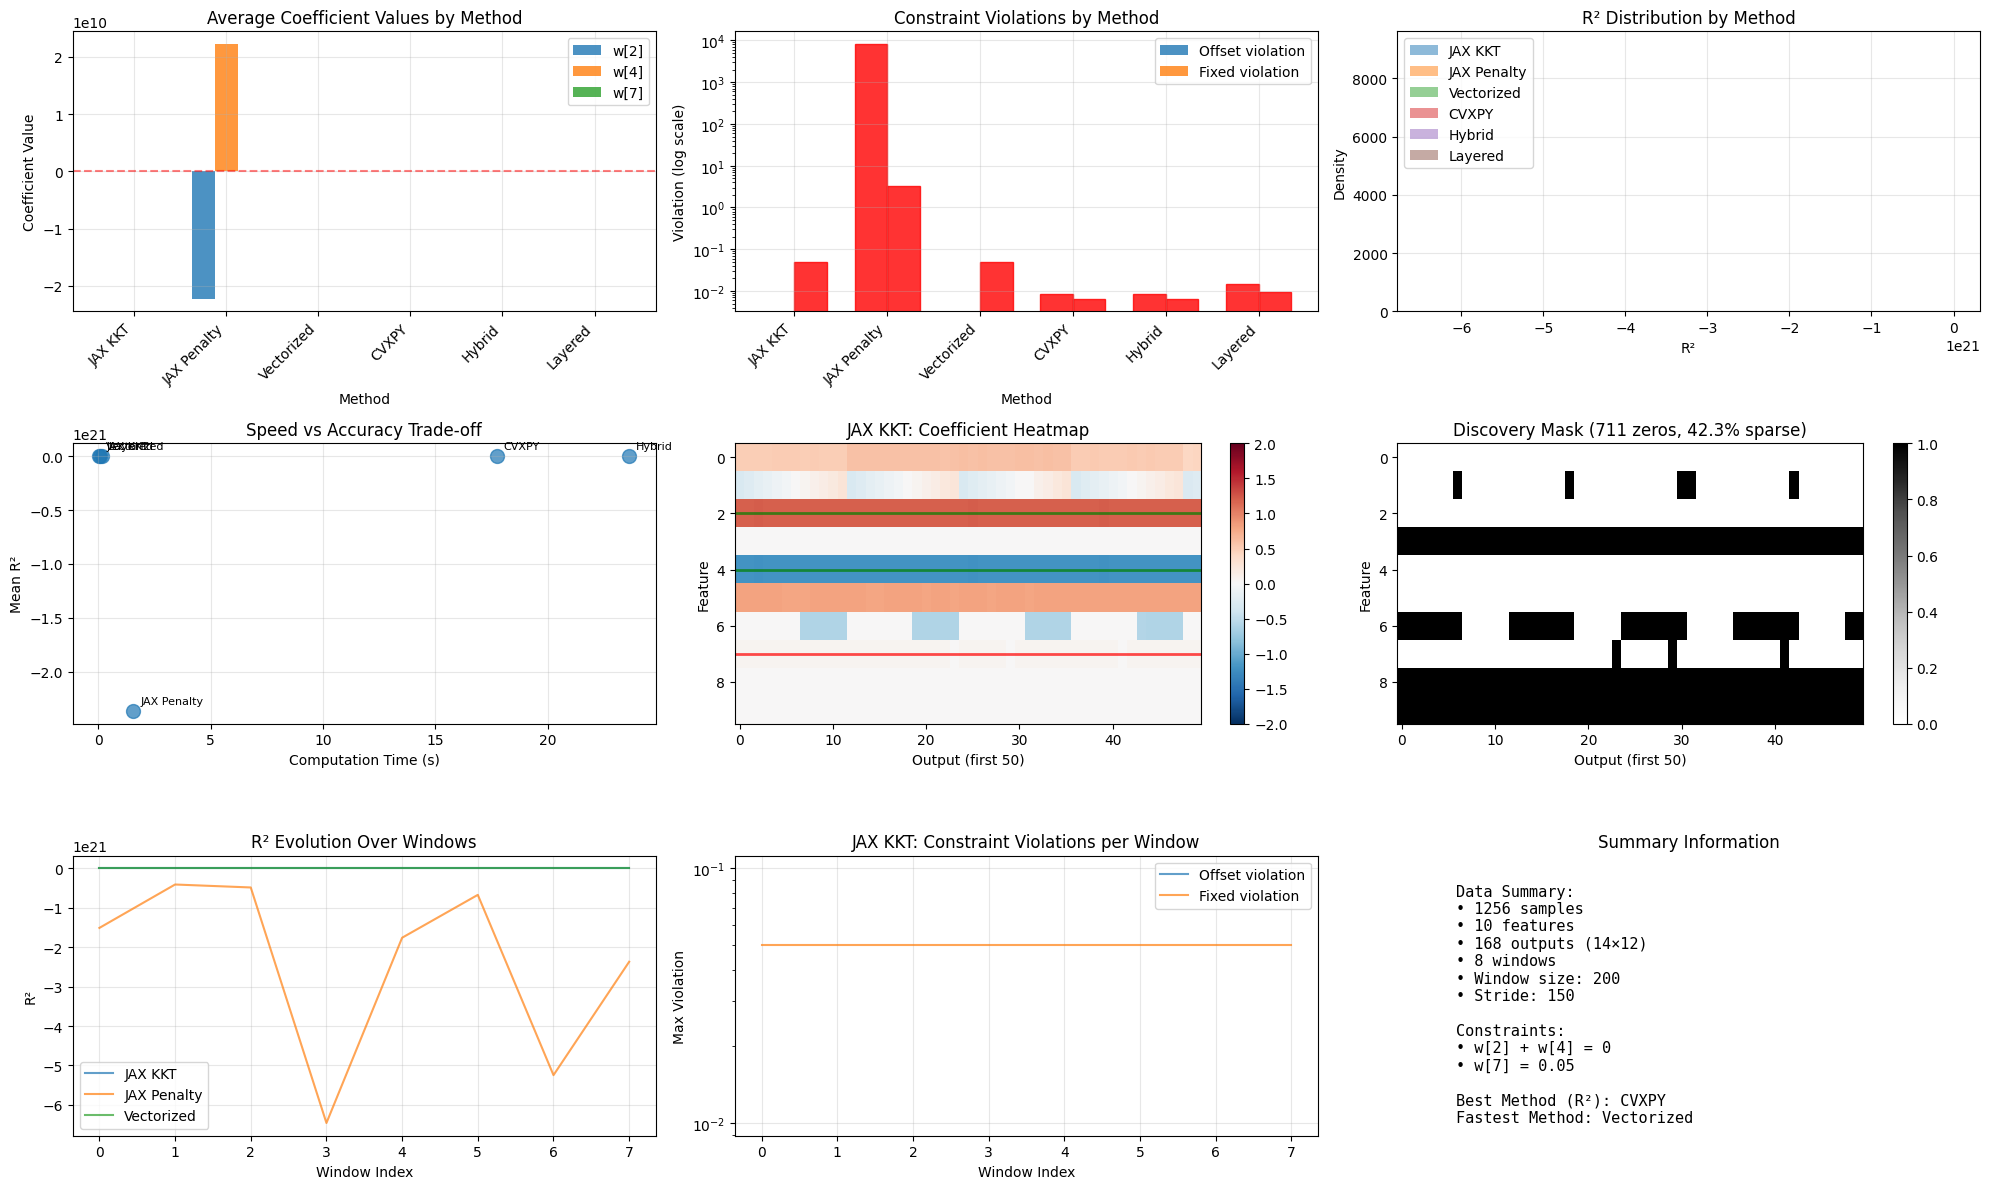

In [35]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import vmap, jit
from functools import partial
import matplotlib.pyplot as plt
import time
import warnings
import pandas as pd

try:
    import cvxpy as cp
    CVXPY_AVAILABLE = True
except ImportError:
    CVXPY_AVAILABLE = False
    warnings.warn("CVXPY not available. Some methods will be disabled.")


def unified_sliding_regression_extended(
    X: jnp.ndarray,
    Y: jnp.ndarray,
    window_size: int,
    stride: int,
    n_countries: int,
    n_tenors: int,
    method: str = 'jax',  # 'jax', 'cvxpy', 'vectorized', 'hybrid'
    layers: list = None,  # For multi-layer regression
    discovery_config: dict = None,
    constraints_config: dict = None,
    cvxpy_config: dict = None
) -> dict:
    """
    Extended unified sliding window regression supporting all methods.

    Args:
        X: Input data (n_samples, n_features)
        Y: Output data (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Stride for sliding window
        n_countries: Number of countries (for reshaping)
        n_tenors: Number of tenors (for reshaping)
        method:
            - 'jax': JAX-based with KKT/penalty methods
            - 'cvxpy': CVXPY for advanced constraints
            - 'vectorized': Fully vectorized operations
            - 'hybrid': JAX discovery + CVXPY regression
        layers: List of layer configs for multi-layer regression
        discovery_config: Configuration for zero discovery
            - 'enabled': Whether to use discovery (default: True)
            - 'consistency_threshold': Threshold for consistency (default: 0.9)
            - 'magnitude_threshold': Absolute magnitude threshold (default: 0.05)
            - 'relative_threshold': Relative magnitude threshold (default: 0.1)
            - 'forced_mask': Pre-specified zero mask
        constraints_config: Configuration for constraints
            - 'method': 'exact' (KKT) or 'penalty' for JAX method
            - 'offset_indices': Tuple (idx1, idx2) or list of tuples
            - 'fixed_constraints': List of (index, value) tuples
            - 'positive_constraints': List of indices that must be >= 0
            - 'negative_constraints': List of indices that must be <= 0
            - 'zero_penalty': Penalty strength for zero constraints
            - 'offset_penalty': Penalty strength for offset constraints
            - 'fixed_penalty': Penalty strength for fixed value constraints
        cvxpy_config: Additional configuration for CVXPY solver
            - 'loss': 'squared' or 'huber'
            - 'delta': Huber loss parameter
            - 'transaction_costs': Cost vector for L1 penalty
            - 'tc_lambda': Transaction cost penalty weight
            - 'dv01_neutral': Whether to enforce sum of coefficients = 1
            - 'post_zero_threshold': Zero out small coefficients after solving

    Returns:
        Dictionary with results including:
            - 'W_all': All window coefficients
            - 'W_avg': Average coefficients
            - 'W_layers': Layer coefficients (if layered)
            - 'r2': R² values
            - 'discovery_mask': Discovered zero pattern
            - 'violations': Constraint violations
            - 'method_used': Actual method used
            - 'computation_time': Time taken
    """

    start_time = time.time()

    # Input validation and setup
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Default configurations
    if discovery_config is None:
        discovery_config = {}
    if constraints_config is None:
        constraints_config = {}
    if cvxpy_config is None:
        cvxpy_config = {}

    # Print setup information
    print(f"\nUnified Sliding Regression Extended")
    print(f"  Method: {method}")
    print(f"  Data: {n_samples} samples, {n_features} features, {n_outputs} outputs")
    print(f"  Windows: {n_windows} (size {window_size}, stride {stride})")
    if layers:
        print(f"  Layers: {len(layers)}")

    # Check method availability
    if method == 'cvxpy' and not CVXPY_AVAILABLE:
        warnings.warn("CVXPY not available, falling back to JAX method")
        method = 'jax'

    # ========== PHASE 1: DISCOVERY ==========
    use_discovery = discovery_config.get('enabled', True)
    discovery_mask = None
    discovery_stats = {}

    if use_discovery:
        print("\nPhase 1: Discovering zero patterns...")

        # Create windows for discovery
        X_wins = create_windows_vectorized(X, window_size, stride)
        Y_wins = create_windows_vectorized(Y, window_size, stride)

        # Run discovery
        discovery_mask, discovery_stats = discover_zero_patterns_unified(
            X_wins, Y_wins,
            consistency_threshold=discovery_config.get('consistency_threshold', 0.9),
            magnitude_threshold=discovery_config.get('magnitude_threshold', 0.05),
            relative_threshold=discovery_config.get('relative_threshold', 0.1)
        )

        # Apply forced mask if provided
        forced_mask = discovery_config.get('forced_mask', None)
        if forced_mask is not None:
            discovery_mask = discovery_mask | forced_mask

        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)
        print(f"  Discovered {n_zeros} zeros ({sparsity:.1f}% sparsity)")

    # ========== PHASE 2: REGRESSION ==========
    print(f"\nPhase 2: Applying {method} regression...")

    # Extract constraint parameters
    constraint_method = constraints_config.get('method', 'exact')
    offset_indices = constraints_config.get('offset_indices', None)
    fixed_constraints = constraints_config.get('fixed_constraints', None)
    positive_constraints = constraints_config.get('positive_constraints', None)
    negative_constraints = constraints_config.get('negative_constraints', None)

    # Handle layers
    if layers is not None and len(layers) > 0:
        results = apply_layered_regression(
            X, Y, window_size, stride, n_layers=len(layers),
            method=method, discovery_mask=discovery_mask,
            constraints_config=constraints_config,
            cvxpy_config=cvxpy_config
        )
    else:
        # Single layer regression
        if method == 'jax':
            results = apply_jax_regression(
                X, Y, window_size, stride,
                constraint_method=constraint_method,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'vectorized':
            results = apply_vectorized_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                constraints_config=constraints_config
            )

        elif method == 'cvxpy':
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )

        elif method == 'hybrid':
            # Use JAX for discovery (already done) and CVXPY for regression
            results = apply_cvxpy_regression(
                X, Y, window_size, stride,
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                cvxpy_config=cvxpy_config
            )
            results['method_used'] = 'hybrid'

        else:
            raise ValueError(f"Unknown method: {method}")

    # ========== POST-PROCESSING ==========

    # Add discovery results
    results['discovery_mask'] = discovery_mask
    results['discovery_stats'] = discovery_stats
    if discovery_mask is not None:
        results['discovery_mask_3d'] = discovery_mask.T.reshape(n_countries, n_tenors, n_features)

    # Check constraint violations
    W_avg = results.get('W_avg', jnp.mean(results['W_all'], axis=0))
    violations = check_all_constraints(
        W_avg, discovery_mask, offset_indices,
        fixed_constraints, positive_constraints, negative_constraints
    )
    results['violations'] = violations

    # Add configuration info
    results['config'] = {
        'window_size': window_size,
        'stride': stride,
        'n_windows': n_windows,
        'method': method,
        'constraint_method': constraint_method,
        'discovery_config': discovery_config,
        'constraints_config': constraints_config,
        'cvxpy_config': cvxpy_config
    }

    # Computation time
    computation_time = time.time() - start_time
    results['computation_time'] = computation_time

    print(f"\nCompleted in {computation_time:.3f} seconds")
    print_summary(results)

    return results


# ============= HELPER FUNCTIONS =============

def create_windows_vectorized(data, window_size, stride):
    """Create all windows at once using advanced indexing."""
    n_samples = data.shape[0]
    n_windows = (n_samples - window_size) // stride + 1

    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    return jnp.array(data[indices])


def solve_ols(X, Y, reg=1e-6):
    """Basic OLS solver."""
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX + reg * jnp.eye(X.shape[1]), XtY)


def discover_zero_patterns_unified(X_wins, Y_wins, consistency_threshold=0.9,
                                  magnitude_threshold=0.05, relative_threshold=0.1):
    """Unified discovery function - fully vectorized."""
    # Solve unconstrained for all windows using vmap
    def solve_window(X_win, Y_win):
        return solve_ols(X_win, Y_win)

    W_all = vmap(solve_window)(X_wins, Y_wins)

    # Analyze patterns
    W_abs = jnp.abs(W_all)
    W_abs_mean = jnp.mean(W_abs, axis=0)
    W_std = jnp.std(W_all, axis=0)

    # Discovery criteria
    small_mask = W_abs_mean < magnitude_threshold

    # Relative threshold
    max_per_output = jnp.max(W_abs_mean, axis=0, keepdims=True)
    relative_mask = W_abs_mean < (relative_threshold * max_per_output)

    # Combine criteria
    candidate_mask = small_mask | relative_mask

    # Check consistency
    n_windows = W_all.shape[0]
    small_counts = jnp.sum(W_abs < magnitude_threshold, axis=0)
    consistency = small_counts / n_windows

    # Final mask
    discovery_mask = candidate_mask & (consistency > consistency_threshold)

    stats = {
        'W_mean': W_abs_mean,
        'W_std': W_std,
        'consistency': consistency,
        'n_zeros': jnp.sum(discovery_mask),
        'sparsity': jnp.mean(discovery_mask)
    }

    return discovery_mask, stats


# ============= JAX REGRESSION =============

def apply_jax_regression(X, Y, window_size, stride, constraint_method='exact',
                        discovery_mask=None, offset_indices=None,
                        fixed_constraints=None, constraints_config=None):
    """Apply regression using JAX methods."""

    if constraint_method == 'exact':
        W_all = apply_kkt_constraints_vectorized(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints
        )
    else:  # penalty
        W_all = apply_penalty_constraints_vectorized(
            X, Y, window_size, stride,
            discovery_mask=discovery_mask,
            offset_indices=offset_indices,
            fixed_constraints=fixed_constraints,
            zero_penalty=constraints_config.get('zero_penalty', 1e12),
            offset_penalty=constraints_config.get('offset_penalty', 1e10),
            fixed_penalty=constraints_config.get('fixed_penalty', 1e10)
        )

    # Compute R²
    W_avg = jnp.mean(W_all, axis=0)
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Vectorized R² computation
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2_values = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': W_avg,
        'r2': [r2_values],
        'method_used': f'jax_{constraint_method}'
    }


# ============= KKT CONSTRAINTS (VECTORIZED) =============

def apply_kkt_constraints_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                   offset_indices=None, fixed_constraints=None):
    """Apply constraints using KKT (exact) method - fully vectorized."""
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    n_windows = X_wins.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]

    # Apply constraints based on what's provided
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_kkt_vectorized(
            X_wins, Y_wins, fixed_constraints[0], offset_indices, discovery_mask
        )
    elif fixed_constraints:
        W_all = apply_fixed_kkt_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    elif offset_indices:
        W_all = apply_offset_kkt_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    else:
        W_all = solve_with_zeros_vectorized(X_wins, Y_wins, discovery_mask)

    return W_all


def apply_offset_kkt_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None):
    """Apply offset constraint using KKT - vectorized."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system by eliminating idx2
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint: replace column idx1 with (col_idx1 - col_idx2)
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve reduced system
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None)

    # Apply zero constraints if needed
    if zero_mask is not None:
        # Apply penalties to enforce zeros in reduced space
        for j in range(n_outputs):
            reduced_zero_mask = zero_mask[keep_indices, j]
            if jnp.any(reduced_zero_mask):
                penalty_diag = jnp.where(reduced_zero_mask, 1e12, 0.0)
                XtX = jnp.einsum('wij,wik->wjk', X_reduced, X_reduced)
                XtY = jnp.einsum('wij,wi->wj', X_reduced, Y_wins[:, :, j])
                XtX_pen = XtX + jnp.diag(penalty_diag)[None, :, :] + 1e-6 * jnp.eye(len(keep_indices))[None, :, :]
                W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY)
                W_reduced = W_reduced.at[:, :, j].set(W_j)

    # Reconstruct full solution
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    # Set w[idx2] = -w[idx1]
    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    return W_all


def apply_fixed_kkt_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None):
    """Apply fixed value constraint using KKT - vectorized."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    feat_mask = np.ones(n_features, dtype=bool)
    feat_mask[fixed_idx] = False
    X_reduced = X_wins[:, :, feat_mask]

    # ✅ FIX: slice zero_mask along FEATURES (first axis), ensure boolean dtype
    if zero_mask is not None:
        reduced_zero_mask = jnp.asarray(zero_mask, dtype=bool)[feat_mask, :]
    else:
        reduced_zero_mask = None

    # Solve on reduced system (honors reduced zero mask per-output)
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, reduced_zero_mask)

    # Reconstruct full solution
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    return W_all


def apply_all_constraints_kkt_vectorized(X_wins, Y_wins, fixed_constraint,
                                       offset_indices, zero_mask=None):
    """Apply all constraints using KKT - vectorized."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Handle different cases
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    if idx1 == fixed_idx:
        # w[idx2] = -fixed_val
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None)
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            elif i == idx2:
                W_all = W_all.at[:, i, :].set(-fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    elif idx2 == fixed_idx:
        # w[idx1] = -fixed_val
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None)
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            elif i == idx1:
                W_all = W_all.at[:, i, :].set(-fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    else:
        # Both constraints active, need second reduction
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1

        # Final reconstruction
        j = 0
        for i in range(n_features):
            if i == fixed_idx:
                W_all = W_all.at[:, i, :].set(fixed_val)
            else:
                W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
                j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        # Post-process to enforce zeros (approximate)
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def solve_with_zeros_vectorized(X_wins, Y_wins, zero_mask):
    """Solve with only zero constraints - vectorized."""
    if zero_mask is None:
        return solve_all_windows_outputs_vectorized(X_wins, Y_wins, None)

    n_windows = X_wins.shape[0]
    n_features = X_wins.shape[2]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    # Compute X'X and X'Y for all windows
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    for j in range(n_outputs):
        penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
        penalty_matrix = jnp.diag(penalty_diag) + 1e-6 * jnp.eye(n_features)
        XtX_pen = XtX + penalty_matrix[None, :, :]
        W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY[:, :, j])
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= PENALTY METHOD (VECTORIZED) =============

def apply_penalty_constraints_vectorized(X, Y, window_size, stride, discovery_mask=None,
                                       offset_indices=None, fixed_constraints=None,
                                       zero_penalty=1e12, offset_penalty=1e10,
                                       fixed_penalty=1e10, reg=1e-6):
    """
    Fully vectorized penalty method that processes all windows and outputs simultaneously.
    """
    # Create all windows at once
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Create windows using advanced indexing
    indices = np.arange(n_windows)[:, None] * stride + np.arange(window_size)[None, :]
    X_wins = X[indices]  # Shape: (n_windows, window_size, n_features)
    Y_wins = Y[indices]  # Shape: (n_windows, window_size, n_outputs)

    # Compute X'X and X'Y for all windows at once
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)  # Shape: (n_windows, n_features, n_features)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)  # Shape: (n_windows, n_features, n_outputs)

    # Initialize base penalty matrix (same for all windows)
    I = jnp.eye(n_features)
    base_penalty = reg * I

    # === OFFSET CONSTRAINT PENALTY ===
    offset_penalty_matrix = jnp.zeros((n_features, n_features))
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            # Handle multiple offset constraints
            for idx1, idx2 in offset_indices:
                offset_matrix = jnp.zeros((n_features, n_features))
                offset_matrix = offset_matrix.at[idx1, idx1].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx1, idx2].add(offset_penalty)
                offset_matrix = offset_matrix.at[idx2, idx1].add(offset_penalty)
                offset_penalty_matrix = offset_penalty_matrix + offset_matrix
        else:
            idx1, idx2 = offset_indices
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx1].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx1, idx2].add(offset_penalty)
            offset_penalty_matrix = offset_penalty_matrix.at[idx2, idx1].add(offset_penalty)

    # === SOLVE FOR ALL OUTPUTS ===
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for j in range(n_outputs):
        # Build penalty matrix for this output
        penalty_matrix = base_penalty + offset_penalty_matrix

        # === ZERO CONSTRAINT PENALTY ===
        if discovery_mask is not None:
            zero_diag = jnp.where(discovery_mask[:, j], zero_penalty, 0.0)
            penalty_matrix = penalty_matrix + jnp.diag(zero_diag)

        # === FIXED VALUE CONSTRAINT ===
        XtY_j = XtY[:, :, j].copy()  # Shape: (n_windows, n_features)

        if fixed_constraints is not None:
            for fixed_idx, fixed_val in fixed_constraints:
                # Add penalty to diagonal
                penalty_matrix = penalty_matrix.at[fixed_idx, fixed_idx].add(fixed_penalty)
                # Modify linear term for all windows
                XtY_j = XtY_j.at[:, fixed_idx].add(fixed_penalty * fixed_val)

        # Add penalty matrix to all windows (broadcasting)
        XtX_pen = XtX + penalty_matrix[None, :, :]  # Shape: (n_windows, n_features, n_features)

        # Solve for all windows at once using vmap
        W_j = vmap(jnp.linalg.solve)(XtX_pen, XtY_j)  # Shape: (n_windows, n_features)
        W_all = W_all.at[:, :, j].set(W_j)

    return W_all


# ============= VECTORIZED REGRESSION =============

def apply_vectorized_regression(X, Y, window_size, stride, discovery_mask=None,
                              offset_indices=None, fixed_constraints=None,
                              constraints_config=None):
    """Apply fully vectorized regression."""
    # Create all windows at once
    X_wins = create_windows_vectorized(X, window_size, stride)
    Y_wins = create_windows_vectorized(Y, window_size, stride)

    # Apply constraints
    if fixed_constraints and offset_indices:
        W_all = apply_all_constraints_vectorized(
            X_wins, Y_wins,
            fixed_constraints[0], offset_indices,
            discovery_mask
        )
    elif offset_indices:
        W_all = apply_offset_vectorized(X_wins, Y_wins, offset_indices, discovery_mask)
    elif fixed_constraints:
        W_all = apply_fixed_vectorized(X_wins, Y_wins, fixed_constraints[0], discovery_mask)
    else:
        W_all = solve_all_windows_outputs_vectorized(X_wins, Y_wins, discovery_mask)

    # Compute R²
    Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_all)
    ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
    ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    return {
        'W_all': W_all,
        'W_avg': jnp.mean(W_all, axis=0),
        'r2': [r2],
        'method_used': 'vectorized'
    }


def solve_all_windows_outputs_vectorized(X_wins, Y_wins, zero_mask=None, reg=1e-6):
    """Vectorized OLS for all windows and outputs."""
    XtX = jnp.einsum('wij,wik->wjk', X_wins, X_wins)
    XtY = jnp.einsum('wij,wik->wjk', X_wins, Y_wins)

    n_features = X_wins.shape[2]
    I = jnp.eye(n_features)
    XtX_reg = XtX + reg * I[None, :, :]

    if zero_mask is not None:
        # Apply zero constraints
        n_windows = X_wins.shape[0]
        n_outputs = Y_wins.shape[2]
        W_all = jnp.zeros((n_windows, n_features, n_outputs))

        for j in range(n_outputs):
            penalty_diag = jnp.where(zero_mask[:, j], 1e12, 0.0)
            penalty_matrix = jnp.diag(penalty_diag)
            XtX_pen = XtX_reg + penalty_matrix[None, :, :]
            W_j = vmap(lambda A, b: jnp.linalg.solve(A, b))(XtX_pen, XtY[:, :, j])
            W_all = W_all.at[:, :, j].set(W_j)

        return W_all
    else:
        return vmap(lambda A, B: jnp.linalg.solve(A, B))(XtX_reg, XtY)


def apply_offset_vectorized(X_wins, Y_wins, offset_indices, zero_mask=None, reg=1e-6):
    """Vectorized offset constraint."""
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Create reduced system
    keep_mask = np.ones(n_features, dtype=bool)
    keep_mask[idx2] = False
    keep_indices = np.where(keep_mask)[0]

    X_reduced = X_wins[:, :, keep_mask]

    # Find position of idx1 in reduced system
    idx1_new = np.sum(keep_indices < idx1)

    # Adjust for constraint
    X_reduced = X_reduced.at[:, :, idx1_new].set(
        X_wins[:, :, idx1] - X_wins[:, :, idx2]
    )

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_wins, None, reg)

    # Reconstruct
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    for i, orig_idx in enumerate(keep_indices):
        W_all = W_all.at[:, orig_idx, :].set(W_reduced[:, i, :])

    W_all = W_all.at[:, idx2, :].set(-W_reduced[:, idx1_new, :])

    # Apply zero constraints if needed
    if zero_mask is not None:
        # This is approximate - we just zero out the masked coefficients
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_fixed_vectorized(X_wins, Y_wins, fixed_constraint, zero_mask=None, reg=1e-6):
    """Vectorized fixed value constraint."""
    fixed_idx, fixed_val = fixed_constraint

    # Adjust Y
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    n_features = X_wins.shape[2]
    mask = np.ones(n_features, dtype=bool)
    mask[fixed_idx] = False
    X_reduced = X_wins[:, :, mask]

    # Solve
    W_reduced = solve_all_windows_outputs_vectorized(X_reduced, Y_adjusted, None, reg)

    # Reconstruct
    n_windows = X_wins.shape[0]
    n_outputs = Y_wins.shape[2]
    W_all = jnp.zeros((n_windows, n_features, n_outputs))

    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_reduced[:, j, :])
            j += 1

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


def apply_all_constraints_vectorized(X_wins, Y_wins, fixed_constraint,
                                   offset_indices, zero_mask=None, reg=1e-6):
    """Apply all constraints in vectorized manner."""
    fixed_idx, fixed_val = fixed_constraint
    if isinstance(offset_indices, list):
        offset_indices = offset_indices[0]
    idx1, idx2 = offset_indices

    n_windows, window_size, n_features = X_wins.shape
    n_outputs = Y_wins.shape[2]

    # Adjust Y for fixed constraint
    Y_adjusted = Y_wins - fixed_val * X_wins[:, :, fixed_idx:fixed_idx+1]

    # Remove fixed variable
    mask1 = np.ones(n_features, dtype=bool)
    mask1[fixed_idx] = False
    X_red1 = X_wins[:, :, mask1]

    # Adjust indices
    idx1_red = idx1 - (1 if fixed_idx < idx1 else 0)
    idx2_red = idx2 - (1 if fixed_idx < idx2 else 0)

    # Apply offset constraint if valid
    if idx1 != fixed_idx and idx2 != fixed_idx:
        mask2 = np.ones(n_features - 1, dtype=bool)
        mask2[idx2_red] = False
        X_red2 = X_red1[:, :, mask2]

        idx1_red2 = idx1_red - (1 if idx2_red < idx1_red else 0)

        X_red2 = X_red2.at[:, :, idx1_red2].set(
            X_red1[:, :, idx1_red] - X_red1[:, :, idx2_red]
        )

        # Solve
        W_red2 = solve_all_windows_outputs_vectorized(X_red2, Y_adjusted, None, reg)

        # Reconstruct to singly-reduced
        W_red1 = jnp.zeros((n_windows, n_features - 1, n_outputs))
        j = 0
        for i in range(n_features - 1):
            if i == idx2_red:
                W_red1 = W_red1.at[:, i, :].set(-W_red2[:, idx1_red2, :])
            else:
                W_red1 = W_red1.at[:, i, :].set(W_red2[:, j, :])
                j += 1
    else:
        # Special cases
        W_red1 = solve_all_windows_outputs_vectorized(X_red1, Y_adjusted, None, reg)

    # Final reconstruction
    W_all = jnp.zeros((n_windows, n_features, n_outputs))
    j = 0
    for i in range(n_features):
        if i == fixed_idx:
            W_all = W_all.at[:, i, :].set(fixed_val)
        else:
            W_all = W_all.at[:, i, :].set(W_red1[:, j, :])
            j += 1

    # Handle special offset cases
    if idx1 == fixed_idx:
        W_all = W_all.at[:, idx2, :].set(-fixed_val)
    elif idx2 == fixed_idx:
        W_all = W_all.at[:, idx1, :].set(-fixed_val)

    # Apply zero constraints if needed
    if zero_mask is not None:
        W_all = W_all * (1 - zero_mask[None, :, :])

    return W_all


# ============= CVXPY REGRESSION =============

if CVXPY_AVAILABLE:
    def apply_cvxpy_regression(X, Y, window_size, stride, discovery_mask=None,
                             offset_indices=None, fixed_constraints=None,
                             positive_constraints=None, negative_constraints=None,
                             cvxpy_config=None):
        """Apply CVXPY regression."""
        if cvxpy_config is None:
            cvxpy_config = {}

        X_wins = create_windows_vectorized(X, window_size, stride)
        Y_wins = create_windows_vectorized(Y, window_size, stride)

        W_all = []

        for i in range(len(X_wins)):
            W = solve_cvxpy_window(
                np.array(X_wins[i]), np.array(Y_wins[i]),
                discovery_mask=discovery_mask,
                offset_indices=offset_indices,
                fixed_constraints=fixed_constraints,
                positive_constraints=positive_constraints,
                negative_constraints=negative_constraints,
                **cvxpy_config
            )
            W_all.append(jnp.array(W))

        W_all = jnp.stack(W_all)

        # Compute R²
        r2_values = []
        for i in range(len(W_all)):
            Y_pred = X_wins[i] @ W_all[i]
            ss_res = jnp.sum((Y_wins[i] - Y_pred)**2)
            ss_tot = jnp.sum((Y_wins[i] - jnp.mean(Y_wins[i]))**2)
            r2 = 1 - ss_res / (ss_tot + 1e-8)
            r2_values.append(r2)

        return {
            'W_all': W_all,
            'W_avg': jnp.mean(W_all, axis=0),
            'r2': [jnp.array(r2_values)],
            'method_used': 'cvxpy'
        }


    def solve_cvxpy_window(X_win, Y_win, discovery_mask=None, offset_indices=None,
                         fixed_constraints=None, positive_constraints=None,
                         negative_constraints=None, loss='squared',
                         huber_delta=1.0, transaction_costs=None,
                         tc_lambda=0.0, dv01_neutral=False,
                         post_zero_threshold=None):
        """Solve single window using CVXPY."""
        n_features = X_win.shape[1]
        n_outputs = Y_win.shape[1]

        W = np.zeros((n_features, n_outputs))

        for j in range(n_outputs):
            # Define variables
            w = cp.Variable(n_features)

            # Objective
            if loss == 'squared':
                objective = cp.Minimize(cp.sum_squares(X_win @ w - Y_win[:, j]))
            else:  # huber
                objective = cp.Minimize(cp.sum(cp.huber(X_win @ w - Y_win[:, j], M=huber_delta)))

            # Add transaction costs if specified
            if transaction_costs is not None and tc_lambda > 0:
                objective = cp.Minimize(objective.expr + tc_lambda * cp.sum(cp.multiply(transaction_costs, cp.abs(w))))

            # Constraints
            constraints = []

            # Offset constraints
            if offset_indices is not None:
                if isinstance(offset_indices, list):
                    for idx1, idx2 in offset_indices:
                        constraints.append(w[idx1] + w[idx2] == 0)
                else:
                    idx1, idx2 = offset_indices
                    constraints.append(w[idx1] + w[idx2] == 0)

            # Fixed constraints
            if fixed_constraints is not None:
                for fixed_idx, fixed_val in fixed_constraints:
                    constraints.append(w[fixed_idx] == fixed_val)

            # Sign constraints
            if positive_constraints is not None:
                for idx in positive_constraints:
                    constraints.append(w[idx] >= 0)

            if negative_constraints is not None:
                for idx in negative_constraints:
                    constraints.append(w[idx] <= 0)

            # Zero constraints from discovery
            if discovery_mask is not None:
                zero_indices = np.where(discovery_mask[:, j])[0]
                for idx in zero_indices:
                    constraints.append(w[idx] == 0)

            # DV01 neutral
            if dv01_neutral:
                constraints.append(cp.sum(w) == 1.0)

            # Solve
            prob = cp.Problem(objective, constraints)

            try:
                # Try different solvers
                for solver in [cp.OSQP, cp.ECOS, cp.SCS]:
                    try:
                        prob.solve(solver=solver, verbose=False)
                        if prob.status in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
                            break
                    except:
                        continue

                if w.value is not None:
                    w_sol = w.value

                    # Post-threshold if specified
                    if post_zero_threshold is not None:
                        w_sol[np.abs(w_sol) < post_zero_threshold] = 0

                    W[:, j] = w_sol
                else:
                    # Fallback to basic OLS
                    W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()
            except:
                # Fallback
                W[:, j] = solve_ols(X_win, Y_win[:, j:j+1]).flatten()

        return W
else:
    def apply_cvxpy_regression(*args, **kwargs):
        raise ImportError("CVXPY not available")


# ============= LAYERED REGRESSION =============

def apply_layered_regression(X, Y, window_size, stride, n_layers=3,
                           method='jax', discovery_mask=None,
                           constraints_config=None, cvxpy_config=None):
    """Apply layered regression."""
    n_samples = X.shape[0]

    W_layers = []
    r2_layers = []
    residual = Y.copy()

    for layer in range(n_layers):
        print(f"  Layer {layer + 1}/{n_layers}...")

        # Apply constraints only in first layer
        if layer == 0:
            layer_config = constraints_config
            layer_discovery = discovery_mask
        else:
            # No constraints in subsequent layers
            layer_config = {}
            layer_discovery = None

        # Run regression for this layer
        if method in ['jax', 'vectorized']:
            if layer == 0:
                # Use specified method with constraints
                sub_method = 'jax' if method == 'jax' else 'vectorized'
                results = unified_sliding_regression_extended(
                    X, residual, window_size, stride, 1, 1,
                    method=sub_method,
                    discovery_config={'enabled': False, 'forced_mask': layer_discovery},
                    constraints_config=layer_config
                )
            else:
                # Simple regression for subsequent layers
                X_wins = create_windows_vectorized(X, window_size, stride)
                Y_wins = create_windows_vectorized(residual, window_size, stride)
                W_layer = vmap(solve_ols)(X_wins, Y_wins)

                # Compute R²
                Y_preds = jnp.einsum('wij,wjk->wik', X_wins, W_layer)
                ss_res = jnp.sum((Y_wins - Y_preds)**2, axis=(1, 2))
                ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True))**2, axis=(1, 2))
                r2_values = 1 - ss_res / (ss_tot + 1e-8)

                results = {
                    'W_all': W_layer,
                    'r2': [r2_values]
                }

        elif method == 'cvxpy' and CVXPY_AVAILABLE:
            if layer == 0:
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    discovery_mask=layer_discovery,
                    offset_indices=layer_config.get('offset_indices'),
                    fixed_constraints=layer_config.get('fixed_constraints'),
                    positive_constraints=layer_config.get('positive_constraints'),
                    negative_constraints=layer_config.get('negative_constraints'),
                    cvxpy_config=cvxpy_config
                )
            else:
                # Simple CVXPY regression
                results = apply_cvxpy_regression(
                    X, residual, window_size, stride,
                    cvxpy_config={'loss': cvxpy_config.get('loss', 'squared')}
                )

        else:
            raise ValueError(f"Invalid method for layered regression: {method}")

        W_layer = results['W_all']
        r2_layer = results['r2'][0]

        W_layers.append(W_layer)
        r2_layers.append(r2_layer)

        # Update residual
        predictions = jnp.zeros_like(residual)
        counts = jnp.zeros((n_samples, 1))

        for i in range(len(W_layer)):
            start = i * stride
            end = start + window_size

            pred_window = X[start:end] @ W_layer[i]
            predictions = predictions.at[start:end].add(pred_window)
            counts = counts.at[start:end].add(1.0)

        predictions = predictions / jnp.maximum(counts, 1.0)
        residual = residual - predictions

        print(f"    Mean R²: {jnp.mean(r2_layer):.4f}")

    # Compute total coefficients
    W_total = jnp.zeros((X.shape[1], Y.shape[1]))
    for W_layer in W_layers:
        W_total += jnp.mean(W_layer, axis=0)

    return {
        'W_all': W_layers[0],  # First layer for compatibility
        'W_avg': W_total,
        'W_layers': W_layers,
        'r2': r2_layers,
        'method_used': f'{method}_layered'
    }


# ============= CONSTRAINT CHECKING =============

def check_all_constraints(W, discovery_mask, offset_indices, fixed_constraints,
                        positive_constraints, negative_constraints):
    """Check all constraint violations."""
    violations = {}

    # Zero violations
    if discovery_mask is not None:
        zero_violations = jnp.abs(W * discovery_mask)
        violations['zero_max'] = jnp.max(zero_violations)
        violations['zero_mean'] = jnp.mean(zero_violations)
        violations['zero_count'] = jnp.sum(zero_violations > 1e-6)

    # Offset violations
    if offset_indices is not None:
        if isinstance(offset_indices, list):
            offset_viols = []
            for idx1, idx2 in offset_indices:
                offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
                offset_viols.append(jnp.max(offset_viol))
            violations['offset_max'] = max(offset_viols)
            violations['offset_mean'] = np.mean(offset_viols)
        else:
            idx1, idx2 = offset_indices
            offset_viol = jnp.abs(W[idx1, :] + W[idx2, :])
            violations['offset_max'] = jnp.max(offset_viol)
            violations['offset_mean'] = jnp.mean(offset_viol)

    # Fixed violations
    if fixed_constraints is not None:
        fixed_viols = []
        for fixed_idx, fixed_val in fixed_constraints:
            fixed_viol = jnp.abs(W[fixed_idx, :] - fixed_val)
            fixed_viols.append(jnp.max(fixed_viol))
        violations['fixed_max'] = max(fixed_viols)
        violations['fixed_mean'] = np.mean(fixed_viols)

    # Sign violations
    if positive_constraints is not None:
        pos_viols = []
        for idx in positive_constraints:
            if idx < W.shape[0]:
                pos_viol = jnp.maximum(-W[idx, :], 0)
                pos_viols.append(jnp.max(pos_viol))
        if pos_viols:
            violations['positive_max'] = max(pos_viols)

    if negative_constraints is not None:
        neg_viols = []
        for idx in negative_constraints:
            if idx < W.shape[0]:
                neg_viol = jnp.maximum(W[idx, :], 0)
                neg_viols.append(jnp.max(neg_viol))
        if neg_viols:
            violations['negative_max'] = max(neg_viols)

    return violations


def print_summary(results):
    """Print summary of results."""
    violations = results.get('violations', {})

    if 'zero_max' in violations:
        print(f"  Zero violations: max={violations['zero_max']:.2e}, "
              f"count={violations.get('zero_count', 0)}")

    if 'offset_max' in violations:
        print(f"  Offset violations: max={violations['offset_max']:.2e}")

    if 'fixed_max' in violations:
        print(f"  Fixed violations: max={violations['fixed_max']:.2e}")

    if 'positive_max' in violations:
        print(f"  Positive constraint violations: max={violations['positive_max']:.2e}")

    if 'negative_max' in violations:
        print(f"  Negative constraint violations: max={violations['negative_max']:.2e}")

    # R² summary
    if 'r2' in results and results['r2']:
        if len(results['r2']) == 1:
            print(f"  Mean R²: {jnp.mean(results['r2'][0]):.4f}")
        else:
            print(f"  R² by layer:")
            for i, r2 in enumerate(results['r2']):
                print(f"    Layer {i+1}: {jnp.mean(r2):.4f}")


# ============= COMPREHENSIVE EXAMPLE =============

def run_comprehensive_example():
    """
    Comprehensive example with:
    - 1256 rows (samples)
    - 14 countries
    - 12 tenors
    - 200-row windows with 150 stride
    - Constraints: w[2] = -w[4], w[7] = 0.05
    """

    print("="*80)
    print("UNIFIED SLIDING REGRESSION EXAMPLE - ALL METHODS")
    print("="*80)

    # ============= DATA GENERATION =============
    print("\n1. GENERATING DATA")
    print("-"*40)

    n_samples = 1256
    n_countries = 14
    n_tenors = 12
    n_outputs = n_countries * n_tenors  # 168 outputs
    n_features = 10  # Number of input features
    window_size = 200
    stride = 150

    print(f"Data dimensions:")
    print(f"  Samples: {n_samples}")
    print(f"  Features: {n_features}")
    print(f"  Outputs: {n_outputs} ({n_countries} countries × {n_tenors} tenors)")
    print(f"  Window size: {window_size}")
    print(f"  Stride: {stride}")

    # Calculate number of windows
    n_windows = (n_samples - window_size) // stride + 1
    print(f"  Number of windows: {n_windows}")

    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    key_X, key_noise = jax.random.split(key)

    # Create input data
    X = jax.random.normal(key_X, (n_samples, n_features))

    # Create true coefficients with the specified constraints
    W_true = jnp.zeros((n_features, n_outputs))

    # Set some base patterns
    for j in range(n_outputs):
        country_idx = j // n_tenors
        tenor_idx = j % n_tenors

        # Basic patterns
        W_true = W_true.at[0, j].set(0.5 + 0.1 * np.sin(country_idx))
        W_true = W_true.at[1, j].set(-0.3 + 0.05 * tenor_idx)

        # Apply constraints:
        # w[2] = -w[4] (offsetting)
        W_true = W_true.at[2, j].set(1.2)
        W_true = W_true.at[4, j].set(-1.2)

        # w[7] = 0.05 (fixed value)
        W_true = W_true.at[7, j].set(0.05)

        # Some other patterns
        if country_idx < 7:
            W_true = W_true.at[5, j].set(0.8)
        if tenor_idx > 6:
            W_true = W_true.at[6, j].set(-0.6)

    # Generate output data
    noise_level = 0.1
    Y = X @ W_true + noise_level * jax.random.normal(key_noise, (n_samples, n_outputs))

    print(f"\nTrue coefficient statistics:")
    print(f"  w[2] mean: {jnp.mean(W_true[2, :]):.4f}")
    print(f"  w[4] mean: {jnp.mean(W_true[4, :]):.4f}")
    print(f"  w[7] mean: {jnp.mean(W_true[7, :]):.4f}")
    print(f"  w[2] + w[4] check: {jnp.max(jnp.abs(W_true[2, :] + W_true[4, :])):.2e}")

    # ============= CONSTRAINT CONFIGURATION =============
    print("\n2. CONSTRAINT CONFIGURATION")
    print("-"*40)

    # Define constraints
    offset_indices = (2, 4)  # w[2] + w[4] = 0
    fixed_constraints = [(7, 0.05)]  # w[7] = 0.05

    print(f"Constraints:")
    print(f"  Offset constraint: w[{offset_indices[0]}] + w[{offset_indices[1]}] = 0")
    print(f"  Fixed constraint: w[{fixed_constraints[0][0]}] = {fixed_constraints[0][1]}")

    # Discovery configuration
    discovery_config = {
        'enabled': True,
        'consistency_threshold': 0.85,
        'magnitude_threshold': 0.05,
        'relative_threshold': 0.1
    }

    # ============= RUN ALL METHODS =============
    print("\n3. RUNNING ALL METHODS")
    print("-"*40)

    all_results = {}

    # Method 1: JAX with KKT (Exact Constraints)
    print("\n[Method 1/6] JAX with KKT (Exact Constraints)")
    print("  This method uses Karush-Kuhn-Tucker conditions for exact constraint satisfaction")

    results_jax_kkt = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',  # KKT method
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['JAX KKT'] = results_jax_kkt

    # Method 2: JAX with Penalty Method
    print("\n[Method 2/6] JAX with Penalty Method")
    print("  This method uses high penalties to enforce constraints approximately")

    results_jax_penalty = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        discovery_config=discovery_config,
        constraints_config={
            'method': 'penalty',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints,
            'zero_penalty': 1e12,
            'offset_penalty': 1e10,
            'fixed_penalty': 1e10
        }
    )
    all_results['JAX Penalty'] = results_jax_penalty

    # Method 3: Fully Vectorized
    print("\n[Method 3/6] Fully Vectorized Method")
    print("  This method processes all windows simultaneously for maximum speed")

    results_vectorized = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='vectorized',
        discovery_config=discovery_config,
        constraints_config={
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Vectorized'] = results_vectorized

    # Method 4: CVXPY
    if CVXPY_AVAILABLE:
        print("\n[Method 4/6] CVXPY Method")
        print("  This method uses convex optimization with advanced constraint handling")

        results_cvxpy = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='cvxpy',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'squared',
                'post_zero_threshold': 1e-6
            }
        )
        all_results['CVXPY'] = results_cvxpy
    else:
        print("\n[Method 4/6] CVXPY - SKIPPED (not installed)")

    # Method 5: Hybrid (JAX Discovery + CVXPY Regression)
    if CVXPY_AVAILABLE:
        print("\n[Method 5/6] Hybrid Method (JAX Discovery + CVXPY Regression)")
        print("  This method combines JAX's fast discovery with CVXPY's flexible regression")

        results_hybrid = unified_sliding_regression_extended(
            X, Y,
            window_size=window_size,
            stride=stride,
            n_countries=n_countries,
            n_tenors=n_tenors,
            method='hybrid',
            discovery_config=discovery_config,
            constraints_config={
                'offset_indices': offset_indices,
                'fixed_constraints': fixed_constraints
            },
            cvxpy_config={
                'loss': 'huber',
                'huber_delta': 1.0
            }
        )
        all_results['Hybrid'] = results_hybrid
    else:
        print("\n[Method 5/6] Hybrid - SKIPPED (CVXPY not installed)")

    # Method 6: Layered Regression
    print("\n[Method 6/6] Layered Regression (3 layers)")
    print("  This method applies regression in multiple layers to capture complex patterns")

    results_layered = unified_sliding_regression_extended(
        X, Y,
        window_size=window_size,
        stride=stride,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method='jax',
        layers=[{}, {}, {}],  # 3 layers
        discovery_config=discovery_config,
        constraints_config={
            'method': 'exact',
            'offset_indices': offset_indices,
            'fixed_constraints': fixed_constraints
        }
    )
    all_results['Layered'] = results_layered

    # ============= RESULTS COMPARISON =============
    print("\n4. RESULTS COMPARISON")
    print("-"*40)

    # Create comparison table
    comparison_data = []
    for method_name, results in all_results.items():
        W_avg = results['W_avg']
        violations = results['violations']

        # Check constraint satisfaction
        offset_check = float(jnp.abs(W_avg[2, :] + W_avg[4, :]).max())
        fixed_check = float(jnp.abs(W_avg[7, :] - 0.05).max())

        # Get R² statistics
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_mean = float(jnp.mean(results['r2'][0]))
                r2_std = float(jnp.std(results['r2'][0]))
            else:
                # For layered regression, use last layer
                r2_mean = float(jnp.mean(results['r2'][-1]))
                r2_std = float(jnp.std(results['r2'][-1]))
        else:
            r2_mean = r2_std = 0.0

        comparison_data.append({
            'Method': method_name,
            'Time (s)': results['computation_time'],
            'Mean R²': r2_mean,
            'Std R²': r2_std,
            'w[2] mean': float(jnp.mean(W_avg[2, :])),
            'w[4] mean': float(jnp.mean(W_avg[4, :])),
            'w[7] mean': float(jnp.mean(W_avg[7, :])),
            'Offset Viol': offset_check,
            'Fixed Viol': fixed_check,
            'Zero Viol': violations.get('zero_max', 0)
        })

    # Display comparison
    df = pd.DataFrame(comparison_data)

    print("\nMethod Comparison Table:")
    print(df.to_string(index=False, float_format='%.6f'))

    # Save comparison
    df.to_csv('method_comparison_comprehensive.csv', index=False)
    print("\nComparison saved to 'method_comparison_comprehensive.csv'")

    # ============= VISUALIZATION =============
    print("\n5. VISUALIZATION")
    print("-"*40)

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))

    # Plot 1: Coefficient values for each method
    ax1 = plt.subplot(3, 3, 1)
    method_names = list(all_results.keys())
    positions = np.arange(len(method_names))

    w2_values = [float(jnp.mean(all_results[m]['W_avg'][2, :])) for m in method_names]
    w4_values = [float(jnp.mean(all_results[m]['W_avg'][4, :])) for m in method_names]
    w7_values = [float(jnp.mean(all_results[m]['W_avg'][7, :])) for m in method_names]

    width = 0.25
    ax1.bar(positions - width, w2_values, width, label='w[2]', alpha=0.8)
    ax1.bar(positions, w4_values, width, label='w[4]', alpha=0.8)
    ax1.bar(positions + width, w7_values, width, label='w[7]', alpha=0.8)

    ax1.set_xlabel('Method')
    ax1.set_ylabel('Coefficient Value')
    ax1.set_title('Average Coefficient Values by Method')
    ax1.set_xticks(positions)
    ax1.set_xticklabels(method_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='w[7] target')

    # Plot 2: Constraint violations (log scale)
    ax2 = plt.subplot(3, 3, 2)
    offset_viols = [comparison_data[i]['Offset Viol'] for i in range(len(comparison_data))]
    fixed_viols = [comparison_data[i]['Fixed Viol'] for i in range(len(comparison_data))]

    x = np.arange(len(method_names))
    width = 0.35

    bars1 = ax2.bar(x - width/2, offset_viols, width, label='Offset violation', alpha=0.8)
    bars2 = ax2.bar(x + width/2, fixed_viols, width, label='Fixed violation', alpha=0.8)

    ax2.set_ylabel('Violation (log scale)')
    ax2.set_xlabel('Method')
    ax2.set_title('Constraint Violations by Method')
    ax2.set_xticks(x)
    ax2.set_xticklabels(method_names, rotation=45, ha='right')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Color bars based on violation level
    for bars in [bars1, bars2]:
        for bar, val in zip(bars, offset_viols if bars == bars1 else fixed_viols):
            if val > 1e-6:
                bar.set_color('red')
            elif val > 1e-10:
                bar.set_color('orange')
            else:
                bar.set_color('green')

    # Plot 3: R² distribution
    ax3 = plt.subplot(3, 3, 3)
    for method_name, results in all_results.items():
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                r2_values = results['r2'][0]
            else:
                r2_values = results['r2'][-1]  # Last layer for layered

            ax3.hist(r2_values, bins=20, alpha=0.5, label=method_name, density=True)

    ax3.set_xlabel('R²')
    ax3.set_ylabel('Density')
    ax3.set_title('R² Distribution by Method')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Time vs R² scatter
    ax4 = plt.subplot(3, 3, 4)
    times = [comparison_data[i]['Time (s)'] for i in range(len(comparison_data))]
    r2_means = [comparison_data[i]['Mean R²'] for i in range(len(comparison_data))]

    ax4.scatter(times, r2_means, s=100, alpha=0.7)
    for i, method in enumerate(method_names):
        ax4.annotate(method, (times[i], r2_means[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

    ax4.set_xlabel('Computation Time (s)')
    ax4.set_ylabel('Mean R²')
    ax4.set_title('Speed vs Accuracy Trade-off')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Coefficient heatmap for one method (JAX KKT)
    ax5 = plt.subplot(3, 3, 5)
    W_avg = all_results['JAX KKT']['W_avg']

    # Show a subset of outputs for clarity
    n_show = min(50, n_outputs)
    im = ax5.imshow(W_avg[:, :n_show], aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax5.set_xlabel('Output (first 50)')
    ax5.set_ylabel('Feature')
    ax5.set_title('JAX KKT: Coefficient Heatmap')
    plt.colorbar(im, ax=ax5)

    # Add constraint indicators
    ax5.axhline(y=2, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=4, color='g', linewidth=2, alpha=0.7)
    ax5.axhline(y=7, color='r', linewidth=2, alpha=0.7)

    # Plot 6: Discovery mask
    ax6 = plt.subplot(3, 3, 6)
    discovery_mask = all_results['JAX KKT'].get('discovery_mask', None)
    if discovery_mask is not None:
        n_zeros = jnp.sum(discovery_mask)
        sparsity = 100 * n_zeros / (n_features * n_outputs)

        im = ax6.imshow(discovery_mask[:, :n_show].astype(float),
                       aspect='auto', cmap='Greys', vmin=0, vmax=1)
        ax6.set_xlabel('Output (first 50)')
        ax6.set_ylabel('Feature')
        ax6.set_title(f'Discovery Mask ({n_zeros} zeros, {sparsity:.1f}% sparse)')
        plt.colorbar(im, ax=ax6)

    # Plot 7: R² over windows
    ax7 = plt.subplot(3, 3, 7)
    for method_name, results in list(all_results.items())[:3]:  # Show first 3 methods
        if 'r2' in results and results['r2']:
            if len(results['r2']) == 1:
                ax7.plot(results['r2'][0], label=method_name, alpha=0.7)

    ax7.set_xlabel('Window Index')
    ax7.set_ylabel('R²')
    ax7.set_title('R² Evolution Over Windows')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Constraint satisfaction over windows (for JAX KKT)
    ax8 = plt.subplot(3, 3, 8)
    W_all = all_results['JAX KKT']['W_all']

    offset_viols_windows = []
    fixed_viols_windows = []

    for i in range(W_all.shape[0]):
        offset_viol = float(jnp.max(jnp.abs(W_all[i, 2, :] + W_all[i, 4, :])))
        fixed_viol = float(jnp.max(jnp.abs(W_all[i, 7, :] - 0.05)))
        offset_viols_windows.append(offset_viol)
        fixed_viols_windows.append(fixed_viol)

    ax8.semilogy(offset_viols_windows, label='Offset violation', alpha=0.7)
    ax8.semilogy(fixed_viols_windows, label='Fixed violation', alpha=0.7)
    ax8.set_xlabel('Window Index')
    ax8.set_ylabel('Max Violation')
    ax8.set_title('JAX KKT: Constraint Violations per Window')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # Plot 9: Summary statistics
    ax9 = plt.subplot(3, 3, 9)
    ax9.axis('off')

    summary_text = f"Data Summary:\n"
    summary_text += f"• {n_samples} samples\n"
    summary_text += f"• {n_features} features\n"
    summary_text += f"• {n_outputs} outputs ({n_countries}×{n_tenors})\n"
    summary_text += f"• {n_windows} windows\n"
    summary_text += f"• Window size: {window_size}\n"
    summary_text += f"• Stride: {stride}\n\n"
    summary_text += f"Constraints:\n"
    summary_text += f"• w[2] + w[4] = 0\n"
    summary_text += f"• w[7] = 0.05\n\n"
    summary_text += f"Best Method (R²): {method_names[np.argmax(r2_means)]}\n"
    summary_text += f"Fastest Method: {method_names[np.argmin(times)]}"

    ax9.text(0.1, 0.9, summary_text, transform=ax9.transAxes,
            verticalalignment='top', fontsize=11, family='monospace')
    ax9.set_title('Summary Information')

    plt.tight_layout()
    plt.savefig('comprehensive_method_comparison.png', dpi=150, bbox_inches='tight')
    print("\nVisualization saved to 'comprehensive_method_comparison.png'")

    # ============= DETAILED CONSTRAINT ANALYSIS =============
    print("\n6. DETAILED CONSTRAINT ANALYSIS")
    print("-"*40)

    for method_name, results in all_results.items():
        print(f"\n{method_name}:")
        W_avg = results['W_avg']

        # Offset constraint check
        offset_diffs = W_avg[2, :] + W_avg[4, :]
        print(f"  Offset constraint (w[2] + w[4] = 0):")
        print(f"    Max violation: {jnp.max(jnp.abs(offset_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(offset_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(offset_diffs) < 1e-10) / n_outputs:.1f}%")

        # Fixed constraint check
        fixed_diffs = W_avg[7, :] - 0.05
        print(f"  Fixed constraint (w[7] = 0.05):")
        print(f"    Max violation: {jnp.max(jnp.abs(fixed_diffs)):.2e}")
        print(f"    Mean violation: {jnp.mean(jnp.abs(fixed_diffs)):.2e}")
        print(f"    % outputs < 1e-10: {100 * jnp.sum(jnp.abs(fixed_diffs) < 1e-10) / n_outputs:.1f}%")

        # Estimation accuracy
        rmse = float(jnp.sqrt(jnp.mean((W_avg - W_true)**2)))
        print(f"  RMSE vs true coefficients: {rmse:.6f}")

    # ============= RETURN RESULTS =============
    return {
        'all_results': all_results,
        'comparison_df': df,
        'data': {
            'X': X,
            'Y': Y,
            'W_true': W_true
        },
        'config': {
            'n_samples': n_samples,
            'n_features': n_features,
            'n_outputs': n_outputs,
            'n_countries': n_countries,
            'n_tenors': n_tenors,
            'window_size': window_size,
            'stride': stride,
            'n_windows': n_windows
        }
    }


# Run the comprehensive example
if __name__ == "__main__":
    print("Starting comprehensive unified sliding regression example...")
    print("This will test all methods with the specified constraints.")
    print()

    results = run_comprehensive_example()

    print("\n" + "="*80)
    print("EXAMPLE COMPLETED SUCCESSFULLY")
    print("="*80)
    print("\nOutputs generated:")
    print("  - method_comparison_comprehensive.csv")
    print("  - comprehensive_method_comparison.png")
    print("\nThe results show how each method handles the constraints:")
    print("  - w[2] = -w[4] (offsetting constraint)")
    print("  - w[7] = 0.05 (fixed value constraint)")
    print("\nCheck the visualization for detailed comparisons!")

In [36]:
import jax.numpy as jnp

def shape_mask_like(results, feature_idx=0):
    n_features, n_outputs = results["W_avg"].shape
    m = jnp.zeros((n_features, n_outputs), dtype=bool)
    return m.at[feature_idx, :].set(True)

def run_regression_with_constraints(constraints_config, method="jax", layers=None, discovery_mask=None):
    n_samples, n_features, n_outputs = 12, 3, 1
    X = jnp.tile(jnp.eye(n_features), (n_samples // n_features, 1))
    Y = X @ jnp.arange(1, n_features + 1).reshape(-1, 1)

    if discovery_mask is not None:
        discovery_mask = jnp.asarray(discovery_mask, dtype=bool).reshape((n_features, n_outputs))

    return unified_sliding_regression_extended(
        X, Y,
        window_size=4, stride=2,
        n_countries=1, n_tenors=1,
        method=method,
        constraints_config=constraints_config,
        discovery_config=({"enabled": True, "forced_mask": discovery_mask}
                          if discovery_mask is not None else {"enabled": True}),
        layers=layers,
    )

def test_zero_constraints():
    dummy = run_regression_with_constraints({})
    mask = shape_mask_like(dummy, feature_idx=0)  # boolean, correct shape
    results = run_regression_with_constraints({}, discovery_mask=mask)
    v = results["violations"]
    assert "zero_max" in v, f"violations keys: {list(v.keys())}"
    assert v["zero_max"] < 1e-6
    print("✅ Zero constraints passed")

def test_offset_constraints():
    results = run_regression_with_constraints({"offset_indices": (0, 1)})
    v = results["violations"]
    assert v["offset_max"] < 1e-6
    print("✅ Offset constraints passed")

def test_fixed_constraints():
    results = run_regression_with_constraints({"fixed_constraints": [(0, 2.0)]})
    v = results["violations"]
    assert v["fixed_max"] < 1e-6
    print("✅ Fixed constraints passed")

def test_layered_regression_constraints_first_layer():
    # Constraints should apply in first layer only
    results = run_regression_with_constraints({"fixed_constraints": [(0, 2.0)]},
                                              method="jax", layers=[{}, {}])
    W_first = results["W_layers"][0]
    assert jnp.allclose(W_first[:, 0, :], 2.0, atol=1e-6)
    W_second = results["W_layers"][1]
    assert not jnp.allclose(W_second[:, 0, :], 2.0, atol=1e-3)
    print("✅ Layered regression (constraints only first layer) passed")

def test_layered_regression_r2_improves_or_stable():
    results = run_regression_with_constraints({}, method="jax", layers=[{}, {}, {}])
    assert all(r2.mean() >= -1e-3 for r2 in results["r2"])
    print("✅ Layered regression R² stability passed")

def run_all_tests():
    test_zero_constraints()
    test_offset_constraints()
    test_fixed_constraints()
    test_layered_regression_constraints_first_layer()
    test_layered_regression_r2_improves_or_stable()
    print("\n🎉 All tests passed!")

In [37]:
run_all_tests()


Unified Sliding Regression Extended
  Method: jax
  Data: 12 samples, 3 features, 1 outputs
  Windows: 5 (size 4, stride 2)

Phase 1: Discovering zero patterns...
  Discovered 0 zeros (0.0% sparsity)

Phase 2: Applying jax regression...

Completed in 0.021 seconds
  Zero violations: max=0.00e+00, count=0
  Mean R²: 1.0000

Unified Sliding Regression Extended
  Method: jax
  Data: 12 samples, 3 features, 1 outputs
  Windows: 5 (size 4, stride 2)

Phase 1: Discovering zero patterns...
  Discovered 1 zeros (33.3% sparsity)

Phase 2: Applying jax regression...

Completed in 0.019 seconds
  Zero violations: max=1.40e-12, count=0
  Mean R²: 0.4636
✅ Zero constraints passed

Unified Sliding Regression Extended
  Method: jax
  Data: 12 samples, 3 features, 1 outputs
  Windows: 5 (size 4, stride 2)

Phase 1: Discovering zero patterns...
  Discovered 0 zeros (0.0% sparsity)

Phase 2: Applying jax regression...

Completed in 0.026 seconds
  Zero violations: max=0.00e+00, count=0
  Offset violati